# Chapter 6.3.1 - Advanced use of recurrent neural networks: A temperature-forecasting problem

In [1]:
import os

In [2]:
data_dir = './data/Chapter 6.3 - Advanced use of recurrent neural networks/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [3]:
# Reading the CSV file
f = open(fname)
data = f.read()
f.close()

In [4]:
# Splitting the file line by line
lines = data.split('\n')
# Splitting the line by comma
header = lines[0].split(',')
lines = lines[1:]

print(header)
print("Number of lines: " + str(len(lines)))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
Number of lines: 420551


In [5]:
import numpy as np
from tqdm import tqdm

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in tqdm(enumerate(lines)):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

420551it [00:05, 81425.44it/s]


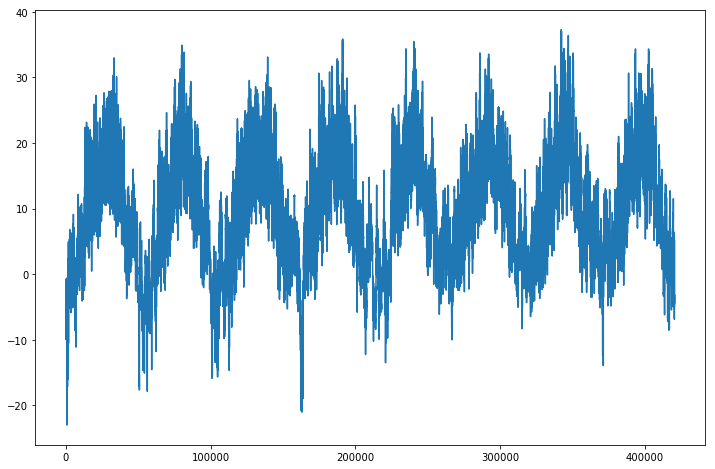

In [6]:
# Plotting the data
from matplotlib import pyplot as plt


# Temperature (in degrees Celsius)
plt.figure(figsize = (12, 8))
temp = float_data[:, 1]  
plt.plot(range(len(temp)), temp)
plt.show()

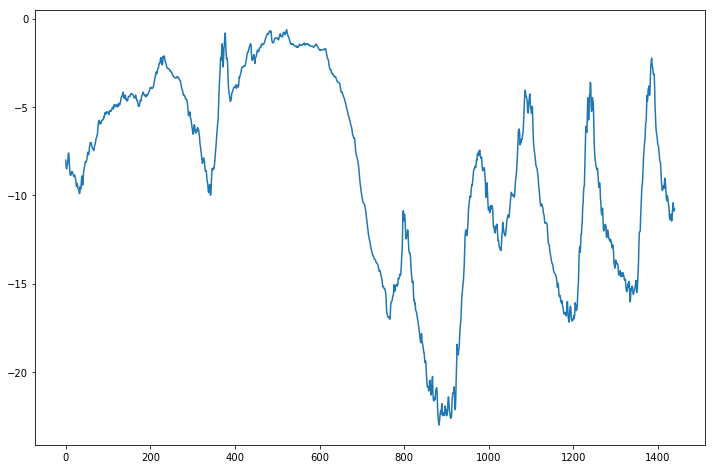

In [7]:
# The data is recorded every 10 minutes.
# Let's plot data for the first ten days.
numer_of_values_first_day = 6 * 24 * 10

plt.figure(figsize = (12, 8))

plt.plot(range(numer_of_values_first_day), temp[:numer_of_values_first_day])
plt.show()

## Preparing the data

In [8]:
# Taking first 200k datapoints and normalization.
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

In [9]:
# Generator preparing the data
def data_preparator(data, 
                    lookback, 
                    delay, 
                    min_index, 
                    max_index,
                    shuffle = False, 
                    batch_size = 128, 
                    step = 6):
    # If the max_index is not given then use max number
    # of data points - delay - 1
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, 
                size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        return samples, targets

In [10]:
samples_for_analysis, targets_for_analysis = data_preparator(float_data,
                                                             lookback = 1440,
                                                             delay = 144,
                                                             min_index = 0,
                                                             max_index = 200000,
                                                             shuffle = False,
                                                             step = 1, 
                                                             batch_size = 128)

In [11]:
# Shape (batch_size, numer_of_samples, number_of_features)
samples_for_analysis.shape

(128, 1440, 14)

In [12]:
targets_for_analysis.shape

(128,)

In [13]:
samples_for_analysis[0, :, 0].shape[0]

1440

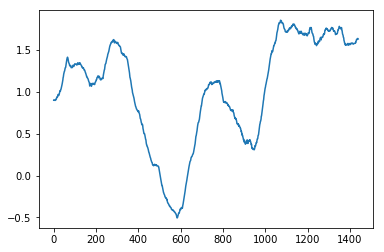

In [14]:
plt.plot(range(samples_for_analysis[0, :, 0].shape[0]), samples_for_analysis[0, :, 0])
plt.show()

In [15]:
float_data.shape

(420551, 14)

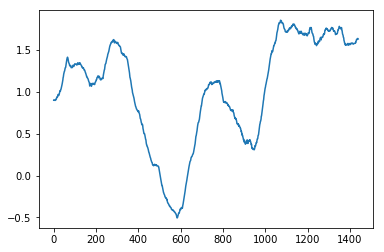

In [16]:
plt.plot(range(samples_for_analysis[0, :, 0].shape[0]), float_data[:1440, 0])
plt.show()

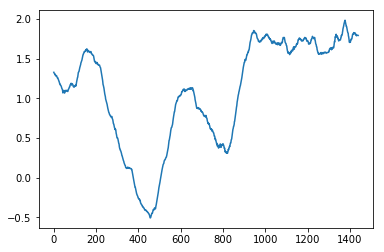

In [17]:
plt.plot(range(samples_for_analysis[127, :, 0].shape[0]), samples_for_analysis[127, :, 0])
plt.show()

In [18]:
# The data is shifted.
# The function creates a batch of sequences of shape (batch_size, number_of_samples, number_of_features).

## Machine Learning

In [19]:
# Generator preparing the data
def generator(data, 
              lookback, 
              delay, 
              min_index, 
              max_index,
              shuffle = False, 
              batch_size = 128, 
              step = 6):
    # If the max_index is not given then use max number
    # of data points - delay - 1
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, 
                size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [20]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [21]:
train_gen = generator(float_data,
                      lookback = lookback,
                      delay = delay,
                      min_index = 0,
                      max_index = 200000,
                      shuffle = True,
                      step = step, 
                      batch_size = batch_size)
val_gen = generator(float_data,
                    lookback = lookback,
                    delay = delay,
                    min_index = 200001,
                    max_index = 300000,
                    step = step,
                    batch_size = batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay = delay,
                     min_index = 300001,
                     max_index = None,
                     step = step,
                     batch_size = batch_size)

In [22]:
# Number of steps to be drawn from train_gen to see the entire training set
train_steps = (200000 - lookback) // batch_size
train_steps

1551

In [23]:
# Number of steps to be drawn from val_den to see the entire validation set
val_steps = (300000 - 200001 - lookback) // batch_size
val_steps

769

In [24]:
# Number of steps to be drawn from test_gen to see the entire test set
test_steps = (len(float_data) - 300001 - lookback) // batch_size
test_steps

930

## Naive Method

In [25]:
# Mean absolute error 
# Common-sense approach with predicting that the temperature 24 hours from now will be equal to temperature right now.
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


## Densely connected model

In [26]:
from keras.models import Sequential
from keras.layers import Flatten, Dense
from keras.optimizers import RMSprop

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [27]:
sequence_len = lookback // step
sequence_len

240

In [28]:
number_of_features = float_data.shape[-1]
number_of_features

14

In [29]:
model = Sequential()
model.add(Flatten(input_shape = (sequence_len, number_of_features)))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = RMSprop(), 
              loss = 'mae')

Explanation:

- steps_per_epoch: Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. It should typically be equal to the number of samples of your dataset divided by the batch size. Optional for Sequence: if unspecified, will use the len(generator) as a number of steps.

In [30]:
history = model.fit_generator(generator = train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - ETA: 14:09 - loss: 1.59 - ETA: 2:54 - loss: 3.4921 - ETA: 1:39 - loss: 3.609 - ETA: 1:10 - loss: 3.419 - ETA: 55s - loss: 3.226 - ETA: 47s - loss: 3.06 - ETA: 40s - loss: 2.94 - ETA: 37s - loss: 2.85 - ETA: 35s - loss: 2.81 - ETA: 32s - loss: 2.71 - ETA: 31s - loss: 2.68 - ETA: 29s - loss: 2.63 - ETA: 27s - loss: 2.58 - ETA: 26s - loss: 2.56 - ETA: 25s - loss: 2.54 - ETA: 24s - loss: 2.52 - ETA: 23s - loss: 2.49 - ETA: 22s - loss: 2.45 - ETA: 21s - loss: 2.41 - ETA: 20s - loss: 2.38 - ETA: 19s - loss: 2.36 - ETA: 19s - loss: 2.33 - ETA: 18s - loss: 2.32 - ETA: 18s - loss: 2.31 - ETA: 17s - loss: 2.29 - ETA: 17s - loss: 2.28 - ETA: 16s - loss: 2.27 - ETA: 16s - loss: 2.26 - ETA: 16s - loss: 2.24 - ETA: 15s - loss: 2.21 - ETA: 15s - loss: 2.20 - ETA: 15s - loss: 2.19 - ETA: 14s - loss: 2.18 - ETA: 14s - loss: 2.16 - ETA: 14s - loss: 2.16 - ETA: 14s - loss: 2.15 - ETA: 13s - loss: 2.14 - ETA: 13s - loss: 2.13 - ETA: 13s - loss: 2.13 - 

500/500 [==============================] - ETA: 3s - loss: 0.707 - ETA: 5s - loss: 0.733 - ETA: 5s - loss: 0.744 - ETA: 6s - loss: 0.747 - ETA: 6s - loss: 0.730 - ETA: 7s - loss: 0.746 - ETA: 7s - loss: 0.756 - ETA: 7s - loss: 0.739 - ETA: 8s - loss: 0.739 - ETA: 7s - loss: 0.712 - ETA: 8s - loss: 0.722 - ETA: 8s - loss: 0.728 - ETA: 8s - loss: 0.718 - ETA: 8s - loss: 0.716 - ETA: 8s - loss: 0.717 - ETA: 8s - loss: 0.714 - ETA: 8s - loss: 0.711 - ETA: 8s - loss: 0.706 - ETA: 8s - loss: 0.702 - ETA: 8s - loss: 0.695 - ETA: 8s - loss: 0.691 - ETA: 8s - loss: 0.693 - ETA: 8s - loss: 0.695 - ETA: 8s - loss: 0.696 - ETA: 8s - loss: 0.694 - ETA: 8s - loss: 0.695 - ETA: 8s - loss: 0.694 - ETA: 8s - loss: 0.694 - ETA: 8s - loss: 0.694 - ETA: 8s - loss: 0.693 - ETA: 8s - loss: 0.692 - ETA: 8s - loss: 0.692 - ETA: 8s - loss: 0.688 - ETA: 8s - loss: 0.685 - ETA: 8s - loss: 0.682 - ETA: 8s - loss: 0.682 - ETA: 8s - loss: 0.679 - ETA: 8s - loss: 0.679 - ETA: 8s - loss: 0.681 - ETA: 8s - loss: 0.680

500/500 [==============================] - ETA: 4s - loss: 0.278 - ETA: 4s - loss: 0.291 - ETA: 4s - loss: 0.284 - ETA: 5s - loss: 0.280 - ETA: 6s - loss: 0.280 - ETA: 6s - loss: 0.276 - ETA: 6s - loss: 0.275 - ETA: 6s - loss: 0.280 - ETA: 7s - loss: 0.277 - ETA: 7s - loss: 0.276 - ETA: 6s - loss: 0.275 - ETA: 6s - loss: 0.276 - ETA: 6s - loss: 0.277 - ETA: 6s - loss: 0.279 - ETA: 6s - loss: 0.278 - ETA: 6s - loss: 0.276 - ETA: 6s - loss: 0.277 - ETA: 6s - loss: 0.279 - ETA: 6s - loss: 0.277 - ETA: 6s - loss: 0.278 - ETA: 6s - loss: 0.277 - ETA: 6s - loss: 0.276 - ETA: 6s - loss: 0.276 - ETA: 6s - loss: 0.276 - ETA: 6s - loss: 0.276 - ETA: 6s - loss: 0.276 - ETA: 6s - loss: 0.276 - ETA: 6s - loss: 0.276 - ETA: 6s - loss: 0.276 - ETA: 6s - loss: 0.275 - ETA: 6s - loss: 0.275 - ETA: 5s - loss: 0.275 - ETA: 5s - loss: 0.274 - ETA: 5s - loss: 0.275 - ETA: 5s - loss: 0.275 - ETA: 5s - loss: 0.275 - ETA: 5s - loss: 0.275 - ETA: 5s - loss: 0.275 - ETA: 5s - loss: 0.275 - ETA: 5s - loss: 0.275

500/500 [==============================] - ETA: 4s - loss: 0.228 - ETA: 4s - loss: 0.240 - ETA: 4s - loss: 0.241 - ETA: 6s - loss: 0.248 - ETA: 6s - loss: 0.245 - ETA: 7s - loss: 0.246 - ETA: 7s - loss: 0.243 - ETA: 7s - loss: 0.242 - ETA: 7s - loss: 0.246 - ETA: 7s - loss: 0.246 - ETA: 7s - loss: 0.246 - ETA: 7s - loss: 0.248 - ETA: 7s - loss: 0.248 - ETA: 7s - loss: 0.249 - ETA: 7s - loss: 0.248 - ETA: 7s - loss: 0.248 - ETA: 7s - loss: 0.247 - ETA: 7s - loss: 0.247 - ETA: 7s - loss: 0.246 - ETA: 7s - loss: 0.247 - ETA: 7s - loss: 0.247 - ETA: 7s - loss: 0.248 - ETA: 7s - loss: 0.247 - ETA: 7s - loss: 0.248 - ETA: 7s - loss: 0.248 - ETA: 7s - loss: 0.247 - ETA: 7s - loss: 0.247 - ETA: 7s - loss: 0.247 - ETA: 7s - loss: 0.247 - ETA: 7s - loss: 0.246 - ETA: 7s - loss: 0.246 - ETA: 6s - loss: 0.246 - ETA: 6s - loss: 0.246 - ETA: 6s - loss: 0.246 - ETA: 6s - loss: 0.247 - ETA: 6s - loss: 0.247 - ETA: 6s - loss: 0.247 - ETA: 6s - loss: 0.247 - ETA: 6s - loss: 0.247 - ETA: 6s - loss: 0.247

500/500 [==============================] - ETA: 10s - loss: 0.22 - ETA: 5s - loss: 0.2486 - ETA: 6s - loss: 0.244 - ETA: 6s - loss: 0.248 - ETA: 7s - loss: 0.243 - ETA: 8s - loss: 0.241 - ETA: 8s - loss: 0.237 - ETA: 7s - loss: 0.236 - ETA: 7s - loss: 0.236 - ETA: 7s - loss: 0.235 - ETA: 7s - loss: 0.233 - ETA: 7s - loss: 0.231 - ETA: 7s - loss: 0.234 - ETA: 7s - loss: 0.235 - ETA: 7s - loss: 0.235 - ETA: 7s - loss: 0.234 - ETA: 7s - loss: 0.234 - ETA: 8s - loss: 0.233 - ETA: 8s - loss: 0.233 - ETA: 8s - loss: 0.234 - ETA: 7s - loss: 0.234 - ETA: 7s - loss: 0.234 - ETA: 7s - loss: 0.234 - ETA: 7s - loss: 0.235 - ETA: 7s - loss: 0.234 - ETA: 7s - loss: 0.234 - ETA: 7s - loss: 0.234 - ETA: 7s - loss: 0.236 - ETA: 7s - loss: 0.236 - ETA: 7s - loss: 0.235 - ETA: 7s - loss: 0.234 - ETA: 7s - loss: 0.234 - ETA: 7s - loss: 0.234 - ETA: 7s - loss: 0.235 - ETA: 7s - loss: 0.234 - ETA: 6s - loss: 0.234 - ETA: 6s - loss: 0.234 - ETA: 6s - loss: 0.234 - ETA: 6s - loss: 0.234 - ETA: 6s - loss: 0.23

500/500 [==============================] - ETA: 3s - loss: 0.205 - ETA: 4s - loss: 0.215 - ETA: 5s - loss: 0.227 - ETA: 5s - loss: 0.229 - ETA: 7s - loss: 0.226 - ETA: 7s - loss: 0.227 - ETA: 7s - loss: 0.225 - ETA: 7s - loss: 0.229 - ETA: 7s - loss: 0.227 - ETA: 7s - loss: 0.225 - ETA: 7s - loss: 0.223 - ETA: 7s - loss: 0.226 - ETA: 7s - loss: 0.224 - ETA: 7s - loss: 0.224 - ETA: 7s - loss: 0.223 - ETA: 7s - loss: 0.224 - ETA: 7s - loss: 0.223 - ETA: 7s - loss: 0.224 - ETA: 6s - loss: 0.224 - ETA: 6s - loss: 0.224 - ETA: 6s - loss: 0.224 - ETA: 6s - loss: 0.223 - ETA: 6s - loss: 0.223 - ETA: 6s - loss: 0.224 - ETA: 6s - loss: 0.223 - ETA: 6s - loss: 0.224 - ETA: 6s - loss: 0.224 - ETA: 6s - loss: 0.223 - ETA: 6s - loss: 0.223 - ETA: 6s - loss: 0.222 - ETA: 6s - loss: 0.223 - ETA: 6s - loss: 0.222 - ETA: 6s - loss: 0.222 - ETA: 6s - loss: 0.222 - ETA: 6s - loss: 0.222 - ETA: 6s - loss: 0.223 - ETA: 5s - loss: 0.223 - ETA: 5s - loss: 0.223 - ETA: 5s - loss: 0.223 - ETA: 5s - loss: 0.223

500/500 [==============================] - ETA: 3s - loss: 0.192 - ETA: 5s - loss: 0.194 - ETA: 5s - loss: 0.203 - ETA: 6s - loss: 0.206 - ETA: 7s - loss: 0.203 - ETA: 7s - loss: 0.202 - ETA: 7s - loss: 0.202 - ETA: 7s - loss: 0.209 - ETA: 7s - loss: 0.212 - ETA: 7s - loss: 0.213 - ETA: 7s - loss: 0.213 - ETA: 7s - loss: 0.212 - ETA: 7s - loss: 0.212 - ETA: 7s - loss: 0.211 - ETA: 7s - loss: 0.211 - ETA: 7s - loss: 0.212 - ETA: 7s - loss: 0.212 - ETA: 7s - loss: 0.212 - ETA: 7s - loss: 0.213 - ETA: 7s - loss: 0.213 - ETA: 6s - loss: 0.211 - ETA: 6s - loss: 0.211 - ETA: 6s - loss: 0.212 - ETA: 6s - loss: 0.212 - ETA: 6s - loss: 0.212 - ETA: 6s - loss: 0.213 - ETA: 6s - loss: 0.212 - ETA: 6s - loss: 0.212 - ETA: 6s - loss: 0.213 - ETA: 6s - loss: 0.213 - ETA: 6s - loss: 0.213 - ETA: 6s - loss: 0.213 - ETA: 6s - loss: 0.213 - ETA: 6s - loss: 0.213 - ETA: 6s - loss: 0.214 - ETA: 6s - loss: 0.214 - ETA: 5s - loss: 0.213 - ETA: 5s - loss: 0.214 - ETA: 5s - loss: 0.214 - ETA: 5s - loss: 0.215

500/500 [==============================] - ETA: 3s - loss: 0.212 - ETA: 4s - loss: 0.222 - ETA: 4s - loss: 0.215 - ETA: 6s - loss: 0.214 - ETA: 7s - loss: 0.215 - ETA: 7s - loss: 0.214 - ETA: 7s - loss: 0.212 - ETA: 7s - loss: 0.210 - ETA: 7s - loss: 0.208 - ETA: 7s - loss: 0.208 - ETA: 7s - loss: 0.209 - ETA: 7s - loss: 0.211 - ETA: 7s - loss: 0.208 - ETA: 7s - loss: 0.207 - ETA: 7s - loss: 0.210 - ETA: 7s - loss: 0.210 - ETA: 7s - loss: 0.210 - ETA: 6s - loss: 0.210 - ETA: 6s - loss: 0.212 - ETA: 6s - loss: 0.210 - ETA: 6s - loss: 0.211 - ETA: 6s - loss: 0.211 - ETA: 6s - loss: 0.211 - ETA: 6s - loss: 0.210 - ETA: 6s - loss: 0.211 - ETA: 6s - loss: 0.211 - ETA: 6s - loss: 0.210 - ETA: 6s - loss: 0.211 - ETA: 6s - loss: 0.210 - ETA: 6s - loss: 0.210 - ETA: 6s - loss: 0.210 - ETA: 6s - loss: 0.210 - ETA: 6s - loss: 0.210 - ETA: 6s - loss: 0.210 - ETA: 6s - loss: 0.210 - ETA: 6s - loss: 0.209 - ETA: 6s - loss: 0.209 - ETA: 5s - loss: 0.210 - ETA: 5s - loss: 0.210 - ETA: 5s - loss: 0.210

500/500 [==============================] - ETA: 4s - loss: 0.200 - ETA: 5s - loss: 0.190 - ETA: 6s - loss: 0.192 - ETA: 6s - loss: 0.199 - ETA: 7s - loss: 0.202 - ETA: 7s - loss: 0.199 - ETA: 7s - loss: 0.202 - ETA: 7s - loss: 0.204 - ETA: 7s - loss: 0.202 - ETA: 7s - loss: 0.200 - ETA: 7s - loss: 0.203 - ETA: 7s - loss: 0.204 - ETA: 7s - loss: 0.203 - ETA: 6s - loss: 0.203 - ETA: 6s - loss: 0.203 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.204 - ETA: 6s - loss: 0.204 - ETA: 6s - loss: 0.206 - ETA: 6s - loss: 0.206 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.204 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.204 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 5s - loss: 0.206 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.204 - ETA: 5s - loss: 0.204

500/500 [==============================] - ETA: 6s - loss: 0.164 - ETA: 6s - loss: 0.192 - ETA: 7s - loss: 0.202 - ETA: 9s - loss: 0.206 - ETA: 8s - loss: 0.204 - ETA: 9s - loss: 0.206 - ETA: 9s - loss: 0.204 - ETA: 9s - loss: 0.200 - ETA: 8s - loss: 0.198 - ETA: 8s - loss: 0.200 - ETA: 8s - loss: 0.199 - ETA: 8s - loss: 0.200 - ETA: 8s - loss: 0.198 - ETA: 8s - loss: 0.200 - ETA: 8s - loss: 0.200 - ETA: 7s - loss: 0.200 - ETA: 7s - loss: 0.199 - ETA: 7s - loss: 0.199 - ETA: 7s - loss: 0.199 - ETA: 7s - loss: 0.199 - ETA: 7s - loss: 0.198 - ETA: 7s - loss: 0.198 - ETA: 7s - loss: 0.198 - ETA: 7s - loss: 0.198 - ETA: 7s - loss: 0.199 - ETA: 7s - loss: 0.198 - ETA: 7s - loss: 0.199 - ETA: 6s - loss: 0.199 - ETA: 6s - loss: 0.200 - ETA: 6s - loss: 0.199 - ETA: 6s - loss: 0.199 - ETA: 6s - loss: 0.199 - ETA: 6s - loss: 0.199 - ETA: 6s - loss: 0.198 - ETA: 6s - loss: 0.198 - ETA: 6s - loss: 0.198 - ETA: 6s - loss: 0.199 - ETA: 6s - loss: 0.200 - ETA: 6s - loss: 0.200 - ETA: 6s - loss: 0.200

500/500 [==============================] - ETA: 3s - loss: 0.178 - ETA: 6s - loss: 0.183 - ETA: 7s - loss: 0.181 - ETA: 6s - loss: 0.195 - ETA: 8s - loss: 0.194 - ETA: 8s - loss: 0.193 - ETA: 8s - loss: 0.194 - ETA: 8s - loss: 0.192 - ETA: 8s - loss: 0.195 - ETA: 8s - loss: 0.196 - ETA: 8s - loss: 0.197 - ETA: 8s - loss: 0.195 - ETA: 8s - loss: 0.197 - ETA: 8s - loss: 0.197 - ETA: 8s - loss: 0.196 - ETA: 8s - loss: 0.196 - ETA: 8s - loss: 0.197 - ETA: 8s - loss: 0.195 - ETA: 8s - loss: 0.194 - ETA: 7s - loss: 0.196 - ETA: 7s - loss: 0.196 - ETA: 7s - loss: 0.196 - ETA: 7s - loss: 0.196 - ETA: 7s - loss: 0.197 - ETA: 7s - loss: 0.196 - ETA: 7s - loss: 0.195 - ETA: 7s - loss: 0.194 - ETA: 7s - loss: 0.195 - ETA: 7s - loss: 0.195 - ETA: 7s - loss: 0.195 - ETA: 7s - loss: 0.195 - ETA: 7s - loss: 0.197 - ETA: 7s - loss: 0.197 - ETA: 7s - loss: 0.197 - ETA: 7s - loss: 0.196 - ETA: 6s - loss: 0.197 - ETA: 6s - loss: 0.197 - ETA: 6s - loss: 0.197 - ETA: 6s - loss: 0.197 - ETA: 6s - loss: 0.197

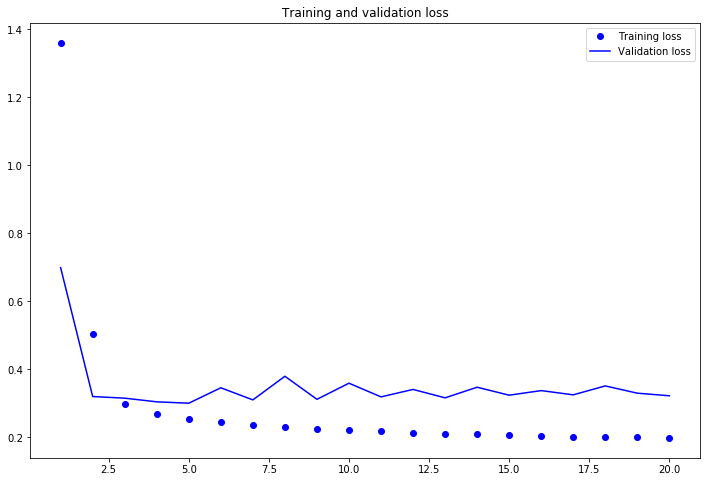

In [31]:
# Plotting the results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize = (12, 8))
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## GRU Basic Network

In [32]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(units = 32, 
                     input_shape = (None, number_of_features)))
model.add(layers.Dense(units = 1))

model.compile(optimizer = RMSprop(), 
              loss = 'mae')

In [33]:
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/20


314/500 [=================>............] - ETA: 11:56 - loss: 0.66 - ETA: 7:42 - loss: 0.5553 - ETA: 6:23 - loss: 0.515 - ETA: 5:43 - loss: 0.507 - ETA: 5:19 - loss: 0.487 - ETA: 5:01 - loss: 0.467 - ETA: 4:46 - loss: 0.455 - ETA: 4:35 - loss: 0.446 - ETA: 4:26 - loss: 0.434 - ETA: 4:20 - loss: 0.426 - ETA: 4:15 - loss: 0.417 - ETA: 4:11 - loss: 0.411 - ETA: 4:09 - loss: 0.406 - ETA: 4:05 - loss: 0.405 - ETA: 4:05 - loss: 0.404 - ETA: 4:04 - loss: 0.402 - ETA: 4:02 - loss: 0.400 - ETA: 4:00 - loss: 0.394 - ETA: 3:59 - loss: 0.391 - ETA: 3:57 - loss: 0.390 - ETA: 3:56 - loss: 0.388 - ETA: 3:54 - loss: 0.384 - ETA: 3:53 - loss: 0.381 - ETA: 3:52 - loss: 0.378 - ETA: 3:50 - loss: 0.375 - ETA: 3:49 - loss: 0.373 - ETA: 3:48 - loss: 0.372 - ETA: 3:46 - loss: 0.370 - ETA: 3:44 - loss: 0.369 - ETA: 3:43 - loss: 0.367 - ETA: 3:41 - loss: 0.367 - ETA: 3:40 - loss: 0.367 - ETA: 3:38 - loss: 0.366 - ETA: 3:37 - loss: 0.365 - ETA: 3:36 - loss: 0.364 - ETA: 3:35 - loss: 0.363 - ETA: 3:33 - loss: 0.

500/500 [==============================] - ETA: 1:18 - loss: 0.308 - ETA: 1:18 - loss: 0.308 - ETA: 1:17 - loss: 0.308 - ETA: 1:17 - loss: 0.308 - ETA: 1:17 - loss: 0.307 - ETA: 1:16 - loss: 0.307 - ETA: 1:16 - loss: 0.307 - ETA: 1:15 - loss: 0.307 - ETA: 1:15 - loss: 0.307 - ETA: 1:14 - loss: 0.307 - ETA: 1:14 - loss: 0.307 - ETA: 1:14 - loss: 0.307 - ETA: 1:13 - loss: 0.307 - ETA: 1:13 - loss: 0.307 - ETA: 1:12 - loss: 0.307 - ETA: 1:12 - loss: 0.307 - ETA: 1:11 - loss: 0.307 - ETA: 1:11 - loss: 0.307 - ETA: 1:11 - loss: 0.307 - ETA: 1:10 - loss: 0.307 - ETA: 1:10 - loss: 0.307 - ETA: 1:09 - loss: 0.307 - ETA: 1:09 - loss: 0.307 - ETA: 1:08 - loss: 0.307 - ETA: 1:08 - loss: 0.307 - ETA: 1:08 - loss: 0.307 - ETA: 1:07 - loss: 0.307 - ETA: 1:07 - loss: 0.307 - ETA: 1:06 - loss: 0.307 - ETA: 1:06 - loss: 0.307 - ETA: 1:05 - loss: 0.307 - ETA: 1:05 - loss: 0.307 - ETA: 1:05 - loss: 0.306 - ETA: 1:04 - loss: 0.306 - ETA: 1:04 - loss: 0.306 - ETA: 1:03 - loss: 0.306 - ETA: 1:03 - loss: 0.3

314/500 [=================>............] - ETA: 2:54 - loss: 0.265 - ETA: 2:53 - loss: 0.282 - ETA: 2:54 - loss: 0.281 - ETA: 2:54 - loss: 0.285 - ETA: 2:54 - loss: 0.283 - ETA: 2:54 - loss: 0.285 - ETA: 2:54 - loss: 0.283 - ETA: 2:53 - loss: 0.286 - ETA: 2:52 - loss: 0.285 - ETA: 2:52 - loss: 0.288 - ETA: 2:52 - loss: 0.284 - ETA: 2:52 - loss: 0.285 - ETA: 2:51 - loss: 0.284 - ETA: 2:51 - loss: 0.285 - ETA: 2:51 - loss: 0.290 - ETA: 2:50 - loss: 0.290 - ETA: 2:50 - loss: 0.291 - ETA: 2:50 - loss: 0.292 - ETA: 2:49 - loss: 0.291 - ETA: 2:49 - loss: 0.292 - ETA: 2:48 - loss: 0.293 - ETA: 2:48 - loss: 0.293 - ETA: 2:47 - loss: 0.292 - ETA: 2:47 - loss: 0.292 - ETA: 2:47 - loss: 0.293 - ETA: 2:47 - loss: 0.294 - ETA: 2:46 - loss: 0.295 - ETA: 2:46 - loss: 0.293 - ETA: 2:46 - loss: 0.293 - ETA: 2:46 - loss: 0.294 - ETA: 2:46 - loss: 0.292 - ETA: 2:46 - loss: 0.292 - ETA: 2:45 - loss: 0.293 - ETA: 2:45 - loss: 0.294 - ETA: 2:44 - loss: 0.294 - ETA: 2:44 - loss: 0.294 - ETA: 2:44 - loss: 0.2

500/500 [==============================] - ETA: 1:09 - loss: 0.286 - ETA: 1:09 - loss: 0.286 - ETA: 1:08 - loss: 0.286 - ETA: 1:08 - loss: 0.286 - ETA: 1:08 - loss: 0.286 - ETA: 1:07 - loss: 0.286 - ETA: 1:07 - loss: 0.286 - ETA: 1:06 - loss: 0.286 - ETA: 1:06 - loss: 0.286 - ETA: 1:06 - loss: 0.286 - ETA: 1:05 - loss: 0.286 - ETA: 1:05 - loss: 0.286 - ETA: 1:04 - loss: 0.286 - ETA: 1:04 - loss: 0.286 - ETA: 1:04 - loss: 0.286 - ETA: 1:03 - loss: 0.286 - ETA: 1:03 - loss: 0.286 - ETA: 1:02 - loss: 0.286 - ETA: 1:02 - loss: 0.286 - ETA: 1:02 - loss: 0.286 - ETA: 1:01 - loss: 0.286 - ETA: 1:01 - loss: 0.286 - ETA: 1:01 - loss: 0.286 - ETA: 1:00 - loss: 0.286 - ETA: 1:00 - loss: 0.286 - ETA: 1:00 - loss: 0.286 - ETA: 59s - loss: 0.286 - ETA: 59s - loss: 0.28 - ETA: 58s - loss: 0.28 - ETA: 58s - loss: 0.28 - ETA: 58s - loss: 0.28 - ETA: 57s - loss: 0.28 - ETA: 57s - loss: 0.28 - ETA: 56s - loss: 0.28 - ETA: 56s - loss: 0.28 - ETA: 56s - loss: 0.28 - ETA: 55s - loss: 0.28 - ETA: 55s - loss:

314/500 [=================>............] - ETA: 2:55 - loss: 0.276 - ETA: 2:54 - loss: 0.278 - ETA: 2:54 - loss: 0.275 - ETA: 2:54 - loss: 0.279 - ETA: 2:54 - loss: 0.275 - ETA: 2:54 - loss: 0.274 - ETA: 2:53 - loss: 0.274 - ETA: 2:53 - loss: 0.273 - ETA: 2:53 - loss: 0.274 - ETA: 2:53 - loss: 0.273 - ETA: 2:52 - loss: 0.274 - ETA: 2:53 - loss: 0.273 - ETA: 2:52 - loss: 0.274 - ETA: 2:52 - loss: 0.275 - ETA: 2:51 - loss: 0.272 - ETA: 2:51 - loss: 0.272 - ETA: 2:51 - loss: 0.273 - ETA: 2:50 - loss: 0.274 - ETA: 2:50 - loss: 0.275 - ETA: 2:49 - loss: 0.275 - ETA: 2:49 - loss: 0.275 - ETA: 2:49 - loss: 0.275 - ETA: 2:48 - loss: 0.274 - ETA: 2:48 - loss: 0.274 - ETA: 2:47 - loss: 0.274 - ETA: 2:47 - loss: 0.273 - ETA: 2:47 - loss: 0.274 - ETA: 2:46 - loss: 0.274 - ETA: 2:46 - loss: 0.274 - ETA: 2:46 - loss: 0.274 - ETA: 2:45 - loss: 0.275 - ETA: 2:45 - loss: 0.275 - ETA: 2:45 - loss: 0.275 - ETA: 2:44 - loss: 0.275 - ETA: 2:44 - loss: 0.275 - ETA: 2:44 - loss: 0.276 - ETA: 2:43 - loss: 0.2

500/500 [==============================] - ETA: 1:05 - loss: 0.279 - ETA: 1:05 - loss: 0.279 - ETA: 1:04 - loss: 0.279 - ETA: 1:04 - loss: 0.279 - ETA: 1:04 - loss: 0.279 - ETA: 1:03 - loss: 0.279 - ETA: 1:03 - loss: 0.279 - ETA: 1:03 - loss: 0.279 - ETA: 1:02 - loss: 0.279 - ETA: 1:02 - loss: 0.279 - ETA: 1:02 - loss: 0.279 - ETA: 1:01 - loss: 0.278 - ETA: 1:01 - loss: 0.278 - ETA: 1:00 - loss: 0.278 - ETA: 1:00 - loss: 0.278 - ETA: 1:00 - loss: 0.278 - ETA: 59s - loss: 0.279 - ETA: 59s - loss: 0.27 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 57s - loss: 0.27 - ETA: 57s - loss: 0.27 - ETA: 57s - loss: 0.27 - ETA: 56s - loss: 0.27 - ETA: 56s - loss: 0.27 - ETA: 56s - loss: 0.27 - ETA: 55s - loss: 0.27 - ETA: 55s - loss: 0.27 - ETA: 54s - loss: 0.27 - ETA: 54s - loss: 0.27 - ETA: 54s - loss: 0.27 - ETA: 53s - loss: 0.27 - ETA: 53s - loss: 0.27 - ETA: 53s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - l

314/500 [=================>............] - ETA: 2:52 - loss: 0.290 - ETA: 2:53 - loss: 0.281 - ETA: 2:53 - loss: 0.285 - ETA: 2:54 - loss: 0.280 - ETA: 2:53 - loss: 0.275 - ETA: 2:53 - loss: 0.279 - ETA: 2:52 - loss: 0.278 - ETA: 2:52 - loss: 0.280 - ETA: 2:52 - loss: 0.278 - ETA: 2:51 - loss: 0.279 - ETA: 2:51 - loss: 0.280 - ETA: 2:51 - loss: 0.280 - ETA: 2:50 - loss: 0.278 - ETA: 2:50 - loss: 0.278 - ETA: 2:50 - loss: 0.277 - ETA: 2:49 - loss: 0.278 - ETA: 2:49 - loss: 0.279 - ETA: 2:49 - loss: 0.280 - ETA: 2:49 - loss: 0.278 - ETA: 2:48 - loss: 0.278 - ETA: 2:48 - loss: 0.278 - ETA: 2:48 - loss: 0.278 - ETA: 2:48 - loss: 0.279 - ETA: 2:47 - loss: 0.280 - ETA: 2:47 - loss: 0.281 - ETA: 2:47 - loss: 0.281 - ETA: 2:46 - loss: 0.280 - ETA: 2:46 - loss: 0.280 - ETA: 2:46 - loss: 0.280 - ETA: 2:45 - loss: 0.280 - ETA: 2:45 - loss: 0.279 - ETA: 2:45 - loss: 0.279 - ETA: 2:44 - loss: 0.278 - ETA: 2:44 - loss: 0.279 - ETA: 2:43 - loss: 0.280 - ETA: 2:43 - loss: 0.279 - ETA: 2:43 - loss: 0.2

500/500 [==============================] - ETA: 1:05 - loss: 0.276 - ETA: 1:05 - loss: 0.276 - ETA: 1:04 - loss: 0.276 - ETA: 1:04 - loss: 0.276 - ETA: 1:04 - loss: 0.275 - ETA: 1:03 - loss: 0.276 - ETA: 1:03 - loss: 0.275 - ETA: 1:03 - loss: 0.276 - ETA: 1:02 - loss: 0.276 - ETA: 1:02 - loss: 0.276 - ETA: 1:02 - loss: 0.276 - ETA: 1:01 - loss: 0.276 - ETA: 1:01 - loss: 0.276 - ETA: 1:00 - loss: 0.276 - ETA: 1:00 - loss: 0.276 - ETA: 1:00 - loss: 0.276 - ETA: 59s - loss: 0.276 - ETA: 59s - loss: 0.27 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 57s - loss: 0.27 - ETA: 57s - loss: 0.27 - ETA: 57s - loss: 0.27 - ETA: 56s - loss: 0.27 - ETA: 56s - loss: 0.27 - ETA: 56s - loss: 0.27 - ETA: 55s - loss: 0.27 - ETA: 55s - loss: 0.27 - ETA: 54s - loss: 0.27 - ETA: 54s - loss: 0.27 - ETA: 54s - loss: 0.27 - ETA: 53s - loss: 0.27 - ETA: 53s - loss: 0.27 - ETA: 53s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - l

314/500 [=================>............] - ETA: 2:52 - loss: 0.242 - ETA: 2:54 - loss: 0.261 - ETA: 2:54 - loss: 0.263 - ETA: 2:53 - loss: 0.273 - ETA: 2:53 - loss: 0.275 - ETA: 2:54 - loss: 0.277 - ETA: 2:54 - loss: 0.278 - ETA: 2:53 - loss: 0.280 - ETA: 2:53 - loss: 0.279 - ETA: 2:52 - loss: 0.280 - ETA: 2:52 - loss: 0.277 - ETA: 2:52 - loss: 0.275 - ETA: 2:52 - loss: 0.274 - ETA: 2:51 - loss: 0.272 - ETA: 2:51 - loss: 0.272 - ETA: 2:51 - loss: 0.270 - ETA: 2:50 - loss: 0.272 - ETA: 2:50 - loss: 0.272 - ETA: 2:50 - loss: 0.272 - ETA: 2:49 - loss: 0.272 - ETA: 2:49 - loss: 0.272 - ETA: 2:49 - loss: 0.271 - ETA: 2:49 - loss: 0.269 - ETA: 2:48 - loss: 0.268 - ETA: 2:48 - loss: 0.267 - ETA: 2:47 - loss: 0.266 - ETA: 2:47 - loss: 0.267 - ETA: 2:47 - loss: 0.268 - ETA: 2:46 - loss: 0.269 - ETA: 2:46 - loss: 0.270 - ETA: 2:45 - loss: 0.271 - ETA: 2:45 - loss: 0.270 - ETA: 2:45 - loss: 0.271 - ETA: 2:44 - loss: 0.271 - ETA: 2:44 - loss: 0.272 - ETA: 2:44 - loss: 0.272 - ETA: 2:43 - loss: 0.2

500/500 [==============================] - ETA: 1:05 - loss: 0.271 - ETA: 1:05 - loss: 0.271 - ETA: 1:04 - loss: 0.271 - ETA: 1:04 - loss: 0.271 - ETA: 1:04 - loss: 0.271 - ETA: 1:03 - loss: 0.271 - ETA: 1:03 - loss: 0.271 - ETA: 1:03 - loss: 0.271 - ETA: 1:02 - loss: 0.271 - ETA: 1:02 - loss: 0.271 - ETA: 1:02 - loss: 0.271 - ETA: 1:01 - loss: 0.271 - ETA: 1:01 - loss: 0.271 - ETA: 1:00 - loss: 0.271 - ETA: 1:00 - loss: 0.271 - ETA: 1:00 - loss: 0.271 - ETA: 59s - loss: 0.271 - ETA: 59s - loss: 0.27 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 57s - loss: 0.27 - ETA: 57s - loss: 0.27 - ETA: 57s - loss: 0.27 - ETA: 56s - loss: 0.27 - ETA: 56s - loss: 0.27 - ETA: 56s - loss: 0.27 - ETA: 55s - loss: 0.27 - ETA: 55s - loss: 0.27 - ETA: 54s - loss: 0.27 - ETA: 54s - loss: 0.27 - ETA: 54s - loss: 0.27 - ETA: 53s - loss: 0.27 - ETA: 53s - loss: 0.27 - ETA: 53s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - loss: 0.27 - ETA: 52s - l

314/500 [=================>............] - ETA: 2:49 - loss: 0.292 - ETA: 2:53 - loss: 0.277 - ETA: 2:53 - loss: 0.271 - ETA: 2:56 - loss: 0.271 - ETA: 3:11 - loss: 0.279 - ETA: 3:14 - loss: 0.273 - ETA: 3:20 - loss: 0.273 - ETA: 3:16 - loss: 0.272 - ETA: 3:13 - loss: 0.276 - ETA: 3:11 - loss: 0.274 - ETA: 3:09 - loss: 0.273 - ETA: 3:07 - loss: 0.271 - ETA: 3:05 - loss: 0.270 - ETA: 3:04 - loss: 0.271 - ETA: 3:03 - loss: 0.269 - ETA: 3:02 - loss: 0.269 - ETA: 3:01 - loss: 0.269 - ETA: 3:00 - loss: 0.270 - ETA: 2:59 - loss: 0.271 - ETA: 2:58 - loss: 0.270 - ETA: 2:58 - loss: 0.270 - ETA: 2:57 - loss: 0.270 - ETA: 2:56 - loss: 0.271 - ETA: 2:56 - loss: 0.271 - ETA: 2:55 - loss: 0.270 - ETA: 2:54 - loss: 0.271 - ETA: 2:54 - loss: 0.270 - ETA: 2:53 - loss: 0.270 - ETA: 2:54 - loss: 0.269 - ETA: 2:53 - loss: 0.270 - ETA: 2:52 - loss: 0.271 - ETA: 2:52 - loss: 0.270 - ETA: 2:51 - loss: 0.269 - ETA: 2:51 - loss: 0.269 - ETA: 2:51 - loss: 0.268 - ETA: 2:50 - loss: 0.268 - ETA: 2:50 - loss: 0.2

500/500 [==============================] - ETA: 1:06 - loss: 0.266 - ETA: 1:05 - loss: 0.266 - ETA: 1:05 - loss: 0.266 - ETA: 1:05 - loss: 0.266 - ETA: 1:04 - loss: 0.265 - ETA: 1:04 - loss: 0.266 - ETA: 1:04 - loss: 0.266 - ETA: 1:03 - loss: 0.266 - ETA: 1:03 - loss: 0.266 - ETA: 1:02 - loss: 0.266 - ETA: 1:02 - loss: 0.266 - ETA: 1:02 - loss: 0.266 - ETA: 1:01 - loss: 0.266 - ETA: 1:01 - loss: 0.266 - ETA: 1:01 - loss: 0.266 - ETA: 1:00 - loss: 0.266 - ETA: 1:00 - loss: 0.266 - ETA: 1:00 - loss: 0.266 - ETA: 59s - loss: 0.266 - ETA: 59s - loss: 0.26 - ETA: 58s - loss: 0.26 - ETA: 58s - loss: 0.26 - ETA: 58s - loss: 0.26 - ETA: 57s - loss: 0.26 - ETA: 57s - loss: 0.26 - ETA: 57s - loss: 0.26 - ETA: 56s - loss: 0.26 - ETA: 56s - loss: 0.26 - ETA: 56s - loss: 0.26 - ETA: 55s - loss: 0.26 - ETA: 55s - loss: 0.26 - ETA: 55s - loss: 0.26 - ETA: 54s - loss: 0.26 - ETA: 54s - loss: 0.26 - ETA: 53s - loss: 0.26 - ETA: 53s - loss: 0.26 - ETA: 53s - loss: 0.26 - ETA: 52s - loss: 0.26 - ETA: 52s

314/500 [=================>............] - ETA: 2:54 - loss: 0.278 - ETA: 2:53 - loss: 0.277 - ETA: 2:54 - loss: 0.271 - ETA: 2:55 - loss: 0.268 - ETA: 2:54 - loss: 0.271 - ETA: 2:54 - loss: 0.269 - ETA: 2:54 - loss: 0.269 - ETA: 2:53 - loss: 0.265 - ETA: 2:53 - loss: 0.265 - ETA: 2:52 - loss: 0.263 - ETA: 2:52 - loss: 0.264 - ETA: 2:52 - loss: 0.264 - ETA: 2:51 - loss: 0.261 - ETA: 2:51 - loss: 0.260 - ETA: 2:51 - loss: 0.258 - ETA: 2:50 - loss: 0.256 - ETA: 2:50 - loss: 0.256 - ETA: 2:49 - loss: 0.257 - ETA: 2:49 - loss: 0.259 - ETA: 2:49 - loss: 0.259 - ETA: 2:49 - loss: 0.259 - ETA: 2:48 - loss: 0.262 - ETA: 2:48 - loss: 0.261 - ETA: 2:48 - loss: 0.260 - ETA: 2:47 - loss: 0.262 - ETA: 2:47 - loss: 0.262 - ETA: 2:46 - loss: 0.263 - ETA: 2:46 - loss: 0.262 - ETA: 2:46 - loss: 0.261 - ETA: 2:45 - loss: 0.261 - ETA: 2:45 - loss: 0.261 - ETA: 2:44 - loss: 0.261 - ETA: 2:44 - loss: 0.261 - ETA: 2:44 - loss: 0.261 - ETA: 2:43 - loss: 0.261 - ETA: 2:43 - loss: 0.260 - ETA: 2:43 - loss: 0.2

500/500 [==============================] - ETA: 1:05 - loss: 0.259 - ETA: 1:05 - loss: 0.259 - ETA: 1:04 - loss: 0.259 - ETA: 1:04 - loss: 0.259 - ETA: 1:04 - loss: 0.259 - ETA: 1:03 - loss: 0.259 - ETA: 1:03 - loss: 0.259 - ETA: 1:03 - loss: 0.259 - ETA: 1:02 - loss: 0.259 - ETA: 1:02 - loss: 0.259 - ETA: 1:02 - loss: 0.259 - ETA: 1:01 - loss: 0.259 - ETA: 1:01 - loss: 0.259 - ETA: 1:01 - loss: 0.259 - ETA: 1:00 - loss: 0.259 - ETA: 1:00 - loss: 0.259 - ETA: 59s - loss: 0.259 - ETA: 59s - loss: 0.25 - ETA: 59s - loss: 0.25 - ETA: 58s - loss: 0.25 - ETA: 58s - loss: 0.25 - ETA: 58s - loss: 0.25 - ETA: 57s - loss: 0.25 - ETA: 57s - loss: 0.25 - ETA: 57s - loss: 0.25 - ETA: 56s - loss: 0.25 - ETA: 56s - loss: 0.25 - ETA: 56s - loss: 0.25 - ETA: 55s - loss: 0.25 - ETA: 55s - loss: 0.25 - ETA: 55s - loss: 0.25 - ETA: 54s - loss: 0.25 - ETA: 54s - loss: 0.25 - ETA: 53s - loss: 0.25 - ETA: 53s - loss: 0.25 - ETA: 53s - loss: 0.25 - ETA: 52s - loss: 0.25 - ETA: 52s - loss: 0.25 - ETA: 52s - l

314/500 [=================>............] - ETA: 2:53 - loss: 0.260 - ETA: 2:52 - loss: 0.267 - ETA: 2:53 - loss: 0.265 - ETA: 2:54 - loss: 0.269 - ETA: 2:55 - loss: 0.268 - ETA: 2:54 - loss: 0.265 - ETA: 2:54 - loss: 0.269 - ETA: 2:54 - loss: 0.268 - ETA: 2:53 - loss: 0.269 - ETA: 2:53 - loss: 0.273 - ETA: 2:53 - loss: 0.271 - ETA: 2:53 - loss: 0.270 - ETA: 2:53 - loss: 0.268 - ETA: 2:52 - loss: 0.267 - ETA: 2:52 - loss: 0.264 - ETA: 2:52 - loss: 0.267 - ETA: 2:51 - loss: 0.266 - ETA: 2:51 - loss: 0.264 - ETA: 2:50 - loss: 0.264 - ETA: 2:50 - loss: 0.264 - ETA: 2:50 - loss: 0.263 - ETA: 2:49 - loss: 0.262 - ETA: 2:49 - loss: 0.262 - ETA: 2:48 - loss: 0.263 - ETA: 2:48 - loss: 0.262 - ETA: 2:48 - loss: 0.262 - ETA: 2:48 - loss: 0.262 - ETA: 2:47 - loss: 0.262 - ETA: 2:47 - loss: 0.261 - ETA: 2:47 - loss: 0.260 - ETA: 2:46 - loss: 0.259 - ETA: 2:46 - loss: 0.259 - ETA: 2:45 - loss: 0.259 - ETA: 2:45 - loss: 0.258 - ETA: 2:45 - loss: 0.258 - ETA: 2:44 - loss: 0.258 - ETA: 2:44 - loss: 0.2

500/500 [==============================] - ETA: 1:06 - loss: 0.257 - ETA: 1:05 - loss: 0.257 - ETA: 1:05 - loss: 0.257 - ETA: 1:05 - loss: 0.257 - ETA: 1:04 - loss: 0.257 - ETA: 1:04 - loss: 0.257 - ETA: 1:04 - loss: 0.257 - ETA: 1:03 - loss: 0.257 - ETA: 1:03 - loss: 0.257 - ETA: 1:03 - loss: 0.257 - ETA: 1:02 - loss: 0.257 - ETA: 1:02 - loss: 0.257 - ETA: 1:02 - loss: 0.257 - ETA: 1:01 - loss: 0.257 - ETA: 1:01 - loss: 0.257 - ETA: 1:01 - loss: 0.257 - ETA: 1:00 - loss: 0.257 - ETA: 1:00 - loss: 0.257 - ETA: 1:00 - loss: 0.257 - ETA: 59s - loss: 0.257 - ETA: 59s - loss: 0.25 - ETA: 58s - loss: 0.25 - ETA: 58s - loss: 0.25 - ETA: 58s - loss: 0.25 - ETA: 57s - loss: 0.25 - ETA: 57s - loss: 0.25 - ETA: 57s - loss: 0.25 - ETA: 56s - loss: 0.25 - ETA: 56s - loss: 0.25 - ETA: 56s - loss: 0.25 - ETA: 55s - loss: 0.25 - ETA: 55s - loss: 0.25 - ETA: 55s - loss: 0.25 - ETA: 54s - loss: 0.25 - ETA: 54s - loss: 0.25 - ETA: 53s - loss: 0.25 - ETA: 53s - loss: 0.25 - ETA: 53s - loss: 0.25 - ETA: 5

314/500 [=================>............] - ETA: 2:57 - loss: 0.254 - ETA: 2:56 - loss: 0.246 - ETA: 2:55 - loss: 0.256 - ETA: 2:55 - loss: 0.249 - ETA: 2:55 - loss: 0.250 - ETA: 2:54 - loss: 0.249 - ETA: 2:54 - loss: 0.255 - ETA: 2:54 - loss: 0.254 - ETA: 2:53 - loss: 0.252 - ETA: 2:53 - loss: 0.253 - ETA: 2:52 - loss: 0.255 - ETA: 2:52 - loss: 0.256 - ETA: 2:52 - loss: 0.257 - ETA: 2:51 - loss: 0.257 - ETA: 2:51 - loss: 0.259 - ETA: 2:51 - loss: 0.258 - ETA: 2:50 - loss: 0.259 - ETA: 2:50 - loss: 0.259 - ETA: 2:50 - loss: 0.256 - ETA: 2:49 - loss: 0.257 - ETA: 2:49 - loss: 0.258 - ETA: 2:49 - loss: 0.257 - ETA: 2:48 - loss: 0.258 - ETA: 2:48 - loss: 0.259 - ETA: 2:48 - loss: 0.259 - ETA: 2:47 - loss: 0.259 - ETA: 2:47 - loss: 0.258 - ETA: 2:46 - loss: 0.257 - ETA: 2:46 - loss: 0.258 - ETA: 2:46 - loss: 0.258 - ETA: 2:45 - loss: 0.259 - ETA: 2:45 - loss: 0.259 - ETA: 2:45 - loss: 0.260 - ETA: 2:44 - loss: 0.260 - ETA: 2:44 - loss: 0.259 - ETA: 2:44 - loss: 0.259 - ETA: 2:43 - loss: 0.2

500/500 [==============================] - ETA: 1:05 - loss: 0.255 - ETA: 1:05 - loss: 0.255 - ETA: 1:04 - loss: 0.255 - ETA: 1:04 - loss: 0.255 - ETA: 1:04 - loss: 0.255 - ETA: 1:03 - loss: 0.255 - ETA: 1:03 - loss: 0.255 - ETA: 1:03 - loss: 0.255 - ETA: 1:02 - loss: 0.255 - ETA: 1:02 - loss: 0.255 - ETA: 1:02 - loss: 0.255 - ETA: 1:01 - loss: 0.255 - ETA: 1:01 - loss: 0.255 - ETA: 1:01 - loss: 0.255 - ETA: 1:00 - loss: 0.255 - ETA: 1:00 - loss: 0.255 - ETA: 59s - loss: 0.255 - ETA: 59s - loss: 0.25 - ETA: 59s - loss: 0.25 - ETA: 58s - loss: 0.25 - ETA: 58s - loss: 0.25 - ETA: 58s - loss: 0.25 - ETA: 57s - loss: 0.25 - ETA: 57s - loss: 0.25 - ETA: 57s - loss: 0.25 - ETA: 56s - loss: 0.25 - ETA: 56s - loss: 0.25 - ETA: 56s - loss: 0.25 - ETA: 55s - loss: 0.25 - ETA: 55s - loss: 0.25 - ETA: 55s - loss: 0.25 - ETA: 54s - loss: 0.25 - ETA: 54s - loss: 0.25 - ETA: 53s - loss: 0.25 - ETA: 53s - loss: 0.25 - ETA: 53s - loss: 0.25 - ETA: 52s - loss: 0.25 - ETA: 52s - loss: 0.25 - ETA: 52s - l

314/500 [=================>............] - ETA: 2:50 - loss: 0.258 - ETA: 2:53 - loss: 0.265 - ETA: 2:53 - loss: 0.259 - ETA: 2:53 - loss: 0.259 - ETA: 2:54 - loss: 0.257 - ETA: 2:54 - loss: 0.253 - ETA: 2:54 - loss: 0.251 - ETA: 2:53 - loss: 0.249 - ETA: 2:53 - loss: 0.249 - ETA: 2:52 - loss: 0.251 - ETA: 2:52 - loss: 0.253 - ETA: 2:52 - loss: 0.253 - ETA: 2:52 - loss: 0.256 - ETA: 2:52 - loss: 0.256 - ETA: 2:51 - loss: 0.256 - ETA: 2:51 - loss: 0.259 - ETA: 2:51 - loss: 0.260 - ETA: 2:51 - loss: 0.259 - ETA: 2:50 - loss: 0.259 - ETA: 2:50 - loss: 0.259 - ETA: 2:49 - loss: 0.259 - ETA: 2:49 - loss: 0.258 - ETA: 2:49 - loss: 0.258 - ETA: 2:48 - loss: 0.258 - ETA: 2:48 - loss: 0.258 - ETA: 2:48 - loss: 0.256 - ETA: 2:47 - loss: 0.256 - ETA: 2:47 - loss: 0.255 - ETA: 2:47 - loss: 0.256 - ETA: 2:46 - loss: 0.255 - ETA: 2:46 - loss: 0.255 - ETA: 2:45 - loss: 0.254 - ETA: 2:45 - loss: 0.255 - ETA: 2:45 - loss: 0.255 - ETA: 2:44 - loss: 0.255 - ETA: 2:44 - loss: 0.256 - ETA: 2:44 - loss: 0.2

500/500 [==============================] - ETA: 1:05 - loss: 0.249 - ETA: 1:05 - loss: 0.249 - ETA: 1:04 - loss: 0.249 - ETA: 1:04 - loss: 0.249 - ETA: 1:04 - loss: 0.249 - ETA: 1:03 - loss: 0.249 - ETA: 1:03 - loss: 0.249 - ETA: 1:03 - loss: 0.249 - ETA: 1:02 - loss: 0.249 - ETA: 1:02 - loss: 0.249 - ETA: 1:02 - loss: 0.249 - ETA: 1:01 - loss: 0.249 - ETA: 1:01 - loss: 0.249 - ETA: 1:01 - loss: 0.249 - ETA: 1:00 - loss: 0.249 - ETA: 1:00 - loss: 0.249 - ETA: 59s - loss: 0.249 - ETA: 59s - loss: 0.24 - ETA: 59s - loss: 0.24 - ETA: 58s - loss: 0.24 - ETA: 58s - loss: 0.24 - ETA: 58s - loss: 0.24 - ETA: 57s - loss: 0.25 - ETA: 57s - loss: 0.25 - ETA: 57s - loss: 0.25 - ETA: 56s - loss: 0.25 - ETA: 56s - loss: 0.24 - ETA: 56s - loss: 0.24 - ETA: 55s - loss: 0.24 - ETA: 55s - loss: 0.24 - ETA: 54s - loss: 0.24 - ETA: 54s - loss: 0.24 - ETA: 54s - loss: 0.24 - ETA: 53s - loss: 0.24 - ETA: 53s - loss: 0.24 - ETA: 53s - loss: 0.24 - ETA: 52s - loss: 0.24 - ETA: 52s - loss: 0.24 - ETA: 52s - l

314/500 [=================>............] - ETA: 2:59 - loss: 0.244 - ETA: 2:57 - loss: 0.258 - ETA: 2:56 - loss: 0.254 - ETA: 2:56 - loss: 0.251 - ETA: 2:55 - loss: 0.249 - ETA: 2:55 - loss: 0.247 - ETA: 2:55 - loss: 0.248 - ETA: 2:55 - loss: 0.249 - ETA: 2:54 - loss: 0.245 - ETA: 2:54 - loss: 0.246 - ETA: 2:54 - loss: 0.247 - ETA: 2:53 - loss: 0.245 - ETA: 2:53 - loss: 0.246 - ETA: 2:52 - loss: 0.246 - ETA: 2:52 - loss: 0.245 - ETA: 2:51 - loss: 0.246 - ETA: 2:51 - loss: 0.245 - ETA: 2:51 - loss: 0.243 - ETA: 2:51 - loss: 0.244 - ETA: 2:50 - loss: 0.245 - ETA: 2:50 - loss: 0.245 - ETA: 2:49 - loss: 0.245 - ETA: 2:49 - loss: 0.245 - ETA: 2:49 - loss: 0.244 - ETA: 2:48 - loss: 0.245 - ETA: 2:48 - loss: 0.246 - ETA: 2:48 - loss: 0.245 - ETA: 2:47 - loss: 0.245 - ETA: 2:47 - loss: 0.244 - ETA: 2:46 - loss: 0.243 - ETA: 2:46 - loss: 0.244 - ETA: 2:46 - loss: 0.243 - ETA: 2:46 - loss: 0.244 - ETA: 2:45 - loss: 0.243 - ETA: 2:45 - loss: 0.243 - ETA: 2:44 - loss: 0.243 - ETA: 2:44 - loss: 0.2

500/500 [==============================] - ETA: 1:05 - loss: 0.247 - ETA: 1:05 - loss: 0.247 - ETA: 1:05 - loss: 0.247 - ETA: 1:04 - loss: 0.247 - ETA: 1:04 - loss: 0.247 - ETA: 1:03 - loss: 0.247 - ETA: 1:03 - loss: 0.247 - ETA: 1:03 - loss: 0.247 - ETA: 1:02 - loss: 0.247 - ETA: 1:02 - loss: 0.247 - ETA: 1:02 - loss: 0.247 - ETA: 1:01 - loss: 0.247 - ETA: 1:01 - loss: 0.247 - ETA: 1:01 - loss: 0.247 - ETA: 1:00 - loss: 0.247 - ETA: 1:00 - loss: 0.247 - ETA: 1:00 - loss: 0.247 - ETA: 59s - loss: 0.247 - ETA: 59s - loss: 0.24 - ETA: 58s - loss: 0.24 - ETA: 58s - loss: 0.24 - ETA: 58s - loss: 0.24 - ETA: 57s - loss: 0.24 - ETA: 57s - loss: 0.24 - ETA: 57s - loss: 0.24 - ETA: 56s - loss: 0.24 - ETA: 56s - loss: 0.24 - ETA: 56s - loss: 0.24 - ETA: 55s - loss: 0.24 - ETA: 55s - loss: 0.24 - ETA: 55s - loss: 0.24 - ETA: 54s - loss: 0.24 - ETA: 54s - loss: 0.24 - ETA: 54s - loss: 0.24 - ETA: 53s - loss: 0.24 - ETA: 53s - loss: 0.24 - ETA: 52s - loss: 0.24 - ETA: 52s - loss: 0.24 - ETA: 52s -

314/500 [=================>............] - ETA: 2:52 - loss: 0.236 - ETA: 2:54 - loss: 0.236 - ETA: 2:54 - loss: 0.240 - ETA: 2:55 - loss: 0.242 - ETA: 2:54 - loss: 0.242 - ETA: 2:53 - loss: 0.242 - ETA: 2:53 - loss: 0.243 - ETA: 2:53 - loss: 0.244 - ETA: 2:53 - loss: 0.243 - ETA: 2:52 - loss: 0.239 - ETA: 2:52 - loss: 0.240 - ETA: 2:52 - loss: 0.244 - ETA: 2:52 - loss: 0.244 - ETA: 2:51 - loss: 0.243 - ETA: 2:51 - loss: 0.244 - ETA: 2:51 - loss: 0.245 - ETA: 2:50 - loss: 0.247 - ETA: 2:50 - loss: 0.247 - ETA: 2:50 - loss: 0.246 - ETA: 2:49 - loss: 0.246 - ETA: 2:49 - loss: 0.244 - ETA: 2:49 - loss: 0.244 - ETA: 2:48 - loss: 0.244 - ETA: 2:48 - loss: 0.244 - ETA: 2:48 - loss: 0.244 - ETA: 2:47 - loss: 0.245 - ETA: 2:47 - loss: 0.245 - ETA: 2:47 - loss: 0.245 - ETA: 2:46 - loss: 0.244 - ETA: 2:46 - loss: 0.244 - ETA: 2:46 - loss: 0.244 - ETA: 2:45 - loss: 0.244 - ETA: 2:45 - loss: 0.243 - ETA: 2:45 - loss: 0.243 - ETA: 2:44 - loss: 0.243 - ETA: 2:44 - loss: 0.243 - ETA: 2:43 - loss: 0.2

500/500 [==============================] - ETA: 1:05 - loss: 0.241 - ETA: 1:05 - loss: 0.241 - ETA: 1:05 - loss: 0.241 - ETA: 1:04 - loss: 0.241 - ETA: 1:04 - loss: 0.241 - ETA: 1:03 - loss: 0.241 - ETA: 1:03 - loss: 0.241 - ETA: 1:03 - loss: 0.241 - ETA: 1:02 - loss: 0.241 - ETA: 1:02 - loss: 0.241 - ETA: 1:02 - loss: 0.241 - ETA: 1:01 - loss: 0.241 - ETA: 1:01 - loss: 0.241 - ETA: 1:01 - loss: 0.241 - ETA: 1:00 - loss: 0.242 - ETA: 1:00 - loss: 0.242 - ETA: 1:00 - loss: 0.241 - ETA: 59s - loss: 0.241 - ETA: 59s - loss: 0.24 - ETA: 59s - loss: 0.24 - ETA: 58s - loss: 0.24 - ETA: 58s - loss: 0.24 - ETA: 57s - loss: 0.24 - ETA: 57s - loss: 0.24 - ETA: 57s - loss: 0.24 - ETA: 56s - loss: 0.24 - ETA: 56s - loss: 0.24 - ETA: 56s - loss: 0.24 - ETA: 55s - loss: 0.24 - ETA: 55s - loss: 0.24 - ETA: 55s - loss: 0.24 - ETA: 54s - loss: 0.24 - ETA: 54s - loss: 0.24 - ETA: 54s - loss: 0.24 - ETA: 53s - loss: 0.24 - ETA: 53s - loss: 0.24 - ETA: 52s - loss: 0.24 - ETA: 52s - loss: 0.24 - ETA: 52s -

314/500 [=================>............] - ETA: 2:55 - loss: 0.261 - ETA: 2:54 - loss: 0.260 - ETA: 2:53 - loss: 0.246 - ETA: 2:54 - loss: 0.244 - ETA: 2:55 - loss: 0.243 - ETA: 2:54 - loss: 0.243 - ETA: 2:54 - loss: 0.243 - ETA: 2:54 - loss: 0.239 - ETA: 2:53 - loss: 0.242 - ETA: 2:53 - loss: 0.243 - ETA: 2:53 - loss: 0.242 - ETA: 2:53 - loss: 0.242 - ETA: 2:52 - loss: 0.240 - ETA: 2:52 - loss: 0.239 - ETA: 2:52 - loss: 0.239 - ETA: 2:51 - loss: 0.238 - ETA: 2:51 - loss: 0.240 - ETA: 2:51 - loss: 0.240 - ETA: 2:50 - loss: 0.240 - ETA: 2:50 - loss: 0.241 - ETA: 2:49 - loss: 0.240 - ETA: 2:49 - loss: 0.240 - ETA: 2:48 - loss: 0.240 - ETA: 2:48 - loss: 0.240 - ETA: 2:48 - loss: 0.239 - ETA: 2:47 - loss: 0.240 - ETA: 2:47 - loss: 0.241 - ETA: 2:47 - loss: 0.241 - ETA: 2:46 - loss: 0.242 - ETA: 2:46 - loss: 0.241 - ETA: 2:46 - loss: 0.241 - ETA: 2:45 - loss: 0.241 - ETA: 2:45 - loss: 0.241 - ETA: 2:45 - loss: 0.241 - ETA: 2:44 - loss: 0.241 - ETA: 2:44 - loss: 0.241 - ETA: 2:43 - loss: 0.2

500/500 [==============================] - ETA: 1:05 - loss: 0.237 - ETA: 1:05 - loss: 0.237 - ETA: 1:05 - loss: 0.237 - ETA: 1:04 - loss: 0.237 - ETA: 1:04 - loss: 0.237 - ETA: 1:03 - loss: 0.237 - ETA: 1:03 - loss: 0.237 - ETA: 1:03 - loss: 0.237 - ETA: 1:02 - loss: 0.237 - ETA: 1:02 - loss: 0.237 - ETA: 1:02 - loss: 0.237 - ETA: 1:01 - loss: 0.237 - ETA: 1:01 - loss: 0.237 - ETA: 1:01 - loss: 0.237 - ETA: 1:00 - loss: 0.237 - ETA: 1:00 - loss: 0.237 - ETA: 1:00 - loss: 0.237 - ETA: 59s - loss: 0.237 - ETA: 59s - loss: 0.23 - ETA: 58s - loss: 0.23 - ETA: 58s - loss: 0.23 - ETA: 58s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 56s - loss: 0.23 - ETA: 56s - loss: 0.23 - ETA: 56s - loss: 0.23 - ETA: 55s - loss: 0.23 - ETA: 55s - loss: 0.23 - ETA: 55s - loss: 0.23 - ETA: 54s - loss: 0.23 - ETA: 54s - loss: 0.23 - ETA: 53s - loss: 0.23 - ETA: 53s - loss: 0.23 - ETA: 53s - loss: 0.23 - ETA: 52s - loss: 0.23 - ETA: 52s - loss: 0.23 - ETA: 52s -

314/500 [=================>............] - ETA: 2:54 - loss: 0.255 - ETA: 2:54 - loss: 0.253 - ETA: 2:55 - loss: 0.256 - ETA: 2:54 - loss: 0.254 - ETA: 2:54 - loss: 0.252 - ETA: 2:54 - loss: 0.246 - ETA: 2:53 - loss: 0.246 - ETA: 2:53 - loss: 0.243 - ETA: 2:53 - loss: 0.242 - ETA: 2:52 - loss: 0.242 - ETA: 2:52 - loss: 0.242 - ETA: 2:52 - loss: 0.243 - ETA: 2:51 - loss: 0.244 - ETA: 2:51 - loss: 0.244 - ETA: 2:51 - loss: 0.241 - ETA: 2:51 - loss: 0.240 - ETA: 2:50 - loss: 0.239 - ETA: 2:50 - loss: 0.238 - ETA: 2:50 - loss: 0.237 - ETA: 2:50 - loss: 0.235 - ETA: 2:49 - loss: 0.236 - ETA: 2:49 - loss: 0.236 - ETA: 2:49 - loss: 0.237 - ETA: 2:48 - loss: 0.237 - ETA: 2:48 - loss: 0.237 - ETA: 2:48 - loss: 0.237 - ETA: 2:47 - loss: 0.237 - ETA: 2:47 - loss: 0.236 - ETA: 2:48 - loss: 0.236 - ETA: 2:47 - loss: 0.236 - ETA: 2:47 - loss: 0.236 - ETA: 2:46 - loss: 0.236 - ETA: 2:46 - loss: 0.237 - ETA: 2:46 - loss: 0.238 - ETA: 2:45 - loss: 0.238 - ETA: 2:45 - loss: 0.237 - ETA: 2:44 - loss: 0.2

500/500 [==============================] - ETA: 1:05 - loss: 0.236 - ETA: 1:05 - loss: 0.236 - ETA: 1:04 - loss: 0.236 - ETA: 1:04 - loss: 0.236 - ETA: 1:04 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:03 - loss: 0.236 - ETA: 1:02 - loss: 0.236 - ETA: 1:02 - loss: 0.236 - ETA: 1:02 - loss: 0.236 - ETA: 1:01 - loss: 0.236 - ETA: 1:01 - loss: 0.236 - ETA: 1:01 - loss: 0.236 - ETA: 1:00 - loss: 0.236 - ETA: 1:00 - loss: 0.236 - ETA: 59s - loss: 0.236 - ETA: 59s - loss: 0.23 - ETA: 59s - loss: 0.23 - ETA: 58s - loss: 0.23 - ETA: 58s - loss: 0.23 - ETA: 58s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 56s - loss: 0.23 - ETA: 56s - loss: 0.23 - ETA: 56s - loss: 0.23 - ETA: 55s - loss: 0.23 - ETA: 55s - loss: 0.23 - ETA: 54s - loss: 0.23 - ETA: 54s - loss: 0.23 - ETA: 54s - loss: 0.23 - ETA: 53s - loss: 0.23 - ETA: 53s - loss: 0.23 - ETA: 53s - loss: 0.23 - ETA: 52s - loss: 0.23 - ETA: 52s - loss: 0.23 - ETA: 52s - l

314/500 [=================>............] - ETA: 2:52 - loss: 0.227 - ETA: 2:53 - loss: 0.228 - ETA: 2:54 - loss: 0.230 - ETA: 2:55 - loss: 0.227 - ETA: 2:54 - loss: 0.228 - ETA: 2:54 - loss: 0.230 - ETA: 2:54 - loss: 0.231 - ETA: 2:53 - loss: 0.227 - ETA: 2:53 - loss: 0.230 - ETA: 2:53 - loss: 0.229 - ETA: 2:52 - loss: 0.230 - ETA: 2:52 - loss: 0.230 - ETA: 2:52 - loss: 0.231 - ETA: 2:52 - loss: 0.233 - ETA: 2:51 - loss: 0.232 - ETA: 2:51 - loss: 0.234 - ETA: 2:51 - loss: 0.234 - ETA: 2:51 - loss: 0.234 - ETA: 2:51 - loss: 0.235 - ETA: 2:50 - loss: 0.235 - ETA: 2:50 - loss: 0.234 - ETA: 2:50 - loss: 0.233 - ETA: 2:50 - loss: 0.233 - ETA: 2:49 - loss: 0.233 - ETA: 2:49 - loss: 0.233 - ETA: 2:49 - loss: 0.233 - ETA: 2:48 - loss: 0.234 - ETA: 2:48 - loss: 0.234 - ETA: 2:48 - loss: 0.234 - ETA: 2:47 - loss: 0.233 - ETA: 2:47 - loss: 0.233 - ETA: 2:46 - loss: 0.234 - ETA: 2:46 - loss: 0.234 - ETA: 2:46 - loss: 0.234 - ETA: 2:45 - loss: 0.235 - ETA: 2:45 - loss: 0.235 - ETA: 2:45 - loss: 0.2

500/500 [==============================] - ETA: 1:05 - loss: 0.231 - ETA: 1:05 - loss: 0.231 - ETA: 1:05 - loss: 0.231 - ETA: 1:04 - loss: 0.231 - ETA: 1:04 - loss: 0.231 - ETA: 1:03 - loss: 0.231 - ETA: 1:03 - loss: 0.231 - ETA: 1:03 - loss: 0.231 - ETA: 1:02 - loss: 0.231 - ETA: 1:02 - loss: 0.231 - ETA: 1:02 - loss: 0.231 - ETA: 1:01 - loss: 0.231 - ETA: 1:01 - loss: 0.231 - ETA: 1:01 - loss: 0.231 - ETA: 1:00 - loss: 0.231 - ETA: 1:00 - loss: 0.231 - ETA: 1:00 - loss: 0.231 - ETA: 59s - loss: 0.231 - ETA: 59s - loss: 0.23 - ETA: 59s - loss: 0.23 - ETA: 58s - loss: 0.23 - ETA: 58s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 57s - loss: 0.23 - ETA: 56s - loss: 0.23 - ETA: 56s - loss: 0.23 - ETA: 56s - loss: 0.23 - ETA: 55s - loss: 0.23 - ETA: 55s - loss: 0.23 - ETA: 55s - loss: 0.23 - ETA: 54s - loss: 0.23 - ETA: 54s - loss: 0.23 - ETA: 54s - loss: 0.23 - ETA: 53s - loss: 0.23 - ETA: 53s - loss: 0.23 - ETA: 52s - loss: 0.23 - ETA: 52s - loss: 0.23 - ETA: 52s -

314/500 [=================>............] - ETA: 2:56 - loss: 0.213 - ETA: 2:55 - loss: 0.212 - ETA: 2:54 - loss: 0.233 - ETA: 2:54 - loss: 0.226 - ETA: 2:54 - loss: 0.228 - ETA: 2:54 - loss: 0.228 - ETA: 2:53 - loss: 0.228 - ETA: 2:53 - loss: 0.231 - ETA: 2:53 - loss: 0.231 - ETA: 2:54 - loss: 0.231 - ETA: 2:53 - loss: 0.231 - ETA: 2:53 - loss: 0.234 - ETA: 2:53 - loss: 0.233 - ETA: 2:52 - loss: 0.232 - ETA: 2:52 - loss: 0.233 - ETA: 2:52 - loss: 0.233 - ETA: 2:51 - loss: 0.233 - ETA: 2:51 - loss: 0.233 - ETA: 2:51 - loss: 0.231 - ETA: 2:50 - loss: 0.232 - ETA: 2:50 - loss: 0.232 - ETA: 2:50 - loss: 0.232 - ETA: 2:49 - loss: 0.231 - ETA: 2:49 - loss: 0.230 - ETA: 2:49 - loss: 0.230 - ETA: 2:48 - loss: 0.230 - ETA: 2:48 - loss: 0.230 - ETA: 2:48 - loss: 0.229 - ETA: 2:47 - loss: 0.229 - ETA: 2:47 - loss: 0.229 - ETA: 2:47 - loss: 0.229 - ETA: 2:46 - loss: 0.229 - ETA: 2:46 - loss: 0.229 - ETA: 2:46 - loss: 0.228 - ETA: 2:46 - loss: 0.229 - ETA: 2:45 - loss: 0.228 - ETA: 2:45 - loss: 0.2

500/500 [==============================] - ETA: 1:05 - loss: 0.225 - ETA: 1:05 - loss: 0.225 - ETA: 1:05 - loss: 0.225 - ETA: 1:04 - loss: 0.225 - ETA: 1:04 - loss: 0.225 - ETA: 1:03 - loss: 0.225 - ETA: 1:03 - loss: 0.225 - ETA: 1:03 - loss: 0.225 - ETA: 1:02 - loss: 0.225 - ETA: 1:02 - loss: 0.225 - ETA: 1:02 - loss: 0.225 - ETA: 1:01 - loss: 0.225 - ETA: 1:01 - loss: 0.225 - ETA: 1:01 - loss: 0.225 - ETA: 1:00 - loss: 0.225 - ETA: 1:00 - loss: 0.225 - ETA: 1:00 - loss: 0.225 - ETA: 59s - loss: 0.225 - ETA: 59s - loss: 0.22 - ETA: 59s - loss: 0.22 - ETA: 58s - loss: 0.22 - ETA: 58s - loss: 0.22 - ETA: 57s - loss: 0.22 - ETA: 57s - loss: 0.22 - ETA: 57s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 54s - loss: 0.22 - ETA: 54s - loss: 0.22 - ETA: 54s - loss: 0.22 - ETA: 53s - loss: 0.22 - ETA: 53s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 52s -

314/500 [=================>............] - ETA: 2:54 - loss: 0.245 - ETA: 2:55 - loss: 0.247 - ETA: 2:55 - loss: 0.242 - ETA: 2:56 - loss: 0.237 - ETA: 2:55 - loss: 0.235 - ETA: 2:55 - loss: 0.233 - ETA: 2:55 - loss: 0.231 - ETA: 2:54 - loss: 0.230 - ETA: 2:54 - loss: 0.226 - ETA: 2:53 - loss: 0.223 - ETA: 2:53 - loss: 0.225 - ETA: 2:53 - loss: 0.226 - ETA: 2:52 - loss: 0.224 - ETA: 2:52 - loss: 0.225 - ETA: 2:52 - loss: 0.224 - ETA: 2:52 - loss: 0.225 - ETA: 2:51 - loss: 0.226 - ETA: 2:51 - loss: 0.225 - ETA: 2:50 - loss: 0.226 - ETA: 2:50 - loss: 0.227 - ETA: 2:50 - loss: 0.226 - ETA: 2:49 - loss: 0.226 - ETA: 2:49 - loss: 0.224 - ETA: 2:49 - loss: 0.225 - ETA: 2:48 - loss: 0.226 - ETA: 2:48 - loss: 0.227 - ETA: 2:48 - loss: 0.226 - ETA: 2:47 - loss: 0.226 - ETA: 2:47 - loss: 0.226 - ETA: 2:47 - loss: 0.226 - ETA: 2:47 - loss: 0.226 - ETA: 2:46 - loss: 0.225 - ETA: 2:46 - loss: 0.226 - ETA: 2:46 - loss: 0.226 - ETA: 2:45 - loss: 0.226 - ETA: 2:45 - loss: 0.226 - ETA: 2:45 - loss: 0.2

500/500 [==============================] - ETA: 1:05 - loss: 0.224 - ETA: 1:05 - loss: 0.224 - ETA: 1:05 - loss: 0.224 - ETA: 1:04 - loss: 0.224 - ETA: 1:04 - loss: 0.224 - ETA: 1:03 - loss: 0.224 - ETA: 1:03 - loss: 0.224 - ETA: 1:03 - loss: 0.224 - ETA: 1:02 - loss: 0.224 - ETA: 1:02 - loss: 0.224 - ETA: 1:02 - loss: 0.224 - ETA: 1:01 - loss: 0.224 - ETA: 1:01 - loss: 0.224 - ETA: 1:01 - loss: 0.224 - ETA: 1:00 - loss: 0.224 - ETA: 1:00 - loss: 0.224 - ETA: 1:00 - loss: 0.224 - ETA: 59s - loss: 0.224 - ETA: 59s - loss: 0.22 - ETA: 58s - loss: 0.22 - ETA: 58s - loss: 0.22 - ETA: 58s - loss: 0.22 - ETA: 57s - loss: 0.22 - ETA: 57s - loss: 0.22 - ETA: 57s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 54s - loss: 0.22 - ETA: 54s - loss: 0.22 - ETA: 53s - loss: 0.22 - ETA: 53s - loss: 0.22 - ETA: 53s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 52s -

314/500 [=================>............] - ETA: 2:52 - loss: 0.203 - ETA: 2:53 - loss: 0.215 - ETA: 2:55 - loss: 0.230 - ETA: 2:56 - loss: 0.230 - ETA: 2:55 - loss: 0.233 - ETA: 2:54 - loss: 0.233 - ETA: 2:54 - loss: 0.227 - ETA: 2:54 - loss: 0.227 - ETA: 2:53 - loss: 0.226 - ETA: 2:52 - loss: 0.228 - ETA: 2:52 - loss: 0.227 - ETA: 2:52 - loss: 0.226 - ETA: 2:52 - loss: 0.225 - ETA: 2:52 - loss: 0.226 - ETA: 2:51 - loss: 0.227 - ETA: 2:51 - loss: 0.227 - ETA: 2:50 - loss: 0.225 - ETA: 2:50 - loss: 0.225 - ETA: 2:50 - loss: 0.224 - ETA: 2:49 - loss: 0.222 - ETA: 2:49 - loss: 0.221 - ETA: 2:49 - loss: 0.221 - ETA: 2:48 - loss: 0.222 - ETA: 2:48 - loss: 0.222 - ETA: 2:47 - loss: 0.223 - ETA: 2:47 - loss: 0.224 - ETA: 2:47 - loss: 0.224 - ETA: 2:46 - loss: 0.223 - ETA: 2:46 - loss: 0.223 - ETA: 2:46 - loss: 0.222 - ETA: 2:45 - loss: 0.222 - ETA: 2:45 - loss: 0.222 - ETA: 2:44 - loss: 0.221 - ETA: 2:44 - loss: 0.222 - ETA: 2:44 - loss: 0.221 - ETA: 2:43 - loss: 0.221 - ETA: 2:43 - loss: 0.2

500/500 [==============================] - ETA: 1:05 - loss: 0.220 - ETA: 1:05 - loss: 0.220 - ETA: 1:04 - loss: 0.220 - ETA: 1:04 - loss: 0.220 - ETA: 1:04 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:03 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:02 - loss: 0.220 - ETA: 1:01 - loss: 0.220 - ETA: 1:01 - loss: 0.220 - ETA: 1:00 - loss: 0.220 - ETA: 1:00 - loss: 0.220 - ETA: 1:00 - loss: 0.220 - ETA: 59s - loss: 0.220 - ETA: 59s - loss: 0.22 - ETA: 59s - loss: 0.22 - ETA: 58s - loss: 0.22 - ETA: 58s - loss: 0.22 - ETA: 58s - loss: 0.22 - ETA: 57s - loss: 0.22 - ETA: 57s - loss: 0.22 - ETA: 57s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 56s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 55s - loss: 0.22 - ETA: 54s - loss: 0.22 - ETA: 54s - loss: 0.22 - ETA: 54s - loss: 0.22 - ETA: 53s - loss: 0.22 - ETA: 53s - loss: 0.22 - ETA: 53s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 52s - loss: 0.22 - ETA: 52s - l

314/500 [=================>............] - ETA: 2:52 - loss: 0.236 - ETA: 2:55 - loss: 0.219 - ETA: 2:55 - loss: 0.214 - ETA: 2:55 - loss: 0.214 - ETA: 2:55 - loss: 0.214 - ETA: 2:54 - loss: 0.218 - ETA: 2:53 - loss: 0.223 - ETA: 2:54 - loss: 0.223 - ETA: 2:53 - loss: 0.221 - ETA: 2:53 - loss: 0.221 - ETA: 2:53 - loss: 0.223 - ETA: 2:53 - loss: 0.223 - ETA: 2:52 - loss: 0.221 - ETA: 2:52 - loss: 0.220 - ETA: 2:51 - loss: 0.221 - ETA: 2:51 - loss: 0.220 - ETA: 2:51 - loss: 0.220 - ETA: 2:50 - loss: 0.219 - ETA: 2:50 - loss: 0.219 - ETA: 2:50 - loss: 0.219 - ETA: 2:49 - loss: 0.219 - ETA: 2:49 - loss: 0.219 - ETA: 2:49 - loss: 0.220 - ETA: 2:48 - loss: 0.218 - ETA: 2:48 - loss: 0.218 - ETA: 2:47 - loss: 0.217 - ETA: 2:47 - loss: 0.218 - ETA: 2:47 - loss: 0.217 - ETA: 2:46 - loss: 0.218 - ETA: 2:46 - loss: 0.219 - ETA: 2:46 - loss: 0.218 - ETA: 2:45 - loss: 0.217 - ETA: 2:45 - loss: 0.217 - ETA: 2:45 - loss: 0.217 - ETA: 2:44 - loss: 0.218 - ETA: 2:44 - loss: 0.218 - ETA: 2:44 - loss: 0.2

500/500 [==============================] - ETA: 1:05 - loss: 0.217 - ETA: 1:05 - loss: 0.217 - ETA: 1:04 - loss: 0.217 - ETA: 1:04 - loss: 0.217 - ETA: 1:04 - loss: 0.217 - ETA: 1:03 - loss: 0.217 - ETA: 1:03 - loss: 0.217 - ETA: 1:03 - loss: 0.217 - ETA: 1:02 - loss: 0.217 - ETA: 1:02 - loss: 0.217 - ETA: 1:02 - loss: 0.217 - ETA: 1:01 - loss: 0.217 - ETA: 1:01 - loss: 0.217 - ETA: 1:01 - loss: 0.217 - ETA: 1:00 - loss: 0.217 - ETA: 1:00 - loss: 0.217 - ETA: 1:00 - loss: 0.217 - ETA: 59s - loss: 0.217 - ETA: 59s - loss: 0.21 - ETA: 58s - loss: 0.21 - ETA: 58s - loss: 0.21 - ETA: 58s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 53s - loss: 0.21 - ETA: 53s - loss: 0.21 - ETA: 52s - loss: 0.21 - ETA: 52s - loss: 0.21 - ETA: 52s -

314/500 [=================>............] - ETA: 2:54 - loss: 0.236 - ETA: 2:54 - loss: 0.225 - ETA: 2:55 - loss: 0.220 - ETA: 2:55 - loss: 0.214 - ETA: 2:55 - loss: 0.208 - ETA: 2:55 - loss: 0.206 - ETA: 2:55 - loss: 0.208 - ETA: 2:54 - loss: 0.209 - ETA: 2:54 - loss: 0.210 - ETA: 2:53 - loss: 0.210 - ETA: 2:53 - loss: 0.211 - ETA: 2:53 - loss: 0.213 - ETA: 2:52 - loss: 0.211 - ETA: 2:52 - loss: 0.211 - ETA: 2:52 - loss: 0.212 - ETA: 2:51 - loss: 0.210 - ETA: 2:51 - loss: 0.210 - ETA: 2:51 - loss: 0.210 - ETA: 2:50 - loss: 0.210 - ETA: 2:50 - loss: 0.210 - ETA: 2:49 - loss: 0.211 - ETA: 2:49 - loss: 0.211 - ETA: 2:49 - loss: 0.210 - ETA: 2:48 - loss: 0.212 - ETA: 2:48 - loss: 0.211 - ETA: 2:47 - loss: 0.210 - ETA: 2:47 - loss: 0.210 - ETA: 2:47 - loss: 0.210 - ETA: 2:46 - loss: 0.211 - ETA: 2:46 - loss: 0.211 - ETA: 2:46 - loss: 0.212 - ETA: 2:45 - loss: 0.211 - ETA: 2:45 - loss: 0.210 - ETA: 2:45 - loss: 0.210 - ETA: 2:44 - loss: 0.211 - ETA: 2:44 - loss: 0.212 - ETA: 2:43 - loss: 0.2

500/500 [==============================] - ETA: 1:05 - loss: 0.213 - ETA: 1:05 - loss: 0.213 - ETA: 1:04 - loss: 0.213 - ETA: 1:04 - loss: 0.213 - ETA: 1:04 - loss: 0.213 - ETA: 1:03 - loss: 0.213 - ETA: 1:03 - loss: 0.213 - ETA: 1:03 - loss: 0.213 - ETA: 1:02 - loss: 0.213 - ETA: 1:02 - loss: 0.213 - ETA: 1:02 - loss: 0.213 - ETA: 1:01 - loss: 0.213 - ETA: 1:01 - loss: 0.213 - ETA: 1:01 - loss: 0.213 - ETA: 1:00 - loss: 0.213 - ETA: 1:00 - loss: 0.213 - ETA: 59s - loss: 0.213 - ETA: 59s - loss: 0.21 - ETA: 59s - loss: 0.21 - ETA: 58s - loss: 0.21 - ETA: 58s - loss: 0.21 - ETA: 58s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 57s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 56s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 55s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 54s - loss: 0.21 - ETA: 53s - loss: 0.21 - ETA: 53s - loss: 0.21 - ETA: 53s - loss: 0.21 - ETA: 52s - loss: 0.21 - ETA: 52s - loss: 0.21 - ETA: 52s - l

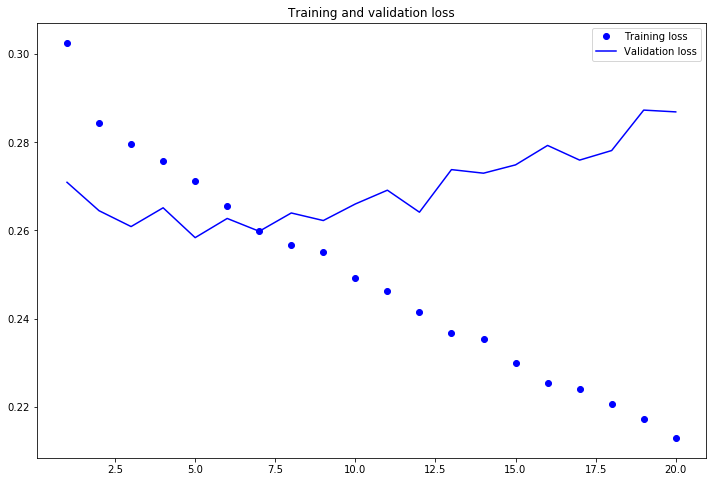

In [34]:
# Plotting the results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize = (12, 8))
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## GRU Basic Network with Dropout

In [35]:
from keras.layers import GRU

In [36]:
model = Sequential()
model.add(GRU(units = 32,
              dropout = 0.2,
              recurrent_dropout = 0.2,
              input_shape = (None, number_of_features)))
model.add(Dense(units = 1))
model.compile(optimizer=RMSprop(), loss = 'mae')

In [37]:
history = model.fit_generator(generator = train_gen,
                              steps_per_epoch = 500,
                              epochs = 40,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/40


314/500 [=================>............] - ETA: 11:13 - loss: 1.04 - ETA: 7:12 - loss: 0.9487 - ETA: 5:51 - loss: 0.928 - ETA: 5:11 - loss: 0.843 - ETA: 4:47 - loss: 0.816 - ETA: 4:30 - loss: 0.766 - ETA: 4:19 - loss: 0.733 - ETA: 4:10 - loss: 0.703 - ETA: 4:04 - loss: 0.677 - ETA: 3:58 - loss: 0.652 - ETA: 3:54 - loss: 0.636 - ETA: 3:49 - loss: 0.627 - ETA: 3:46 - loss: 0.612 - ETA: 3:43 - loss: 0.595 - ETA: 3:40 - loss: 0.582 - ETA: 3:38 - loss: 0.570 - ETA: 3:36 - loss: 0.562 - ETA: 3:34 - loss: 0.554 - ETA: 3:33 - loss: 0.547 - ETA: 3:31 - loss: 0.540 - ETA: 3:29 - loss: 0.533 - ETA: 3:28 - loss: 0.528 - ETA: 3:26 - loss: 0.521 - ETA: 3:25 - loss: 0.515 - ETA: 3:24 - loss: 0.508 - ETA: 3:23 - loss: 0.503 - ETA: 3:21 - loss: 0.498 - ETA: 3:20 - loss: 0.494 - ETA: 3:19 - loss: 0.490 - ETA: 3:18 - loss: 0.486 - ETA: 3:17 - loss: 0.482 - ETA: 3:16 - loss: 0.481 - ETA: 3:16 - loss: 0.478 - ETA: 3:15 - loss: 0.474 - ETA: 3:14 - loss: 0.473 - ETA: 3:13 - loss: 0.471 - ETA: 3:13 - loss: 0.

500/500 [==============================] - ETA: 1:13 - loss: 0.351 - ETA: 1:12 - loss: 0.351 - ETA: 1:12 - loss: 0.351 - ETA: 1:11 - loss: 0.351 - ETA: 1:11 - loss: 0.351 - ETA: 1:11 - loss: 0.351 - ETA: 1:10 - loss: 0.351 - ETA: 1:10 - loss: 0.350 - ETA: 1:09 - loss: 0.350 - ETA: 1:09 - loss: 0.350 - ETA: 1:09 - loss: 0.350 - ETA: 1:08 - loss: 0.350 - ETA: 1:08 - loss: 0.350 - ETA: 1:08 - loss: 0.350 - ETA: 1:07 - loss: 0.350 - ETA: 1:07 - loss: 0.350 - ETA: 1:06 - loss: 0.349 - ETA: 1:06 - loss: 0.349 - ETA: 1:06 - loss: 0.349 - ETA: 1:05 - loss: 0.349 - ETA: 1:05 - loss: 0.349 - ETA: 1:04 - loss: 0.349 - ETA: 1:04 - loss: 0.349 - ETA: 1:04 - loss: 0.349 - ETA: 1:03 - loss: 0.349 - ETA: 1:03 - loss: 0.349 - ETA: 1:02 - loss: 0.349 - ETA: 1:02 - loss: 0.349 - ETA: 1:02 - loss: 0.349 - ETA: 1:01 - loss: 0.349 - ETA: 1:01 - loss: 0.349 - ETA: 1:00 - loss: 0.349 - ETA: 1:00 - loss: 0.349 - ETA: 1:00 - loss: 0.348 - ETA: 59s - loss: 0.348 - ETA: 59s - loss: 0.34 - ETA: 58s - loss: 0.34 - 

314/500 [=================>............] - ETA: 3:16 - loss: 0.351 - ETA: 3:13 - loss: 0.355 - ETA: 3:14 - loss: 0.332 - ETA: 3:13 - loss: 0.336 - ETA: 3:22 - loss: 0.341 - ETA: 3:33 - loss: 0.333 - ETA: 3:31 - loss: 0.333 - ETA: 3:28 - loss: 0.333 - ETA: 3:26 - loss: 0.331 - ETA: 3:24 - loss: 0.329 - ETA: 3:22 - loss: 0.327 - ETA: 3:21 - loss: 0.327 - ETA: 3:20 - loss: 0.327 - ETA: 3:19 - loss: 0.326 - ETA: 3:18 - loss: 0.327 - ETA: 3:17 - loss: 0.326 - ETA: 3:16 - loss: 0.327 - ETA: 3:15 - loss: 0.324 - ETA: 3:14 - loss: 0.323 - ETA: 3:13 - loss: 0.324 - ETA: 3:13 - loss: 0.325 - ETA: 3:12 - loss: 0.326 - ETA: 3:11 - loss: 0.326 - ETA: 3:10 - loss: 0.325 - ETA: 3:10 - loss: 0.324 - ETA: 3:09 - loss: 0.325 - ETA: 3:09 - loss: 0.325 - ETA: 3:08 - loss: 0.325 - ETA: 3:08 - loss: 0.325 - ETA: 3:07 - loss: 0.325 - ETA: 3:07 - loss: 0.325 - ETA: 3:07 - loss: 0.324 - ETA: 3:06 - loss: 0.323 - ETA: 3:05 - loss: 0.324 - ETA: 3:05 - loss: 0.324 - ETA: 3:04 - loss: 0.323 - ETA: 3:04 - loss: 0.3

500/500 [==============================] - ETA: 1:13 - loss: 0.316 - ETA: 1:12 - loss: 0.316 - ETA: 1:12 - loss: 0.316 - ETA: 1:11 - loss: 0.316 - ETA: 1:11 - loss: 0.316 - ETA: 1:11 - loss: 0.316 - ETA: 1:10 - loss: 0.316 - ETA: 1:10 - loss: 0.316 - ETA: 1:10 - loss: 0.316 - ETA: 1:09 - loss: 0.316 - ETA: 1:09 - loss: 0.316 - ETA: 1:08 - loss: 0.316 - ETA: 1:08 - loss: 0.316 - ETA: 1:08 - loss: 0.316 - ETA: 1:07 - loss: 0.316 - ETA: 1:07 - loss: 0.316 - ETA: 1:06 - loss: 0.316 - ETA: 1:06 - loss: 0.316 - ETA: 1:06 - loss: 0.316 - ETA: 1:05 - loss: 0.316 - ETA: 1:05 - loss: 0.316 - ETA: 1:04 - loss: 0.316 - ETA: 1:04 - loss: 0.316 - ETA: 1:04 - loss: 0.315 - ETA: 1:03 - loss: 0.315 - ETA: 1:03 - loss: 0.315 - ETA: 1:02 - loss: 0.315 - ETA: 1:02 - loss: 0.315 - ETA: 1:02 - loss: 0.315 - ETA: 1:01 - loss: 0.315 - ETA: 1:01 - loss: 0.315 - ETA: 1:00 - loss: 0.315 - ETA: 1:00 - loss: 0.315 - ETA: 1:00 - loss: 0.315 - ETA: 59s - loss: 0.315 - ETA: 59s - loss: 0.31 - ETA: 58s - loss: 0.31 - 

314/500 [=================>............] - ETA: 3:12 - loss: 0.320 - ETA: 3:15 - loss: 0.317 - ETA: 3:15 - loss: 0.315 - ETA: 3:15 - loss: 0.308 - ETA: 3:14 - loss: 0.323 - ETA: 3:14 - loss: 0.318 - ETA: 3:13 - loss: 0.318 - ETA: 3:13 - loss: 0.321 - ETA: 3:12 - loss: 0.320 - ETA: 3:12 - loss: 0.318 - ETA: 3:12 - loss: 0.317 - ETA: 3:11 - loss: 0.315 - ETA: 3:11 - loss: 0.317 - ETA: 3:11 - loss: 0.320 - ETA: 3:10 - loss: 0.318 - ETA: 3:10 - loss: 0.318 - ETA: 3:09 - loss: 0.317 - ETA: 3:09 - loss: 0.316 - ETA: 3:09 - loss: 0.318 - ETA: 3:08 - loss: 0.317 - ETA: 3:08 - loss: 0.317 - ETA: 3:08 - loss: 0.317 - ETA: 3:08 - loss: 0.317 - ETA: 3:07 - loss: 0.318 - ETA: 3:07 - loss: 0.316 - ETA: 3:07 - loss: 0.315 - ETA: 3:07 - loss: 0.315 - ETA: 3:06 - loss: 0.314 - ETA: 3:06 - loss: 0.313 - ETA: 3:06 - loss: 0.313 - ETA: 3:05 - loss: 0.313 - ETA: 3:05 - loss: 0.312 - ETA: 3:04 - loss: 0.312 - ETA: 3:04 - loss: 0.312 - ETA: 3:04 - loss: 0.312 - ETA: 3:03 - loss: 0.312 - ETA: 3:03 - loss: 0.3

500/500 [==============================] - ETA: 1:13 - loss: 0.309 - ETA: 1:13 - loss: 0.309 - ETA: 1:13 - loss: 0.309 - ETA: 1:12 - loss: 0.309 - ETA: 1:12 - loss: 0.309 - ETA: 1:11 - loss: 0.309 - ETA: 1:11 - loss: 0.309 - ETA: 1:11 - loss: 0.309 - ETA: 1:10 - loss: 0.309 - ETA: 1:10 - loss: 0.309 - ETA: 1:09 - loss: 0.309 - ETA: 1:09 - loss: 0.309 - ETA: 1:09 - loss: 0.309 - ETA: 1:08 - loss: 0.309 - ETA: 1:08 - loss: 0.309 - ETA: 1:07 - loss: 0.309 - ETA: 1:07 - loss: 0.309 - ETA: 1:07 - loss: 0.309 - ETA: 1:06 - loss: 0.309 - ETA: 1:06 - loss: 0.309 - ETA: 1:05 - loss: 0.309 - ETA: 1:05 - loss: 0.309 - ETA: 1:05 - loss: 0.309 - ETA: 1:04 - loss: 0.309 - ETA: 1:04 - loss: 0.309 - ETA: 1:03 - loss: 0.309 - ETA: 1:03 - loss: 0.309 - ETA: 1:03 - loss: 0.309 - ETA: 1:02 - loss: 0.309 - ETA: 1:02 - loss: 0.309 - ETA: 1:01 - loss: 0.309 - ETA: 1:01 - loss: 0.309 - ETA: 1:01 - loss: 0.309 - ETA: 1:00 - loss: 0.309 - ETA: 1:00 - loss: 0.309 - ETA: 59s - loss: 0.309 - ETA: 59s - loss: 0.30 

314/500 [=================>............] - ETA: 3:16 - loss: 0.275 - ETA: 3:13 - loss: 0.283 - ETA: 3:14 - loss: 0.283 - ETA: 3:14 - loss: 0.300 - ETA: 3:14 - loss: 0.300 - ETA: 3:14 - loss: 0.304 - ETA: 3:14 - loss: 0.302 - ETA: 3:13 - loss: 0.303 - ETA: 3:12 - loss: 0.299 - ETA: 3:11 - loss: 0.301 - ETA: 3:11 - loss: 0.299 - ETA: 3:10 - loss: 0.297 - ETA: 3:10 - loss: 0.299 - ETA: 3:10 - loss: 0.300 - ETA: 3:09 - loss: 0.301 - ETA: 3:09 - loss: 0.302 - ETA: 3:08 - loss: 0.303 - ETA: 3:08 - loss: 0.303 - ETA: 3:07 - loss: 0.305 - ETA: 3:07 - loss: 0.305 - ETA: 3:07 - loss: 0.308 - ETA: 3:06 - loss: 0.309 - ETA: 3:06 - loss: 0.309 - ETA: 3:05 - loss: 0.309 - ETA: 3:05 - loss: 0.309 - ETA: 3:04 - loss: 0.308 - ETA: 3:04 - loss: 0.308 - ETA: 3:03 - loss: 0.308 - ETA: 3:03 - loss: 0.308 - ETA: 3:03 - loss: 0.309 - ETA: 3:02 - loss: 0.309 - ETA: 3:02 - loss: 0.311 - ETA: 3:01 - loss: 0.311 - ETA: 3:01 - loss: 0.311 - ETA: 3:01 - loss: 0.310 - ETA: 3:00 - loss: 0.310 - ETA: 3:00 - loss: 0.3

500/500 [==============================] - ETA: 1:12 - loss: 0.305 - ETA: 1:12 - loss: 0.305 - ETA: 1:11 - loss: 0.305 - ETA: 1:11 - loss: 0.305 - ETA: 1:10 - loss: 0.305 - ETA: 1:10 - loss: 0.305 - ETA: 1:10 - loss: 0.305 - ETA: 1:09 - loss: 0.305 - ETA: 1:09 - loss: 0.305 - ETA: 1:08 - loss: 0.305 - ETA: 1:08 - loss: 0.305 - ETA: 1:08 - loss: 0.304 - ETA: 1:07 - loss: 0.304 - ETA: 1:07 - loss: 0.304 - ETA: 1:07 - loss: 0.305 - ETA: 1:06 - loss: 0.305 - ETA: 1:06 - loss: 0.305 - ETA: 1:05 - loss: 0.305 - ETA: 1:05 - loss: 0.304 - ETA: 1:05 - loss: 0.304 - ETA: 1:04 - loss: 0.305 - ETA: 1:04 - loss: 0.305 - ETA: 1:03 - loss: 0.304 - ETA: 1:03 - loss: 0.305 - ETA: 1:03 - loss: 0.305 - ETA: 1:02 - loss: 0.305 - ETA: 1:02 - loss: 0.305 - ETA: 1:01 - loss: 0.305 - ETA: 1:01 - loss: 0.304 - ETA: 1:01 - loss: 0.304 - ETA: 1:00 - loss: 0.304 - ETA: 1:00 - loss: 0.304 - ETA: 59s - loss: 0.304 - ETA: 59s - loss: 0.30 - ETA: 59s - loss: 0.30 - ETA: 58s - loss: 0.30 - ETA: 58s - loss: 0.30 - ETA:

314/500 [=================>............] - ETA: 3:12 - loss: 0.304 - ETA: 3:12 - loss: 0.309 - ETA: 3:12 - loss: 0.308 - ETA: 3:12 - loss: 0.305 - ETA: 3:12 - loss: 0.302 - ETA: 3:13 - loss: 0.300 - ETA: 3:12 - loss: 0.297 - ETA: 3:11 - loss: 0.298 - ETA: 3:10 - loss: 0.301 - ETA: 3:10 - loss: 0.300 - ETA: 3:10 - loss: 0.302 - ETA: 3:09 - loss: 0.300 - ETA: 3:09 - loss: 0.297 - ETA: 3:09 - loss: 0.297 - ETA: 3:08 - loss: 0.298 - ETA: 3:08 - loss: 0.297 - ETA: 3:08 - loss: 0.298 - ETA: 3:07 - loss: 0.298 - ETA: 3:07 - loss: 0.296 - ETA: 3:06 - loss: 0.295 - ETA: 3:06 - loss: 0.297 - ETA: 3:06 - loss: 0.296 - ETA: 3:05 - loss: 0.296 - ETA: 3:05 - loss: 0.297 - ETA: 3:05 - loss: 0.297 - ETA: 3:04 - loss: 0.298 - ETA: 3:04 - loss: 0.298 - ETA: 3:04 - loss: 0.298 - ETA: 3:03 - loss: 0.296 - ETA: 3:03 - loss: 0.295 - ETA: 3:02 - loss: 0.297 - ETA: 3:02 - loss: 0.297 - ETA: 3:02 - loss: 0.297 - ETA: 3:01 - loss: 0.297 - ETA: 3:01 - loss: 0.298 - ETA: 3:01 - loss: 0.297 - ETA: 3:00 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.300 - ETA: 1:12 - loss: 0.300 - ETA: 1:11 - loss: 0.300 - ETA: 1:11 - loss: 0.300 - ETA: 1:11 - loss: 0.300 - ETA: 1:10 - loss: 0.300 - ETA: 1:10 - loss: 0.300 - ETA: 1:09 - loss: 0.300 - ETA: 1:09 - loss: 0.300 - ETA: 1:09 - loss: 0.300 - ETA: 1:08 - loss: 0.300 - ETA: 1:08 - loss: 0.300 - ETA: 1:07 - loss: 0.300 - ETA: 1:07 - loss: 0.300 - ETA: 1:07 - loss: 0.300 - ETA: 1:06 - loss: 0.300 - ETA: 1:06 - loss: 0.300 - ETA: 1:06 - loss: 0.300 - ETA: 1:05 - loss: 0.300 - ETA: 1:05 - loss: 0.300 - ETA: 1:04 - loss: 0.300 - ETA: 1:04 - loss: 0.300 - ETA: 1:04 - loss: 0.300 - ETA: 1:03 - loss: 0.300 - ETA: 1:03 - loss: 0.300 - ETA: 1:02 - loss: 0.300 - ETA: 1:02 - loss: 0.300 - ETA: 1:02 - loss: 0.300 - ETA: 1:01 - loss: 0.300 - ETA: 1:01 - loss: 0.300 - ETA: 1:00 - loss: 0.300 - ETA: 1:00 - loss: 0.300 - ETA: 1:00 - loss: 0.300 - ETA: 59s - loss: 0.300 - ETA: 59s - loss: 0.30 - ETA: 58s - loss: 0.30 - ETA: 58s - loss: 0.30 - ET

314/500 [=================>............] - ETA: 3:16 - loss: 0.313 - ETA: 3:13 - loss: 0.301 - ETA: 3:14 - loss: 0.301 - ETA: 3:15 - loss: 0.303 - ETA: 3:14 - loss: 0.297 - ETA: 3:13 - loss: 0.290 - ETA: 3:13 - loss: 0.292 - ETA: 3:12 - loss: 0.294 - ETA: 3:12 - loss: 0.292 - ETA: 3:12 - loss: 0.295 - ETA: 3:11 - loss: 0.294 - ETA: 3:11 - loss: 0.297 - ETA: 3:11 - loss: 0.295 - ETA: 3:10 - loss: 0.298 - ETA: 3:10 - loss: 0.300 - ETA: 3:09 - loss: 0.300 - ETA: 3:09 - loss: 0.300 - ETA: 3:09 - loss: 0.300 - ETA: 3:08 - loss: 0.299 - ETA: 3:08 - loss: 0.299 - ETA: 3:07 - loss: 0.300 - ETA: 3:07 - loss: 0.299 - ETA: 3:07 - loss: 0.301 - ETA: 3:06 - loss: 0.301 - ETA: 3:06 - loss: 0.300 - ETA: 3:05 - loss: 0.301 - ETA: 3:05 - loss: 0.302 - ETA: 3:05 - loss: 0.303 - ETA: 3:05 - loss: 0.302 - ETA: 3:04 - loss: 0.303 - ETA: 3:04 - loss: 0.302 - ETA: 3:03 - loss: 0.303 - ETA: 3:03 - loss: 0.303 - ETA: 3:03 - loss: 0.304 - ETA: 3:02 - loss: 0.305 - ETA: 3:02 - loss: 0.303 - ETA: 3:01 - loss: 0.3

500/500 [==============================] - ETA: 1:12 - loss: 0.298 - ETA: 1:12 - loss: 0.298 - ETA: 1:11 - loss: 0.298 - ETA: 1:11 - loss: 0.298 - ETA: 1:11 - loss: 0.298 - ETA: 1:10 - loss: 0.298 - ETA: 1:10 - loss: 0.298 - ETA: 1:10 - loss: 0.298 - ETA: 1:09 - loss: 0.298 - ETA: 1:09 - loss: 0.298 - ETA: 1:08 - loss: 0.298 - ETA: 1:08 - loss: 0.298 - ETA: 1:08 - loss: 0.298 - ETA: 1:07 - loss: 0.298 - ETA: 1:07 - loss: 0.298 - ETA: 1:06 - loss: 0.298 - ETA: 1:06 - loss: 0.298 - ETA: 1:06 - loss: 0.298 - ETA: 1:05 - loss: 0.298 - ETA: 1:05 - loss: 0.298 - ETA: 1:04 - loss: 0.298 - ETA: 1:04 - loss: 0.298 - ETA: 1:04 - loss: 0.298 - ETA: 1:03 - loss: 0.298 - ETA: 1:03 - loss: 0.298 - ETA: 1:02 - loss: 0.298 - ETA: 1:02 - loss: 0.298 - ETA: 1:02 - loss: 0.298 - ETA: 1:01 - loss: 0.298 - ETA: 1:01 - loss: 0.298 - ETA: 1:00 - loss: 0.298 - ETA: 1:00 - loss: 0.298 - ETA: 1:00 - loss: 0.298 - ETA: 59s - loss: 0.298 - ETA: 59s - loss: 0.29 - ETA: 59s - loss: 0.29 - ETA: 58s - loss: 0.29 - ET

314/500 [=================>............] - ETA: 3:18 - loss: 0.309 - ETA: 3:15 - loss: 0.295 - ETA: 3:15 - loss: 0.281 - ETA: 3:14 - loss: 0.286 - ETA: 3:14 - loss: 0.285 - ETA: 3:14 - loss: 0.293 - ETA: 3:14 - loss: 0.295 - ETA: 3:13 - loss: 0.297 - ETA: 3:12 - loss: 0.298 - ETA: 3:12 - loss: 0.297 - ETA: 3:12 - loss: 0.295 - ETA: 3:11 - loss: 0.294 - ETA: 3:10 - loss: 0.296 - ETA: 3:10 - loss: 0.294 - ETA: 3:09 - loss: 0.294 - ETA: 3:09 - loss: 0.296 - ETA: 3:08 - loss: 0.296 - ETA: 3:08 - loss: 0.295 - ETA: 3:08 - loss: 0.295 - ETA: 3:07 - loss: 0.296 - ETA: 3:07 - loss: 0.295 - ETA: 3:07 - loss: 0.297 - ETA: 3:06 - loss: 0.296 - ETA: 3:06 - loss: 0.297 - ETA: 3:05 - loss: 0.297 - ETA: 3:05 - loss: 0.297 - ETA: 3:05 - loss: 0.297 - ETA: 3:05 - loss: 0.296 - ETA: 3:04 - loss: 0.297 - ETA: 3:04 - loss: 0.296 - ETA: 3:03 - loss: 0.295 - ETA: 3:03 - loss: 0.295 - ETA: 3:02 - loss: 0.297 - ETA: 3:02 - loss: 0.296 - ETA: 3:01 - loss: 0.297 - ETA: 3:01 - loss: 0.297 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.295 - ETA: 1:12 - loss: 0.295 - ETA: 1:11 - loss: 0.295 - ETA: 1:11 - loss: 0.295 - ETA: 1:11 - loss: 0.295 - ETA: 1:10 - loss: 0.295 - ETA: 1:10 - loss: 0.295 - ETA: 1:09 - loss: 0.295 - ETA: 1:09 - loss: 0.295 - ETA: 1:09 - loss: 0.295 - ETA: 1:08 - loss: 0.295 - ETA: 1:08 - loss: 0.295 - ETA: 1:07 - loss: 0.295 - ETA: 1:07 - loss: 0.295 - ETA: 1:07 - loss: 0.295 - ETA: 1:06 - loss: 0.295 - ETA: 1:06 - loss: 0.295 - ETA: 1:05 - loss: 0.295 - ETA: 1:05 - loss: 0.295 - ETA: 1:05 - loss: 0.295 - ETA: 1:04 - loss: 0.295 - ETA: 1:04 - loss: 0.295 - ETA: 1:03 - loss: 0.295 - ETA: 1:03 - loss: 0.295 - ETA: 1:03 - loss: 0.295 - ETA: 1:02 - loss: 0.295 - ETA: 1:02 - loss: 0.295 - ETA: 1:01 - loss: 0.295 - ETA: 1:01 - loss: 0.295 - ETA: 1:01 - loss: 0.295 - ETA: 1:00 - loss: 0.295 - ETA: 1:00 - loss: 0.295 - ETA: 1:00 - loss: 0.295 - ETA: 59s - loss: 0.295 - ETA: 59s - loss: 0.29 - ETA: 58s - loss: 0.29 - ETA: 58s - loss: 0.29 - ET

314/500 [=================>............] - ETA: 3:14 - loss: 0.292 - ETA: 3:14 - loss: 0.280 - ETA: 3:15 - loss: 0.304 - ETA: 3:14 - loss: 0.301 - ETA: 3:14 - loss: 0.309 - ETA: 3:14 - loss: 0.306 - ETA: 3:14 - loss: 0.305 - ETA: 3:13 - loss: 0.306 - ETA: 3:13 - loss: 0.305 - ETA: 3:12 - loss: 0.300 - ETA: 3:12 - loss: 0.301 - ETA: 3:12 - loss: 0.299 - ETA: 3:11 - loss: 0.298 - ETA: 3:11 - loss: 0.295 - ETA: 3:10 - loss: 0.295 - ETA: 3:10 - loss: 0.295 - ETA: 3:09 - loss: 0.295 - ETA: 3:09 - loss: 0.293 - ETA: 3:09 - loss: 0.292 - ETA: 3:08 - loss: 0.292 - ETA: 3:08 - loss: 0.292 - ETA: 3:08 - loss: 0.292 - ETA: 3:07 - loss: 0.292 - ETA: 3:07 - loss: 0.291 - ETA: 3:06 - loss: 0.292 - ETA: 3:06 - loss: 0.293 - ETA: 3:05 - loss: 0.292 - ETA: 3:05 - loss: 0.292 - ETA: 3:05 - loss: 0.291 - ETA: 3:04 - loss: 0.291 - ETA: 3:04 - loss: 0.290 - ETA: 3:03 - loss: 0.290 - ETA: 3:03 - loss: 0.291 - ETA: 3:03 - loss: 0.291 - ETA: 3:02 - loss: 0.291 - ETA: 3:03 - loss: 0.292 - ETA: 3:02 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.292 - ETA: 1:12 - loss: 0.292 - ETA: 1:11 - loss: 0.292 - ETA: 1:11 - loss: 0.292 - ETA: 1:11 - loss: 0.292 - ETA: 1:10 - loss: 0.292 - ETA: 1:10 - loss: 0.292 - ETA: 1:09 - loss: 0.293 - ETA: 1:09 - loss: 0.292 - ETA: 1:09 - loss: 0.292 - ETA: 1:08 - loss: 0.292 - ETA: 1:08 - loss: 0.292 - ETA: 1:07 - loss: 0.292 - ETA: 1:07 - loss: 0.292 - ETA: 1:07 - loss: 0.292 - ETA: 1:06 - loss: 0.292 - ETA: 1:06 - loss: 0.292 - ETA: 1:06 - loss: 0.292 - ETA: 1:05 - loss: 0.292 - ETA: 1:05 - loss: 0.292 - ETA: 1:04 - loss: 0.292 - ETA: 1:04 - loss: 0.292 - ETA: 1:04 - loss: 0.292 - ETA: 1:03 - loss: 0.292 - ETA: 1:03 - loss: 0.292 - ETA: 1:02 - loss: 0.292 - ETA: 1:02 - loss: 0.292 - ETA: 1:02 - loss: 0.292 - ETA: 1:01 - loss: 0.292 - ETA: 1:01 - loss: 0.292 - ETA: 1:00 - loss: 0.292 - ETA: 1:00 - loss: 0.292 - ETA: 1:00 - loss: 0.292 - ETA: 59s - loss: 0.293 - ETA: 59s - loss: 0.29 - ETA: 58s - loss: 0.29 - ETA: 58s - loss: 0.29 - ET

314/500 [=================>............] - ETA: 3:16 - loss: 0.289 - ETA: 3:15 - loss: 0.291 - ETA: 3:16 - loss: 0.293 - ETA: 3:15 - loss: 0.288 - ETA: 3:15 - loss: 0.291 - ETA: 3:14 - loss: 0.294 - ETA: 3:14 - loss: 0.296 - ETA: 3:13 - loss: 0.298 - ETA: 3:13 - loss: 0.300 - ETA: 3:12 - loss: 0.298 - ETA: 3:11 - loss: 0.296 - ETA: 3:11 - loss: 0.297 - ETA: 3:10 - loss: 0.298 - ETA: 3:10 - loss: 0.297 - ETA: 3:09 - loss: 0.297 - ETA: 3:09 - loss: 0.295 - ETA: 3:09 - loss: 0.296 - ETA: 3:08 - loss: 0.298 - ETA: 3:08 - loss: 0.297 - ETA: 3:07 - loss: 0.297 - ETA: 3:07 - loss: 0.297 - ETA: 3:07 - loss: 0.298 - ETA: 3:06 - loss: 0.298 - ETA: 3:07 - loss: 0.297 - ETA: 3:07 - loss: 0.297 - ETA: 3:06 - loss: 0.297 - ETA: 3:06 - loss: 0.298 - ETA: 3:05 - loss: 0.298 - ETA: 3:05 - loss: 0.298 - ETA: 3:04 - loss: 0.297 - ETA: 3:04 - loss: 0.296 - ETA: 3:04 - loss: 0.296 - ETA: 3:03 - loss: 0.297 - ETA: 3:03 - loss: 0.297 - ETA: 3:02 - loss: 0.296 - ETA: 3:02 - loss: 0.297 - ETA: 3:02 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.295 - ETA: 1:12 - loss: 0.295 - ETA: 1:12 - loss: 0.295 - ETA: 1:11 - loss: 0.295 - ETA: 1:11 - loss: 0.295 - ETA: 1:10 - loss: 0.295 - ETA: 1:10 - loss: 0.295 - ETA: 1:10 - loss: 0.295 - ETA: 1:09 - loss: 0.295 - ETA: 1:09 - loss: 0.295 - ETA: 1:08 - loss: 0.295 - ETA: 1:08 - loss: 0.295 - ETA: 1:08 - loss: 0.295 - ETA: 1:07 - loss: 0.295 - ETA: 1:07 - loss: 0.295 - ETA: 1:06 - loss: 0.295 - ETA: 1:06 - loss: 0.295 - ETA: 1:06 - loss: 0.295 - ETA: 1:05 - loss: 0.295 - ETA: 1:05 - loss: 0.295 - ETA: 1:04 - loss: 0.295 - ETA: 1:04 - loss: 0.295 - ETA: 1:04 - loss: 0.295 - ETA: 1:03 - loss: 0.295 - ETA: 1:03 - loss: 0.295 - ETA: 1:03 - loss: 0.295 - ETA: 1:02 - loss: 0.295 - ETA: 1:02 - loss: 0.294 - ETA: 1:01 - loss: 0.294 - ETA: 1:01 - loss: 0.295 - ETA: 1:01 - loss: 0.295 - ETA: 1:00 - loss: 0.295 - ETA: 1:00 - loss: 0.294 - ETA: 59s - loss: 0.295 - ETA: 59s - loss: 0.29 - ETA: 59s - loss: 0.29 - ETA: 58s - loss: 0.29 - ET

314/500 [=================>............] - ETA: 3:10 - loss: 0.295 - ETA: 3:11 - loss: 0.295 - ETA: 3:11 - loss: 0.295 - ETA: 3:13 - loss: 0.291 - ETA: 3:14 - loss: 0.293 - ETA: 3:13 - loss: 0.294 - ETA: 3:13 - loss: 0.291 - ETA: 3:13 - loss: 0.294 - ETA: 3:12 - loss: 0.292 - ETA: 3:12 - loss: 0.290 - ETA: 3:11 - loss: 0.289 - ETA: 3:10 - loss: 0.290 - ETA: 3:10 - loss: 0.291 - ETA: 3:10 - loss: 0.290 - ETA: 3:09 - loss: 0.290 - ETA: 3:09 - loss: 0.290 - ETA: 3:09 - loss: 0.291 - ETA: 3:08 - loss: 0.294 - ETA: 3:08 - loss: 0.294 - ETA: 3:07 - loss: 0.293 - ETA: 3:07 - loss: 0.293 - ETA: 3:07 - loss: 0.291 - ETA: 3:07 - loss: 0.293 - ETA: 3:06 - loss: 0.292 - ETA: 3:06 - loss: 0.292 - ETA: 3:05 - loss: 0.292 - ETA: 3:05 - loss: 0.293 - ETA: 3:04 - loss: 0.293 - ETA: 3:04 - loss: 0.293 - ETA: 3:03 - loss: 0.294 - ETA: 3:03 - loss: 0.294 - ETA: 3:03 - loss: 0.294 - ETA: 3:02 - loss: 0.293 - ETA: 3:02 - loss: 0.294 - ETA: 3:01 - loss: 0.295 - ETA: 3:01 - loss: 0.294 - ETA: 3:00 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.290 - ETA: 1:11 - loss: 0.290 - ETA: 1:11 - loss: 0.290 - ETA: 1:11 - loss: 0.290 - ETA: 1:10 - loss: 0.290 - ETA: 1:10 - loss: 0.290 - ETA: 1:10 - loss: 0.290 - ETA: 1:09 - loss: 0.290 - ETA: 1:09 - loss: 0.290 - ETA: 1:08 - loss: 0.290 - ETA: 1:08 - loss: 0.290 - ETA: 1:08 - loss: 0.290 - ETA: 1:07 - loss: 0.290 - ETA: 1:07 - loss: 0.290 - ETA: 1:06 - loss: 0.290 - ETA: 1:06 - loss: 0.290 - ETA: 1:06 - loss: 0.290 - ETA: 1:05 - loss: 0.290 - ETA: 1:05 - loss: 0.290 - ETA: 1:04 - loss: 0.290 - ETA: 1:04 - loss: 0.290 - ETA: 1:04 - loss: 0.290 - ETA: 1:03 - loss: 0.290 - ETA: 1:03 - loss: 0.290 - ETA: 1:02 - loss: 0.290 - ETA: 1:02 - loss: 0.290 - ETA: 1:02 - loss: 0.290 - ETA: 1:01 - loss: 0.290 - ETA: 1:01 - loss: 0.290 - ETA: 1:01 - loss: 0.290 - ETA: 1:00 - loss: 0.290 - ETA: 1:00 - loss: 0.290 - ETA: 59s - loss: 0.290 - ETA: 59s - loss: 0.29 - ETA: 59s - loss: 0.29 - ETA: 58s - loss: 0.29 - ETA: 58s - loss: 0.29 - ETA:

314/500 [=================>............] - ETA: 3:14 - loss: 0.265 - ETA: 3:15 - loss: 0.263 - ETA: 3:15 - loss: 0.274 - ETA: 3:14 - loss: 0.277 - ETA: 3:14 - loss: 0.276 - ETA: 3:14 - loss: 0.274 - ETA: 3:14 - loss: 0.275 - ETA: 3:13 - loss: 0.274 - ETA: 3:13 - loss: 0.278 - ETA: 3:13 - loss: 0.284 - ETA: 3:13 - loss: 0.287 - ETA: 3:12 - loss: 0.287 - ETA: 3:11 - loss: 0.286 - ETA: 3:11 - loss: 0.287 - ETA: 3:11 - loss: 0.288 - ETA: 3:10 - loss: 0.287 - ETA: 3:09 - loss: 0.288 - ETA: 3:09 - loss: 0.288 - ETA: 3:09 - loss: 0.289 - ETA: 3:08 - loss: 0.287 - ETA: 3:08 - loss: 0.288 - ETA: 3:08 - loss: 0.288 - ETA: 3:08 - loss: 0.288 - ETA: 3:07 - loss: 0.287 - ETA: 3:07 - loss: 0.288 - ETA: 3:06 - loss: 0.287 - ETA: 3:06 - loss: 0.286 - ETA: 3:06 - loss: 0.285 - ETA: 3:05 - loss: 0.286 - ETA: 3:05 - loss: 0.286 - ETA: 3:05 - loss: 0.286 - ETA: 3:04 - loss: 0.287 - ETA: 3:04 - loss: 0.287 - ETA: 3:04 - loss: 0.286 - ETA: 3:03 - loss: 0.285 - ETA: 3:03 - loss: 0.285 - ETA: 3:02 - loss: 0.2

500/500 [==============================] - ETA: 1:13 - loss: 0.289 - ETA: 1:12 - loss: 0.289 - ETA: 1:12 - loss: 0.289 - ETA: 1:11 - loss: 0.289 - ETA: 1:11 - loss: 0.289 - ETA: 1:11 - loss: 0.289 - ETA: 1:10 - loss: 0.289 - ETA: 1:10 - loss: 0.289 - ETA: 1:09 - loss: 0.289 - ETA: 1:09 - loss: 0.289 - ETA: 1:09 - loss: 0.289 - ETA: 1:08 - loss: 0.289 - ETA: 1:08 - loss: 0.289 - ETA: 1:08 - loss: 0.289 - ETA: 1:07 - loss: 0.289 - ETA: 1:07 - loss: 0.289 - ETA: 1:06 - loss: 0.289 - ETA: 1:06 - loss: 0.289 - ETA: 1:06 - loss: 0.289 - ETA: 1:05 - loss: 0.289 - ETA: 1:05 - loss: 0.289 - ETA: 1:04 - loss: 0.289 - ETA: 1:04 - loss: 0.289 - ETA: 1:04 - loss: 0.289 - ETA: 1:03 - loss: 0.289 - ETA: 1:03 - loss: 0.289 - ETA: 1:02 - loss: 0.289 - ETA: 1:02 - loss: 0.289 - ETA: 1:02 - loss: 0.289 - ETA: 1:01 - loss: 0.289 - ETA: 1:01 - loss: 0.289 - ETA: 1:00 - loss: 0.289 - ETA: 1:00 - loss: 0.289 - ETA: 1:00 - loss: 0.289 - ETA: 59s - loss: 0.289 - ETA: 59s - loss: 0.28 - ETA: 58s - loss: 0.28 - 

314/500 [=================>............] - ETA: 3:15 - loss: 0.283 - ETA: 3:13 - loss: 0.301 - ETA: 3:12 - loss: 0.293 - ETA: 3:11 - loss: 0.289 - ETA: 3:10 - loss: 0.283 - ETA: 3:11 - loss: 0.284 - ETA: 3:11 - loss: 0.288 - ETA: 3:11 - loss: 0.288 - ETA: 3:11 - loss: 0.291 - ETA: 3:11 - loss: 0.289 - ETA: 3:10 - loss: 0.288 - ETA: 3:09 - loss: 0.287 - ETA: 3:09 - loss: 0.290 - ETA: 3:08 - loss: 0.290 - ETA: 3:08 - loss: 0.288 - ETA: 3:08 - loss: 0.288 - ETA: 3:08 - loss: 0.289 - ETA: 3:07 - loss: 0.289 - ETA: 3:07 - loss: 0.290 - ETA: 3:07 - loss: 0.288 - ETA: 3:06 - loss: 0.288 - ETA: 3:06 - loss: 0.290 - ETA: 3:06 - loss: 0.290 - ETA: 3:05 - loss: 0.289 - ETA: 3:05 - loss: 0.288 - ETA: 3:04 - loss: 0.288 - ETA: 3:04 - loss: 0.289 - ETA: 3:04 - loss: 0.289 - ETA: 3:04 - loss: 0.290 - ETA: 3:03 - loss: 0.291 - ETA: 3:03 - loss: 0.290 - ETA: 3:02 - loss: 0.290 - ETA: 3:02 - loss: 0.290 - ETA: 3:02 - loss: 0.290 - ETA: 3:03 - loss: 0.290 - ETA: 3:02 - loss: 0.290 - ETA: 3:02 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.287 - ETA: 1:12 - loss: 0.287 - ETA: 1:11 - loss: 0.287 - ETA: 1:11 - loss: 0.287 - ETA: 1:11 - loss: 0.287 - ETA: 1:10 - loss: 0.287 - ETA: 1:10 - loss: 0.287 - ETA: 1:09 - loss: 0.287 - ETA: 1:09 - loss: 0.286 - ETA: 1:09 - loss: 0.287 - ETA: 1:08 - loss: 0.286 - ETA: 1:08 - loss: 0.286 - ETA: 1:07 - loss: 0.286 - ETA: 1:07 - loss: 0.286 - ETA: 1:07 - loss: 0.286 - ETA: 1:06 - loss: 0.287 - ETA: 1:06 - loss: 0.287 - ETA: 1:06 - loss: 0.287 - ETA: 1:05 - loss: 0.287 - ETA: 1:05 - loss: 0.287 - ETA: 1:04 - loss: 0.287 - ETA: 1:04 - loss: 0.287 - ETA: 1:04 - loss: 0.287 - ETA: 1:03 - loss: 0.287 - ETA: 1:03 - loss: 0.287 - ETA: 1:02 - loss: 0.287 - ETA: 1:02 - loss: 0.287 - ETA: 1:02 - loss: 0.287 - ETA: 1:01 - loss: 0.287 - ETA: 1:01 - loss: 0.287 - ETA: 1:00 - loss: 0.287 - ETA: 1:00 - loss: 0.287 - ETA: 1:00 - loss: 0.287 - ETA: 59s - loss: 0.287 - ETA: 59s - loss: 0.28 - ETA: 58s - loss: 0.28 - ETA: 58s - loss: 0.28 - ET

314/500 [=================>............] - ETA: 3:15 - loss: 0.290 - ETA: 3:14 - loss: 0.295 - ETA: 3:14 - loss: 0.294 - ETA: 3:15 - loss: 0.298 - ETA: 3:13 - loss: 0.293 - ETA: 3:13 - loss: 0.292 - ETA: 3:13 - loss: 0.293 - ETA: 3:12 - loss: 0.290 - ETA: 3:11 - loss: 0.288 - ETA: 3:11 - loss: 0.284 - ETA: 3:14 - loss: 0.285 - ETA: 3:17 - loss: 0.289 - ETA: 3:16 - loss: 0.288 - ETA: 3:15 - loss: 0.287 - ETA: 3:14 - loss: 0.286 - ETA: 3:14 - loss: 0.284 - ETA: 3:13 - loss: 0.286 - ETA: 3:13 - loss: 0.285 - ETA: 3:12 - loss: 0.284 - ETA: 3:12 - loss: 0.284 - ETA: 3:11 - loss: 0.285 - ETA: 3:11 - loss: 0.285 - ETA: 3:10 - loss: 0.285 - ETA: 3:10 - loss: 0.284 - ETA: 3:09 - loss: 0.284 - ETA: 3:09 - loss: 0.285 - ETA: 3:08 - loss: 0.284 - ETA: 3:08 - loss: 0.283 - ETA: 3:07 - loss: 0.282 - ETA: 3:06 - loss: 0.282 - ETA: 3:06 - loss: 0.282 - ETA: 3:05 - loss: 0.282 - ETA: 3:05 - loss: 0.281 - ETA: 3:04 - loss: 0.281 - ETA: 3:04 - loss: 0.282 - ETA: 3:03 - loss: 0.281 - ETA: 3:03 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.284 - ETA: 1:12 - loss: 0.284 - ETA: 1:12 - loss: 0.284 - ETA: 1:11 - loss: 0.284 - ETA: 1:11 - loss: 0.284 - ETA: 1:10 - loss: 0.284 - ETA: 1:10 - loss: 0.284 - ETA: 1:10 - loss: 0.284 - ETA: 1:09 - loss: 0.284 - ETA: 1:09 - loss: 0.284 - ETA: 1:08 - loss: 0.284 - ETA: 1:08 - loss: 0.284 - ETA: 1:08 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:06 - loss: 0.284 - ETA: 1:06 - loss: 0.284 - ETA: 1:06 - loss: 0.284 - ETA: 1:05 - loss: 0.284 - ETA: 1:05 - loss: 0.284 - ETA: 1:04 - loss: 0.284 - ETA: 1:04 - loss: 0.284 - ETA: 1:04 - loss: 0.284 - ETA: 1:03 - loss: 0.284 - ETA: 1:03 - loss: 0.284 - ETA: 1:02 - loss: 0.284 - ETA: 1:02 - loss: 0.284 - ETA: 1:02 - loss: 0.284 - ETA: 1:01 - loss: 0.284 - ETA: 1:01 - loss: 0.284 - ETA: 1:00 - loss: 0.284 - ETA: 1:00 - loss: 0.284 - ETA: 1:00 - loss: 0.284 - ETA: 59s - loss: 0.284 - ETA: 59s - loss: 0.28 - ETA: 58s - loss: 0.28 - ETA: 58s - loss: 0.28 - ET

314/500 [=================>............] - ETA: 3:13 - loss: 0.259 - ETA: 3:13 - loss: 0.270 - ETA: 3:14 - loss: 0.284 - ETA: 3:14 - loss: 0.283 - ETA: 3:14 - loss: 0.284 - ETA: 3:13 - loss: 0.287 - ETA: 3:13 - loss: 0.288 - ETA: 3:13 - loss: 0.293 - ETA: 3:12 - loss: 0.292 - ETA: 3:12 - loss: 0.291 - ETA: 3:12 - loss: 0.290 - ETA: 3:12 - loss: 0.290 - ETA: 3:11 - loss: 0.288 - ETA: 3:11 - loss: 0.286 - ETA: 3:11 - loss: 0.289 - ETA: 3:10 - loss: 0.289 - ETA: 3:09 - loss: 0.289 - ETA: 3:09 - loss: 0.289 - ETA: 3:08 - loss: 0.290 - ETA: 3:08 - loss: 0.289 - ETA: 3:08 - loss: 0.289 - ETA: 3:07 - loss: 0.289 - ETA: 3:07 - loss: 0.289 - ETA: 3:06 - loss: 0.288 - ETA: 3:06 - loss: 0.289 - ETA: 3:06 - loss: 0.288 - ETA: 3:05 - loss: 0.287 - ETA: 3:05 - loss: 0.287 - ETA: 3:04 - loss: 0.288 - ETA: 3:04 - loss: 0.288 - ETA: 3:03 - loss: 0.286 - ETA: 3:03 - loss: 0.287 - ETA: 3:02 - loss: 0.288 - ETA: 3:02 - loss: 0.287 - ETA: 3:02 - loss: 0.287 - ETA: 3:01 - loss: 0.288 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.285 - ETA: 1:12 - loss: 0.284 - ETA: 1:11 - loss: 0.284 - ETA: 1:11 - loss: 0.284 - ETA: 1:11 - loss: 0.284 - ETA: 1:10 - loss: 0.284 - ETA: 1:10 - loss: 0.284 - ETA: 1:09 - loss: 0.284 - ETA: 1:09 - loss: 0.284 - ETA: 1:09 - loss: 0.284 - ETA: 1:08 - loss: 0.284 - ETA: 1:08 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:07 - loss: 0.284 - ETA: 1:06 - loss: 0.284 - ETA: 1:06 - loss: 0.284 - ETA: 1:05 - loss: 0.284 - ETA: 1:05 - loss: 0.285 - ETA: 1:05 - loss: 0.285 - ETA: 1:04 - loss: 0.285 - ETA: 1:04 - loss: 0.284 - ETA: 1:04 - loss: 0.284 - ETA: 1:03 - loss: 0.284 - ETA: 1:03 - loss: 0.284 - ETA: 1:02 - loss: 0.284 - ETA: 1:02 - loss: 0.284 - ETA: 1:02 - loss: 0.284 - ETA: 1:01 - loss: 0.284 - ETA: 1:01 - loss: 0.284 - ETA: 1:00 - loss: 0.284 - ETA: 1:00 - loss: 0.284 - ETA: 1:00 - loss: 0.284 - ETA: 59s - loss: 0.285 - ETA: 59s - loss: 0.28 - ETA: 58s - loss: 0.28 - ETA: 58s - loss: 0.28 - ET

314/500 [=================>............] - ETA: 3:16 - loss: 0.277 - ETA: 3:15 - loss: 0.289 - ETA: 3:14 - loss: 0.276 - ETA: 3:13 - loss: 0.281 - ETA: 3:13 - loss: 0.283 - ETA: 3:13 - loss: 0.281 - ETA: 3:13 - loss: 0.278 - ETA: 3:12 - loss: 0.279 - ETA: 3:12 - loss: 0.281 - ETA: 3:12 - loss: 0.281 - ETA: 3:11 - loss: 0.281 - ETA: 3:11 - loss: 0.281 - ETA: 3:10 - loss: 0.283 - ETA: 3:10 - loss: 0.282 - ETA: 3:10 - loss: 0.282 - ETA: 3:09 - loss: 0.281 - ETA: 3:09 - loss: 0.279 - ETA: 3:08 - loss: 0.279 - ETA: 3:08 - loss: 0.279 - ETA: 3:08 - loss: 0.279 - ETA: 3:08 - loss: 0.278 - ETA: 3:07 - loss: 0.280 - ETA: 3:07 - loss: 0.281 - ETA: 3:06 - loss: 0.281 - ETA: 3:06 - loss: 0.280 - ETA: 3:05 - loss: 0.281 - ETA: 3:05 - loss: 0.282 - ETA: 3:05 - loss: 0.283 - ETA: 3:04 - loss: 0.282 - ETA: 3:04 - loss: 0.281 - ETA: 3:03 - loss: 0.282 - ETA: 3:03 - loss: 0.282 - ETA: 3:03 - loss: 0.282 - ETA: 3:02 - loss: 0.283 - ETA: 3:02 - loss: 0.284 - ETA: 3:02 - loss: 0.284 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.281 - ETA: 1:12 - loss: 0.281 - ETA: 1:12 - loss: 0.281 - ETA: 1:11 - loss: 0.281 - ETA: 1:11 - loss: 0.281 - ETA: 1:10 - loss: 0.281 - ETA: 1:10 - loss: 0.281 - ETA: 1:10 - loss: 0.281 - ETA: 1:09 - loss: 0.281 - ETA: 1:09 - loss: 0.281 - ETA: 1:08 - loss: 0.281 - ETA: 1:08 - loss: 0.281 - ETA: 1:08 - loss: 0.281 - ETA: 1:07 - loss: 0.281 - ETA: 1:07 - loss: 0.281 - ETA: 1:06 - loss: 0.281 - ETA: 1:06 - loss: 0.281 - ETA: 1:06 - loss: 0.281 - ETA: 1:05 - loss: 0.281 - ETA: 1:05 - loss: 0.281 - ETA: 1:04 - loss: 0.281 - ETA: 1:04 - loss: 0.281 - ETA: 1:04 - loss: 0.281 - ETA: 1:03 - loss: 0.281 - ETA: 1:03 - loss: 0.281 - ETA: 1:03 - loss: 0.281 - ETA: 1:02 - loss: 0.281 - ETA: 1:02 - loss: 0.281 - ETA: 1:01 - loss: 0.281 - ETA: 1:01 - loss: 0.281 - ETA: 1:01 - loss: 0.281 - ETA: 1:00 - loss: 0.281 - ETA: 1:00 - loss: 0.281 - ETA: 59s - loss: 0.281 - ETA: 59s - loss: 0.28 - ETA: 59s - loss: 0.28 - ETA: 58s - loss: 0.28 - ET

314/500 [=================>............] - ETA: 3:10 - loss: 0.270 - ETA: 3:12 - loss: 0.272 - ETA: 3:13 - loss: 0.282 - ETA: 3:13 - loss: 0.282 - ETA: 3:12 - loss: 0.283 - ETA: 3:12 - loss: 0.290 - ETA: 3:12 - loss: 0.284 - ETA: 3:11 - loss: 0.284 - ETA: 3:12 - loss: 0.282 - ETA: 3:11 - loss: 0.281 - ETA: 3:11 - loss: 0.284 - ETA: 3:11 - loss: 0.285 - ETA: 3:10 - loss: 0.285 - ETA: 3:10 - loss: 0.286 - ETA: 3:10 - loss: 0.285 - ETA: 3:09 - loss: 0.285 - ETA: 3:09 - loss: 0.287 - ETA: 3:08 - loss: 0.287 - ETA: 3:08 - loss: 0.289 - ETA: 3:07 - loss: 0.290 - ETA: 3:07 - loss: 0.289 - ETA: 3:07 - loss: 0.288 - ETA: 3:06 - loss: 0.288 - ETA: 3:06 - loss: 0.289 - ETA: 3:06 - loss: 0.290 - ETA: 3:05 - loss: 0.290 - ETA: 3:05 - loss: 0.291 - ETA: 3:05 - loss: 0.291 - ETA: 3:04 - loss: 0.290 - ETA: 3:04 - loss: 0.290 - ETA: 3:03 - loss: 0.289 - ETA: 3:03 - loss: 0.289 - ETA: 3:03 - loss: 0.289 - ETA: 3:02 - loss: 0.288 - ETA: 3:02 - loss: 0.288 - ETA: 3:01 - loss: 0.288 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.282 - ETA: 1:12 - loss: 0.282 - ETA: 1:12 - loss: 0.282 - ETA: 1:11 - loss: 0.282 - ETA: 1:11 - loss: 0.282 - ETA: 1:10 - loss: 0.282 - ETA: 1:10 - loss: 0.282 - ETA: 1:10 - loss: 0.282 - ETA: 1:09 - loss: 0.282 - ETA: 1:09 - loss: 0.282 - ETA: 1:08 - loss: 0.282 - ETA: 1:08 - loss: 0.282 - ETA: 1:08 - loss: 0.282 - ETA: 1:07 - loss: 0.282 - ETA: 1:07 - loss: 0.282 - ETA: 1:06 - loss: 0.282 - ETA: 1:06 - loss: 0.282 - ETA: 1:06 - loss: 0.282 - ETA: 1:05 - loss: 0.282 - ETA: 1:05 - loss: 0.282 - ETA: 1:04 - loss: 0.282 - ETA: 1:04 - loss: 0.282 - ETA: 1:04 - loss: 0.282 - ETA: 1:03 - loss: 0.282 - ETA: 1:03 - loss: 0.282 - ETA: 1:02 - loss: 0.282 - ETA: 1:02 - loss: 0.282 - ETA: 1:02 - loss: 0.282 - ETA: 1:01 - loss: 0.282 - ETA: 1:01 - loss: 0.282 - ETA: 1:01 - loss: 0.282 - ETA: 1:00 - loss: 0.282 - ETA: 1:00 - loss: 0.282 - ETA: 59s - loss: 0.282 - ETA: 59s - loss: 0.28 - ETA: 59s - loss: 0.28 - ETA: 58s - loss: 0.28 - ET

314/500 [=================>............] - ETA: 3:12 - loss: 0.290 - ETA: 3:12 - loss: 0.290 - ETA: 3:12 - loss: 0.282 - ETA: 3:12 - loss: 0.282 - ETA: 3:13 - loss: 0.288 - ETA: 3:14 - loss: 0.287 - ETA: 3:14 - loss: 0.288 - ETA: 3:13 - loss: 0.283 - ETA: 3:13 - loss: 0.283 - ETA: 3:12 - loss: 0.280 - ETA: 3:12 - loss: 0.278 - ETA: 3:11 - loss: 0.277 - ETA: 3:11 - loss: 0.276 - ETA: 3:11 - loss: 0.277 - ETA: 3:10 - loss: 0.279 - ETA: 3:10 - loss: 0.277 - ETA: 3:09 - loss: 0.277 - ETA: 3:09 - loss: 0.279 - ETA: 3:08 - loss: 0.279 - ETA: 3:08 - loss: 0.279 - ETA: 3:07 - loss: 0.279 - ETA: 3:07 - loss: 0.279 - ETA: 3:07 - loss: 0.279 - ETA: 3:06 - loss: 0.278 - ETA: 3:06 - loss: 0.277 - ETA: 3:05 - loss: 0.276 - ETA: 3:05 - loss: 0.277 - ETA: 3:04 - loss: 0.277 - ETA: 3:04 - loss: 0.277 - ETA: 3:04 - loss: 0.279 - ETA: 3:03 - loss: 0.279 - ETA: 3:03 - loss: 0.279 - ETA: 3:03 - loss: 0.280 - ETA: 3:02 - loss: 0.281 - ETA: 3:02 - loss: 0.280 - ETA: 3:01 - loss: 0.281 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.280 - ETA: 1:12 - loss: 0.280 - ETA: 1:12 - loss: 0.280 - ETA: 1:11 - loss: 0.280 - ETA: 1:11 - loss: 0.280 - ETA: 1:10 - loss: 0.280 - ETA: 1:10 - loss: 0.280 - ETA: 1:10 - loss: 0.280 - ETA: 1:09 - loss: 0.280 - ETA: 1:09 - loss: 0.280 - ETA: 1:08 - loss: 0.280 - ETA: 1:08 - loss: 0.280 - ETA: 1:08 - loss: 0.280 - ETA: 1:07 - loss: 0.280 - ETA: 1:07 - loss: 0.280 - ETA: 1:06 - loss: 0.280 - ETA: 1:06 - loss: 0.280 - ETA: 1:06 - loss: 0.280 - ETA: 1:05 - loss: 0.280 - ETA: 1:05 - loss: 0.280 - ETA: 1:05 - loss: 0.280 - ETA: 1:04 - loss: 0.280 - ETA: 1:04 - loss: 0.279 - ETA: 1:03 - loss: 0.280 - ETA: 1:03 - loss: 0.279 - ETA: 1:03 - loss: 0.279 - ETA: 1:02 - loss: 0.279 - ETA: 1:02 - loss: 0.279 - ETA: 1:01 - loss: 0.279 - ETA: 1:01 - loss: 0.279 - ETA: 1:01 - loss: 0.279 - ETA: 1:00 - loss: 0.279 - ETA: 1:00 - loss: 0.279 - ETA: 59s - loss: 0.279 - ETA: 59s - loss: 0.27 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - ET

314/500 [=================>............] - ETA: 3:16 - loss: 0.282 - ETA: 3:15 - loss: 0.278 - ETA: 3:15 - loss: 0.283 - ETA: 3:15 - loss: 0.274 - ETA: 3:15 - loss: 0.276 - ETA: 3:14 - loss: 0.275 - ETA: 3:14 - loss: 0.274 - ETA: 3:14 - loss: 0.273 - ETA: 3:14 - loss: 0.272 - ETA: 3:14 - loss: 0.269 - ETA: 3:13 - loss: 0.270 - ETA: 3:12 - loss: 0.268 - ETA: 3:12 - loss: 0.271 - ETA: 3:11 - loss: 0.274 - ETA: 3:11 - loss: 0.272 - ETA: 3:11 - loss: 0.271 - ETA: 3:11 - loss: 0.270 - ETA: 3:10 - loss: 0.270 - ETA: 3:10 - loss: 0.272 - ETA: 3:10 - loss: 0.272 - ETA: 3:09 - loss: 0.274 - ETA: 3:09 - loss: 0.273 - ETA: 3:09 - loss: 0.273 - ETA: 3:08 - loss: 0.273 - ETA: 3:08 - loss: 0.274 - ETA: 3:07 - loss: 0.274 - ETA: 3:07 - loss: 0.275 - ETA: 3:07 - loss: 0.275 - ETA: 3:06 - loss: 0.275 - ETA: 3:06 - loss: 0.274 - ETA: 3:05 - loss: 0.272 - ETA: 3:05 - loss: 0.272 - ETA: 3:04 - loss: 0.272 - ETA: 3:04 - loss: 0.271 - ETA: 3:04 - loss: 0.271 - ETA: 3:03 - loss: 0.272 - ETA: 3:03 - loss: 0.2

500/500 [==============================] - ETA: 1:13 - loss: 0.280 - ETA: 1:12 - loss: 0.280 - ETA: 1:12 - loss: 0.280 - ETA: 1:12 - loss: 0.280 - ETA: 1:11 - loss: 0.280 - ETA: 1:11 - loss: 0.279 - ETA: 1:10 - loss: 0.279 - ETA: 1:10 - loss: 0.279 - ETA: 1:10 - loss: 0.279 - ETA: 1:09 - loss: 0.279 - ETA: 1:09 - loss: 0.279 - ETA: 1:08 - loss: 0.279 - ETA: 1:08 - loss: 0.279 - ETA: 1:08 - loss: 0.279 - ETA: 1:07 - loss: 0.279 - ETA: 1:07 - loss: 0.279 - ETA: 1:06 - loss: 0.279 - ETA: 1:06 - loss: 0.279 - ETA: 1:06 - loss: 0.279 - ETA: 1:05 - loss: 0.279 - ETA: 1:05 - loss: 0.279 - ETA: 1:04 - loss: 0.279 - ETA: 1:04 - loss: 0.279 - ETA: 1:04 - loss: 0.279 - ETA: 1:03 - loss: 0.279 - ETA: 1:03 - loss: 0.279 - ETA: 1:02 - loss: 0.279 - ETA: 1:02 - loss: 0.279 - ETA: 1:02 - loss: 0.279 - ETA: 1:01 - loss: 0.279 - ETA: 1:01 - loss: 0.279 - ETA: 1:00 - loss: 0.279 - ETA: 1:00 - loss: 0.279 - ETA: 1:00 - loss: 0.279 - ETA: 59s - loss: 0.279 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - 

314/500 [=================>............] - ETA: 3:15 - loss: 0.271 - ETA: 3:14 - loss: 0.295 - ETA: 3:14 - loss: 0.294 - ETA: 3:14 - loss: 0.292 - ETA: 3:15 - loss: 0.298 - ETA: 3:14 - loss: 0.297 - ETA: 3:13 - loss: 0.294 - ETA: 3:13 - loss: 0.298 - ETA: 3:12 - loss: 0.294 - ETA: 3:12 - loss: 0.293 - ETA: 3:12 - loss: 0.293 - ETA: 3:11 - loss: 0.292 - ETA: 3:10 - loss: 0.291 - ETA: 3:10 - loss: 0.289 - ETA: 3:10 - loss: 0.288 - ETA: 3:09 - loss: 0.287 - ETA: 3:09 - loss: 0.287 - ETA: 3:08 - loss: 0.286 - ETA: 3:08 - loss: 0.287 - ETA: 3:08 - loss: 0.286 - ETA: 3:07 - loss: 0.285 - ETA: 3:07 - loss: 0.286 - ETA: 3:07 - loss: 0.285 - ETA: 3:06 - loss: 0.284 - ETA: 3:06 - loss: 0.284 - ETA: 3:05 - loss: 0.283 - ETA: 3:05 - loss: 0.283 - ETA: 3:05 - loss: 0.283 - ETA: 3:04 - loss: 0.284 - ETA: 3:04 - loss: 0.283 - ETA: 3:04 - loss: 0.283 - ETA: 3:03 - loss: 0.283 - ETA: 3:03 - loss: 0.283 - ETA: 3:02 - loss: 0.282 - ETA: 3:02 - loss: 0.282 - ETA: 3:02 - loss: 0.282 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:13 - loss: 0.279 - ETA: 1:12 - loss: 0.279 - ETA: 1:12 - loss: 0.279 - ETA: 1:11 - loss: 0.279 - ETA: 1:11 - loss: 0.279 - ETA: 1:11 - loss: 0.279 - ETA: 1:10 - loss: 0.279 - ETA: 1:10 - loss: 0.279 - ETA: 1:09 - loss: 0.279 - ETA: 1:09 - loss: 0.279 - ETA: 1:09 - loss: 0.278 - ETA: 1:08 - loss: 0.278 - ETA: 1:08 - loss: 0.278 - ETA: 1:07 - loss: 0.278 - ETA: 1:07 - loss: 0.278 - ETA: 1:07 - loss: 0.278 - ETA: 1:06 - loss: 0.278 - ETA: 1:06 - loss: 0.278 - ETA: 1:05 - loss: 0.278 - ETA: 1:05 - loss: 0.278 - ETA: 1:05 - loss: 0.278 - ETA: 1:04 - loss: 0.278 - ETA: 1:04 - loss: 0.278 - ETA: 1:03 - loss: 0.278 - ETA: 1:03 - loss: 0.278 - ETA: 1:03 - loss: 0.278 - ETA: 1:02 - loss: 0.278 - ETA: 1:02 - loss: 0.278 - ETA: 1:01 - loss: 0.279 - ETA: 1:01 - loss: 0.279 - ETA: 1:01 - loss: 0.279 - ETA: 1:00 - loss: 0.279 - ETA: 1:00 - loss: 0.279 - ETA: 1:00 - loss: 0.279 - ETA: 59s - loss: 0.279 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - 

314/500 [=================>............] - ETA: 3:12 - loss: 0.259 - ETA: 3:14 - loss: 0.266 - ETA: 3:12 - loss: 0.267 - ETA: 3:12 - loss: 0.271 - ETA: 3:12 - loss: 0.280 - ETA: 3:11 - loss: 0.275 - ETA: 3:11 - loss: 0.275 - ETA: 3:10 - loss: 0.276 - ETA: 3:11 - loss: 0.276 - ETA: 3:10 - loss: 0.276 - ETA: 3:10 - loss: 0.276 - ETA: 3:10 - loss: 0.277 - ETA: 3:09 - loss: 0.279 - ETA: 3:09 - loss: 0.278 - ETA: 3:09 - loss: 0.276 - ETA: 3:08 - loss: 0.275 - ETA: 3:08 - loss: 0.276 - ETA: 3:08 - loss: 0.275 - ETA: 3:07 - loss: 0.274 - ETA: 3:07 - loss: 0.272 - ETA: 3:06 - loss: 0.272 - ETA: 3:06 - loss: 0.274 - ETA: 3:06 - loss: 0.274 - ETA: 3:05 - loss: 0.276 - ETA: 3:05 - loss: 0.276 - ETA: 3:05 - loss: 0.276 - ETA: 3:04 - loss: 0.275 - ETA: 3:04 - loss: 0.275 - ETA: 3:04 - loss: 0.276 - ETA: 3:03 - loss: 0.276 - ETA: 3:03 - loss: 0.276 - ETA: 3:03 - loss: 0.277 - ETA: 3:03 - loss: 0.278 - ETA: 3:03 - loss: 0.278 - ETA: 3:02 - loss: 0.278 - ETA: 3:02 - loss: 0.278 - ETA: 3:02 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.278 - ETA: 1:12 - loss: 0.278 - ETA: 1:11 - loss: 0.278 - ETA: 1:11 - loss: 0.278 - ETA: 1:11 - loss: 0.278 - ETA: 1:10 - loss: 0.278 - ETA: 1:10 - loss: 0.278 - ETA: 1:09 - loss: 0.279 - ETA: 1:09 - loss: 0.279 - ETA: 1:09 - loss: 0.278 - ETA: 1:08 - loss: 0.278 - ETA: 1:08 - loss: 0.278 - ETA: 1:07 - loss: 0.279 - ETA: 1:07 - loss: 0.279 - ETA: 1:07 - loss: 0.279 - ETA: 1:06 - loss: 0.279 - ETA: 1:06 - loss: 0.279 - ETA: 1:05 - loss: 0.279 - ETA: 1:05 - loss: 0.279 - ETA: 1:05 - loss: 0.279 - ETA: 1:04 - loss: 0.279 - ETA: 1:04 - loss: 0.279 - ETA: 1:03 - loss: 0.279 - ETA: 1:03 - loss: 0.279 - ETA: 1:03 - loss: 0.279 - ETA: 1:02 - loss: 0.279 - ETA: 1:02 - loss: 0.279 - ETA: 1:02 - loss: 0.278 - ETA: 1:01 - loss: 0.279 - ETA: 1:01 - loss: 0.279 - ETA: 1:00 - loss: 0.278 - ETA: 1:00 - loss: 0.278 - ETA: 1:00 - loss: 0.278 - ETA: 59s - loss: 0.279 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 58s - loss: 0.27 - ET

314/500 [=================>............] - ETA: 3:10 - loss: 0.299 - ETA: 3:11 - loss: 0.299 - ETA: 3:12 - loss: 0.285 - ETA: 3:12 - loss: 0.282 - ETA: 3:12 - loss: 0.285 - ETA: 3:13 - loss: 0.285 - ETA: 3:12 - loss: 0.288 - ETA: 3:12 - loss: 0.284 - ETA: 3:12 - loss: 0.281 - ETA: 3:11 - loss: 0.278 - ETA: 3:11 - loss: 0.278 - ETA: 3:11 - loss: 0.276 - ETA: 3:11 - loss: 0.276 - ETA: 3:11 - loss: 0.276 - ETA: 3:10 - loss: 0.276 - ETA: 3:10 - loss: 0.278 - ETA: 3:09 - loss: 0.280 - ETA: 3:09 - loss: 0.279 - ETA: 3:08 - loss: 0.280 - ETA: 3:08 - loss: 0.280 - ETA: 3:08 - loss: 0.279 - ETA: 3:08 - loss: 0.279 - ETA: 3:07 - loss: 0.278 - ETA: 3:07 - loss: 0.278 - ETA: 3:07 - loss: 0.279 - ETA: 3:06 - loss: 0.278 - ETA: 3:06 - loss: 0.279 - ETA: 3:05 - loss: 0.279 - ETA: 3:05 - loss: 0.278 - ETA: 3:05 - loss: 0.276 - ETA: 3:04 - loss: 0.276 - ETA: 3:04 - loss: 0.275 - ETA: 3:03 - loss: 0.275 - ETA: 3:03 - loss: 0.274 - ETA: 3:02 - loss: 0.273 - ETA: 3:02 - loss: 0.272 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.276 - ETA: 1:12 - loss: 0.276 - ETA: 1:11 - loss: 0.276 - ETA: 1:11 - loss: 0.276 - ETA: 1:11 - loss: 0.276 - ETA: 1:10 - loss: 0.276 - ETA: 1:10 - loss: 0.276 - ETA: 1:10 - loss: 0.276 - ETA: 1:09 - loss: 0.276 - ETA: 1:09 - loss: 0.276 - ETA: 1:08 - loss: 0.276 - ETA: 1:08 - loss: 0.276 - ETA: 1:08 - loss: 0.276 - ETA: 1:07 - loss: 0.276 - ETA: 1:07 - loss: 0.276 - ETA: 1:06 - loss: 0.276 - ETA: 1:06 - loss: 0.277 - ETA: 1:06 - loss: 0.277 - ETA: 1:05 - loss: 0.277 - ETA: 1:05 - loss: 0.277 - ETA: 1:04 - loss: 0.276 - ETA: 1:04 - loss: 0.276 - ETA: 1:04 - loss: 0.276 - ETA: 1:03 - loss: 0.276 - ETA: 1:03 - loss: 0.276 - ETA: 1:02 - loss: 0.276 - ETA: 1:02 - loss: 0.276 - ETA: 1:02 - loss: 0.276 - ETA: 1:01 - loss: 0.276 - ETA: 1:01 - loss: 0.276 - ETA: 1:00 - loss: 0.276 - ETA: 1:00 - loss: 0.276 - ETA: 1:00 - loss: 0.276 - ETA: 59s - loss: 0.276 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 58s - loss: 0.27 - ET

314/500 [=================>............] - ETA: 3:14 - loss: 0.270 - ETA: 3:15 - loss: 0.261 - ETA: 3:14 - loss: 0.260 - ETA: 3:14 - loss: 0.266 - ETA: 3:14 - loss: 0.270 - ETA: 3:14 - loss: 0.267 - ETA: 3:13 - loss: 0.265 - ETA: 3:12 - loss: 0.265 - ETA: 3:12 - loss: 0.265 - ETA: 3:11 - loss: 0.265 - ETA: 3:11 - loss: 0.269 - ETA: 3:11 - loss: 0.271 - ETA: 3:10 - loss: 0.273 - ETA: 3:10 - loss: 0.274 - ETA: 3:10 - loss: 0.275 - ETA: 3:09 - loss: 0.275 - ETA: 3:09 - loss: 0.274 - ETA: 3:09 - loss: 0.273 - ETA: 3:08 - loss: 0.273 - ETA: 3:08 - loss: 0.273 - ETA: 3:07 - loss: 0.272 - ETA: 3:07 - loss: 0.272 - ETA: 3:07 - loss: 0.272 - ETA: 3:06 - loss: 0.271 - ETA: 3:06 - loss: 0.271 - ETA: 3:06 - loss: 0.272 - ETA: 3:05 - loss: 0.272 - ETA: 3:05 - loss: 0.272 - ETA: 3:05 - loss: 0.273 - ETA: 3:04 - loss: 0.273 - ETA: 3:04 - loss: 0.273 - ETA: 3:04 - loss: 0.273 - ETA: 3:03 - loss: 0.273 - ETA: 3:03 - loss: 0.273 - ETA: 3:02 - loss: 0.274 - ETA: 3:02 - loss: 0.274 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.276 - ETA: 1:12 - loss: 0.276 - ETA: 1:11 - loss: 0.276 - ETA: 1:11 - loss: 0.276 - ETA: 1:11 - loss: 0.276 - ETA: 1:10 - loss: 0.276 - ETA: 1:10 - loss: 0.276 - ETA: 1:09 - loss: 0.276 - ETA: 1:09 - loss: 0.276 - ETA: 1:09 - loss: 0.276 - ETA: 1:08 - loss: 0.276 - ETA: 1:08 - loss: 0.276 - ETA: 1:07 - loss: 0.276 - ETA: 1:07 - loss: 0.276 - ETA: 1:07 - loss: 0.276 - ETA: 1:06 - loss: 0.276 - ETA: 1:06 - loss: 0.276 - ETA: 1:05 - loss: 0.276 - ETA: 1:05 - loss: 0.276 - ETA: 1:05 - loss: 0.276 - ETA: 1:04 - loss: 0.276 - ETA: 1:04 - loss: 0.276 - ETA: 1:03 - loss: 0.276 - ETA: 1:03 - loss: 0.277 - ETA: 1:03 - loss: 0.277 - ETA: 1:02 - loss: 0.277 - ETA: 1:02 - loss: 0.276 - ETA: 1:02 - loss: 0.276 - ETA: 1:01 - loss: 0.277 - ETA: 1:01 - loss: 0.277 - ETA: 1:00 - loss: 0.276 - ETA: 1:00 - loss: 0.276 - ETA: 1:00 - loss: 0.277 - ETA: 59s - loss: 0.277 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 58s - loss: 0.27 - ET

314/500 [=================>............] - ETA: 3:19 - loss: 0.278 - ETA: 3:19 - loss: 0.294 - ETA: 3:21 - loss: 0.289 - ETA: 3:20 - loss: 0.285 - ETA: 3:19 - loss: 0.289 - ETA: 3:18 - loss: 0.288 - ETA: 3:17 - loss: 0.284 - ETA: 3:16 - loss: 0.284 - ETA: 3:16 - loss: 0.283 - ETA: 3:15 - loss: 0.286 - ETA: 3:14 - loss: 0.285 - ETA: 3:13 - loss: 0.285 - ETA: 3:13 - loss: 0.283 - ETA: 3:12 - loss: 0.280 - ETA: 3:11 - loss: 0.278 - ETA: 3:11 - loss: 0.278 - ETA: 3:11 - loss: 0.278 - ETA: 3:10 - loss: 0.276 - ETA: 3:10 - loss: 0.276 - ETA: 3:10 - loss: 0.278 - ETA: 3:09 - loss: 0.279 - ETA: 3:09 - loss: 0.278 - ETA: 3:08 - loss: 0.278 - ETA: 3:08 - loss: 0.278 - ETA: 3:07 - loss: 0.277 - ETA: 3:07 - loss: 0.277 - ETA: 3:06 - loss: 0.278 - ETA: 3:06 - loss: 0.278 - ETA: 3:06 - loss: 0.278 - ETA: 3:05 - loss: 0.279 - ETA: 3:05 - loss: 0.279 - ETA: 3:05 - loss: 0.280 - ETA: 3:04 - loss: 0.280 - ETA: 3:04 - loss: 0.280 - ETA: 3:03 - loss: 0.280 - ETA: 3:03 - loss: 0.279 - ETA: 3:03 - loss: 0.2

500/500 [==============================] - ETA: 1:13 - loss: 0.275 - ETA: 1:13 - loss: 0.275 - ETA: 1:12 - loss: 0.275 - ETA: 1:12 - loss: 0.275 - ETA: 1:11 - loss: 0.275 - ETA: 1:11 - loss: 0.275 - ETA: 1:11 - loss: 0.275 - ETA: 1:10 - loss: 0.275 - ETA: 1:10 - loss: 0.275 - ETA: 1:09 - loss: 0.275 - ETA: 1:09 - loss: 0.275 - ETA: 1:09 - loss: 0.275 - ETA: 1:08 - loss: 0.275 - ETA: 1:08 - loss: 0.275 - ETA: 1:07 - loss: 0.275 - ETA: 1:07 - loss: 0.275 - ETA: 1:07 - loss: 0.275 - ETA: 1:06 - loss: 0.275 - ETA: 1:06 - loss: 0.275 - ETA: 1:05 - loss: 0.275 - ETA: 1:05 - loss: 0.275 - ETA: 1:05 - loss: 0.275 - ETA: 1:04 - loss: 0.275 - ETA: 1:04 - loss: 0.275 - ETA: 1:03 - loss: 0.275 - ETA: 1:03 - loss: 0.275 - ETA: 1:03 - loss: 0.275 - ETA: 1:02 - loss: 0.275 - ETA: 1:02 - loss: 0.275 - ETA: 1:02 - loss: 0.275 - ETA: 1:01 - loss: 0.275 - ETA: 1:01 - loss: 0.275 - ETA: 1:00 - loss: 0.275 - ETA: 1:00 - loss: 0.275 - ETA: 1:00 - loss: 0.275 - ETA: 59s - loss: 0.275 - ETA: 59s - loss: 0.27 

314/500 [=================>............] - ETA: 3:27 - loss: 0.261 - ETA: 3:19 - loss: 0.280 - ETA: 3:18 - loss: 0.280 - ETA: 3:17 - loss: 0.272 - ETA: 3:16 - loss: 0.271 - ETA: 3:15 - loss: 0.263 - ETA: 3:15 - loss: 0.265 - ETA: 3:14 - loss: 0.268 - ETA: 3:14 - loss: 0.269 - ETA: 3:14 - loss: 0.273 - ETA: 3:15 - loss: 0.278 - ETA: 3:20 - loss: 0.280 - ETA: 3:20 - loss: 0.280 - ETA: 3:19 - loss: 0.282 - ETA: 3:18 - loss: 0.281 - ETA: 3:17 - loss: 0.281 - ETA: 3:16 - loss: 0.281 - ETA: 3:16 - loss: 0.281 - ETA: 3:15 - loss: 0.281 - ETA: 3:15 - loss: 0.281 - ETA: 3:14 - loss: 0.280 - ETA: 3:13 - loss: 0.280 - ETA: 3:12 - loss: 0.278 - ETA: 3:12 - loss: 0.278 - ETA: 3:11 - loss: 0.278 - ETA: 3:11 - loss: 0.277 - ETA: 3:10 - loss: 0.278 - ETA: 3:09 - loss: 0.278 - ETA: 3:09 - loss: 0.278 - ETA: 3:08 - loss: 0.277 - ETA: 3:08 - loss: 0.276 - ETA: 3:07 - loss: 0.276 - ETA: 3:07 - loss: 0.276 - ETA: 3:06 - loss: 0.275 - ETA: 3:06 - loss: 0.275 - ETA: 3:05 - loss: 0.275 - ETA: 3:05 - loss: 0.2

500/500 [==============================] - ETA: 1:13 - loss: 0.274 - ETA: 1:13 - loss: 0.274 - ETA: 1:12 - loss: 0.274 - ETA: 1:12 - loss: 0.274 - ETA: 1:11 - loss: 0.275 - ETA: 1:11 - loss: 0.275 - ETA: 1:11 - loss: 0.275 - ETA: 1:10 - loss: 0.275 - ETA: 1:10 - loss: 0.275 - ETA: 1:09 - loss: 0.274 - ETA: 1:09 - loss: 0.274 - ETA: 1:09 - loss: 0.274 - ETA: 1:08 - loss: 0.274 - ETA: 1:08 - loss: 0.274 - ETA: 1:07 - loss: 0.275 - ETA: 1:07 - loss: 0.274 - ETA: 1:07 - loss: 0.274 - ETA: 1:06 - loss: 0.274 - ETA: 1:06 - loss: 0.274 - ETA: 1:05 - loss: 0.274 - ETA: 1:05 - loss: 0.274 - ETA: 1:05 - loss: 0.275 - ETA: 1:04 - loss: 0.274 - ETA: 1:04 - loss: 0.274 - ETA: 1:03 - loss: 0.274 - ETA: 1:03 - loss: 0.274 - ETA: 1:03 - loss: 0.274 - ETA: 1:02 - loss: 0.274 - ETA: 1:02 - loss: 0.274 - ETA: 1:01 - loss: 0.274 - ETA: 1:01 - loss: 0.274 - ETA: 1:01 - loss: 0.274 - ETA: 1:00 - loss: 0.274 - ETA: 1:00 - loss: 0.274 - ETA: 59s - loss: 0.274 - ETA: 59s - loss: 0.27 - ETA: 59s - loss: 0.27 - 

314/500 [=================>............] - ETA: 3:16 - loss: 0.280 - ETA: 3:16 - loss: 0.280 - ETA: 3:15 - loss: 0.276 - ETA: 3:14 - loss: 0.276 - ETA: 3:13 - loss: 0.276 - ETA: 3:12 - loss: 0.274 - ETA: 3:12 - loss: 0.271 - ETA: 3:12 - loss: 0.270 - ETA: 3:11 - loss: 0.268 - ETA: 3:11 - loss: 0.271 - ETA: 3:10 - loss: 0.272 - ETA: 3:10 - loss: 0.271 - ETA: 3:10 - loss: 0.273 - ETA: 3:09 - loss: 0.272 - ETA: 3:09 - loss: 0.274 - ETA: 3:09 - loss: 0.275 - ETA: 3:08 - loss: 0.275 - ETA: 3:08 - loss: 0.274 - ETA: 3:08 - loss: 0.275 - ETA: 3:07 - loss: 0.275 - ETA: 3:07 - loss: 0.274 - ETA: 3:07 - loss: 0.274 - ETA: 3:07 - loss: 0.274 - ETA: 3:06 - loss: 0.274 - ETA: 3:06 - loss: 0.275 - ETA: 3:05 - loss: 0.274 - ETA: 3:05 - loss: 0.273 - ETA: 3:05 - loss: 0.274 - ETA: 3:04 - loss: 0.274 - ETA: 3:04 - loss: 0.274 - ETA: 3:04 - loss: 0.273 - ETA: 3:03 - loss: 0.272 - ETA: 3:03 - loss: 0.273 - ETA: 3:03 - loss: 0.273 - ETA: 3:02 - loss: 0.273 - ETA: 3:02 - loss: 0.272 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:13 - loss: 0.275 - ETA: 1:12 - loss: 0.275 - ETA: 1:12 - loss: 0.275 - ETA: 1:11 - loss: 0.275 - ETA: 1:11 - loss: 0.274 - ETA: 1:11 - loss: 0.274 - ETA: 1:10 - loss: 0.275 - ETA: 1:10 - loss: 0.275 - ETA: 1:09 - loss: 0.275 - ETA: 1:09 - loss: 0.275 - ETA: 1:09 - loss: 0.275 - ETA: 1:08 - loss: 0.275 - ETA: 1:08 - loss: 0.275 - ETA: 1:07 - loss: 0.275 - ETA: 1:07 - loss: 0.275 - ETA: 1:07 - loss: 0.275 - ETA: 1:06 - loss: 0.275 - ETA: 1:06 - loss: 0.275 - ETA: 1:05 - loss: 0.275 - ETA: 1:05 - loss: 0.275 - ETA: 1:05 - loss: 0.275 - ETA: 1:04 - loss: 0.275 - ETA: 1:04 - loss: 0.274 - ETA: 1:04 - loss: 0.274 - ETA: 1:03 - loss: 0.274 - ETA: 1:03 - loss: 0.274 - ETA: 1:02 - loss: 0.274 - ETA: 1:02 - loss: 0.274 - ETA: 1:02 - loss: 0.274 - ETA: 1:01 - loss: 0.274 - ETA: 1:01 - loss: 0.274 - ETA: 1:00 - loss: 0.274 - ETA: 1:00 - loss: 0.274 - ETA: 1:00 - loss: 0.274 - ETA: 59s - loss: 0.274 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - 

314/500 [=================>............] - ETA: 3:16 - loss: 0.259 - ETA: 3:15 - loss: 0.264 - ETA: 3:13 - loss: 0.267 - ETA: 3:14 - loss: 0.274 - ETA: 3:14 - loss: 0.277 - ETA: 3:14 - loss: 0.277 - ETA: 3:13 - loss: 0.273 - ETA: 3:13 - loss: 0.273 - ETA: 3:13 - loss: 0.273 - ETA: 3:12 - loss: 0.273 - ETA: 3:12 - loss: 0.274 - ETA: 3:12 - loss: 0.273 - ETA: 3:11 - loss: 0.275 - ETA: 3:11 - loss: 0.274 - ETA: 3:10 - loss: 0.272 - ETA: 3:10 - loss: 0.272 - ETA: 3:10 - loss: 0.272 - ETA: 3:09 - loss: 0.271 - ETA: 3:08 - loss: 0.272 - ETA: 3:08 - loss: 0.273 - ETA: 3:08 - loss: 0.271 - ETA: 3:07 - loss: 0.270 - ETA: 3:07 - loss: 0.272 - ETA: 3:06 - loss: 0.271 - ETA: 3:06 - loss: 0.270 - ETA: 3:05 - loss: 0.270 - ETA: 3:05 - loss: 0.270 - ETA: 3:05 - loss: 0.270 - ETA: 3:04 - loss: 0.270 - ETA: 3:04 - loss: 0.270 - ETA: 3:03 - loss: 0.269 - ETA: 3:03 - loss: 0.269 - ETA: 3:03 - loss: 0.269 - ETA: 3:02 - loss: 0.269 - ETA: 3:02 - loss: 0.268 - ETA: 3:02 - loss: 0.268 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.272 - ETA: 1:12 - loss: 0.272 - ETA: 1:12 - loss: 0.272 - ETA: 1:11 - loss: 0.272 - ETA: 1:11 - loss: 0.272 - ETA: 1:10 - loss: 0.272 - ETA: 1:10 - loss: 0.272 - ETA: 1:10 - loss: 0.272 - ETA: 1:09 - loss: 0.272 - ETA: 1:09 - loss: 0.272 - ETA: 1:08 - loss: 0.272 - ETA: 1:08 - loss: 0.272 - ETA: 1:08 - loss: 0.272 - ETA: 1:07 - loss: 0.272 - ETA: 1:07 - loss: 0.272 - ETA: 1:06 - loss: 0.272 - ETA: 1:06 - loss: 0.272 - ETA: 1:06 - loss: 0.272 - ETA: 1:05 - loss: 0.272 - ETA: 1:05 - loss: 0.272 - ETA: 1:04 - loss: 0.273 - ETA: 1:04 - loss: 0.273 - ETA: 1:04 - loss: 0.273 - ETA: 1:03 - loss: 0.272 - ETA: 1:03 - loss: 0.272 - ETA: 1:03 - loss: 0.272 - ETA: 1:02 - loss: 0.272 - ETA: 1:02 - loss: 0.272 - ETA: 1:01 - loss: 0.272 - ETA: 1:01 - loss: 0.272 - ETA: 1:01 - loss: 0.272 - ETA: 1:00 - loss: 0.272 - ETA: 1:00 - loss: 0.272 - ETA: 59s - loss: 0.272 - ETA: 59s - loss: 0.27 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - ET

314/500 [=================>............] - ETA: 3:12 - loss: 0.259 - ETA: 3:11 - loss: 0.277 - ETA: 3:11 - loss: 0.268 - ETA: 3:12 - loss: 0.266 - ETA: 3:13 - loss: 0.270 - ETA: 3:12 - loss: 0.263 - ETA: 3:12 - loss: 0.266 - ETA: 3:12 - loss: 0.266 - ETA: 3:11 - loss: 0.263 - ETA: 3:11 - loss: 0.264 - ETA: 3:11 - loss: 0.267 - ETA: 3:10 - loss: 0.266 - ETA: 3:10 - loss: 0.269 - ETA: 3:10 - loss: 0.268 - ETA: 3:09 - loss: 0.269 - ETA: 3:09 - loss: 0.270 - ETA: 3:09 - loss: 0.271 - ETA: 3:08 - loss: 0.272 - ETA: 3:08 - loss: 0.274 - ETA: 3:08 - loss: 0.275 - ETA: 3:07 - loss: 0.274 - ETA: 3:06 - loss: 0.276 - ETA: 3:06 - loss: 0.277 - ETA: 3:06 - loss: 0.274 - ETA: 3:05 - loss: 0.274 - ETA: 3:05 - loss: 0.273 - ETA: 3:04 - loss: 0.274 - ETA: 3:04 - loss: 0.273 - ETA: 3:04 - loss: 0.273 - ETA: 3:04 - loss: 0.273 - ETA: 3:03 - loss: 0.273 - ETA: 3:03 - loss: 0.272 - ETA: 3:02 - loss: 0.273 - ETA: 3:02 - loss: 0.273 - ETA: 3:02 - loss: 0.274 - ETA: 3:01 - loss: 0.274 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.272 - ETA: 1:12 - loss: 0.272 - ETA: 1:11 - loss: 0.272 - ETA: 1:11 - loss: 0.272 - ETA: 1:10 - loss: 0.272 - ETA: 1:10 - loss: 0.272 - ETA: 1:10 - loss: 0.272 - ETA: 1:09 - loss: 0.272 - ETA: 1:09 - loss: 0.272 - ETA: 1:08 - loss: 0.272 - ETA: 1:08 - loss: 0.272 - ETA: 1:08 - loss: 0.272 - ETA: 1:07 - loss: 0.272 - ETA: 1:07 - loss: 0.272 - ETA: 1:06 - loss: 0.272 - ETA: 1:06 - loss: 0.272 - ETA: 1:06 - loss: 0.272 - ETA: 1:05 - loss: 0.272 - ETA: 1:05 - loss: 0.272 - ETA: 1:05 - loss: 0.272 - ETA: 1:04 - loss: 0.272 - ETA: 1:04 - loss: 0.272 - ETA: 1:03 - loss: 0.272 - ETA: 1:03 - loss: 0.272 - ETA: 1:03 - loss: 0.272 - ETA: 1:02 - loss: 0.272 - ETA: 1:02 - loss: 0.272 - ETA: 1:01 - loss: 0.272 - ETA: 1:01 - loss: 0.272 - ETA: 1:01 - loss: 0.272 - ETA: 1:00 - loss: 0.272 - ETA: 1:00 - loss: 0.272 - ETA: 59s - loss: 0.272 - ETA: 59s - loss: 0.27 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA:

314/500 [=================>............] - ETA: 3:12 - loss: 0.297 - ETA: 3:13 - loss: 0.281 - ETA: 3:13 - loss: 0.279 - ETA: 3:17 - loss: 0.275 - ETA: 3:16 - loss: 0.274 - ETA: 3:15 - loss: 0.279 - ETA: 3:14 - loss: 0.279 - ETA: 3:14 - loss: 0.280 - ETA: 3:14 - loss: 0.281 - ETA: 3:13 - loss: 0.276 - ETA: 3:12 - loss: 0.275 - ETA: 3:12 - loss: 0.273 - ETA: 3:11 - loss: 0.271 - ETA: 3:11 - loss: 0.270 - ETA: 3:11 - loss: 0.270 - ETA: 3:10 - loss: 0.271 - ETA: 3:10 - loss: 0.270 - ETA: 3:10 - loss: 0.272 - ETA: 3:09 - loss: 0.272 - ETA: 3:08 - loss: 0.272 - ETA: 3:08 - loss: 0.270 - ETA: 3:07 - loss: 0.272 - ETA: 3:07 - loss: 0.272 - ETA: 3:06 - loss: 0.272 - ETA: 3:06 - loss: 0.273 - ETA: 3:06 - loss: 0.273 - ETA: 3:05 - loss: 0.273 - ETA: 3:05 - loss: 0.273 - ETA: 3:04 - loss: 0.272 - ETA: 3:04 - loss: 0.271 - ETA: 3:03 - loss: 0.271 - ETA: 3:03 - loss: 0.271 - ETA: 3:03 - loss: 0.272 - ETA: 3:02 - loss: 0.271 - ETA: 3:02 - loss: 0.271 - ETA: 3:02 - loss: 0.270 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.272 - ETA: 1:12 - loss: 0.272 - ETA: 1:11 - loss: 0.272 - ETA: 1:11 - loss: 0.272 - ETA: 1:11 - loss: 0.272 - ETA: 1:10 - loss: 0.272 - ETA: 1:10 - loss: 0.272 - ETA: 1:09 - loss: 0.272 - ETA: 1:09 - loss: 0.272 - ETA: 1:09 - loss: 0.272 - ETA: 1:08 - loss: 0.272 - ETA: 1:08 - loss: 0.272 - ETA: 1:08 - loss: 0.272 - ETA: 1:07 - loss: 0.272 - ETA: 1:07 - loss: 0.272 - ETA: 1:06 - loss: 0.272 - ETA: 1:06 - loss: 0.273 - ETA: 1:06 - loss: 0.273 - ETA: 1:05 - loss: 0.272 - ETA: 1:05 - loss: 0.273 - ETA: 1:04 - loss: 0.273 - ETA: 1:04 - loss: 0.273 - ETA: 1:04 - loss: 0.273 - ETA: 1:03 - loss: 0.273 - ETA: 1:03 - loss: 0.273 - ETA: 1:02 - loss: 0.273 - ETA: 1:02 - loss: 0.273 - ETA: 1:02 - loss: 0.273 - ETA: 1:01 - loss: 0.273 - ETA: 1:01 - loss: 0.272 - ETA: 1:00 - loss: 0.272 - ETA: 1:00 - loss: 0.272 - ETA: 1:00 - loss: 0.272 - ETA: 59s - loss: 0.272 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - ETA: 58s - loss: 0.27 - ET

314/500 [=================>............] - ETA: 3:15 - loss: 0.284 - ETA: 3:15 - loss: 0.273 - ETA: 3:15 - loss: 0.277 - ETA: 3:14 - loss: 0.274 - ETA: 3:14 - loss: 0.273 - ETA: 3:13 - loss: 0.267 - ETA: 3:13 - loss: 0.263 - ETA: 3:12 - loss: 0.264 - ETA: 3:12 - loss: 0.263 - ETA: 3:12 - loss: 0.261 - ETA: 3:11 - loss: 0.263 - ETA: 3:11 - loss: 0.264 - ETA: 3:11 - loss: 0.262 - ETA: 3:10 - loss: 0.264 - ETA: 3:10 - loss: 0.265 - ETA: 3:10 - loss: 0.264 - ETA: 3:09 - loss: 0.264 - ETA: 3:09 - loss: 0.263 - ETA: 3:08 - loss: 0.263 - ETA: 3:08 - loss: 0.263 - ETA: 3:07 - loss: 0.264 - ETA: 3:07 - loss: 0.266 - ETA: 3:07 - loss: 0.264 - ETA: 3:06 - loss: 0.264 - ETA: 3:06 - loss: 0.265 - ETA: 3:06 - loss: 0.266 - ETA: 3:05 - loss: 0.265 - ETA: 3:05 - loss: 0.265 - ETA: 3:04 - loss: 0.263 - ETA: 3:04 - loss: 0.264 - ETA: 3:03 - loss: 0.264 - ETA: 3:03 - loss: 0.265 - ETA: 3:03 - loss: 0.266 - ETA: 3:02 - loss: 0.266 - ETA: 3:02 - loss: 0.267 - ETA: 3:01 - loss: 0.268 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.273 - ETA: 1:12 - loss: 0.273 - ETA: 1:12 - loss: 0.273 - ETA: 1:11 - loss: 0.273 - ETA: 1:11 - loss: 0.273 - ETA: 1:10 - loss: 0.273 - ETA: 1:10 - loss: 0.273 - ETA: 1:10 - loss: 0.273 - ETA: 1:09 - loss: 0.273 - ETA: 1:09 - loss: 0.273 - ETA: 1:08 - loss: 0.273 - ETA: 1:08 - loss: 0.273 - ETA: 1:08 - loss: 0.273 - ETA: 1:07 - loss: 0.273 - ETA: 1:07 - loss: 0.273 - ETA: 1:06 - loss: 0.273 - ETA: 1:06 - loss: 0.273 - ETA: 1:06 - loss: 0.273 - ETA: 1:05 - loss: 0.273 - ETA: 1:05 - loss: 0.273 - ETA: 1:04 - loss: 0.273 - ETA: 1:04 - loss: 0.273 - ETA: 1:04 - loss: 0.273 - ETA: 1:03 - loss: 0.273 - ETA: 1:03 - loss: 0.273 - ETA: 1:03 - loss: 0.273 - ETA: 1:02 - loss: 0.273 - ETA: 1:02 - loss: 0.273 - ETA: 1:01 - loss: 0.273 - ETA: 1:01 - loss: 0.273 - ETA: 1:01 - loss: 0.273 - ETA: 1:00 - loss: 0.273 - ETA: 1:00 - loss: 0.273 - ETA: 59s - loss: 0.273 - ETA: 59s - loss: 0.27 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - ET

314/500 [=================>............] - ETA: 3:18 - loss: 0.279 - ETA: 3:17 - loss: 0.257 - ETA: 3:17 - loss: 0.263 - ETA: 3:17 - loss: 0.263 - ETA: 3:16 - loss: 0.269 - ETA: 3:15 - loss: 0.277 - ETA: 3:15 - loss: 0.279 - ETA: 3:15 - loss: 0.276 - ETA: 3:15 - loss: 0.276 - ETA: 3:14 - loss: 0.273 - ETA: 3:14 - loss: 0.271 - ETA: 3:13 - loss: 0.272 - ETA: 3:13 - loss: 0.274 - ETA: 3:12 - loss: 0.276 - ETA: 3:12 - loss: 0.276 - ETA: 3:11 - loss: 0.276 - ETA: 3:11 - loss: 0.278 - ETA: 3:10 - loss: 0.278 - ETA: 3:10 - loss: 0.279 - ETA: 3:10 - loss: 0.278 - ETA: 3:09 - loss: 0.278 - ETA: 3:08 - loss: 0.277 - ETA: 3:08 - loss: 0.278 - ETA: 3:08 - loss: 0.278 - ETA: 3:07 - loss: 0.278 - ETA: 3:07 - loss: 0.277 - ETA: 3:07 - loss: 0.277 - ETA: 3:06 - loss: 0.276 - ETA: 3:06 - loss: 0.276 - ETA: 3:05 - loss: 0.275 - ETA: 3:05 - loss: 0.275 - ETA: 3:05 - loss: 0.275 - ETA: 3:04 - loss: 0.276 - ETA: 3:04 - loss: 0.275 - ETA: 3:03 - loss: 0.275 - ETA: 3:03 - loss: 0.275 - ETA: 3:03 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.273 - ETA: 1:12 - loss: 0.273 - ETA: 1:12 - loss: 0.273 - ETA: 1:11 - loss: 0.273 - ETA: 1:11 - loss: 0.273 - ETA: 1:10 - loss: 0.273 - ETA: 1:10 - loss: 0.273 - ETA: 1:10 - loss: 0.273 - ETA: 1:09 - loss: 0.273 - ETA: 1:09 - loss: 0.273 - ETA: 1:08 - loss: 0.273 - ETA: 1:08 - loss: 0.273 - ETA: 1:08 - loss: 0.273 - ETA: 1:07 - loss: 0.273 - ETA: 1:07 - loss: 0.273 - ETA: 1:06 - loss: 0.273 - ETA: 1:06 - loss: 0.273 - ETA: 1:06 - loss: 0.273 - ETA: 1:05 - loss: 0.273 - ETA: 1:05 - loss: 0.273 - ETA: 1:04 - loss: 0.273 - ETA: 1:04 - loss: 0.273 - ETA: 1:04 - loss: 0.273 - ETA: 1:03 - loss: 0.273 - ETA: 1:03 - loss: 0.273 - ETA: 1:03 - loss: 0.273 - ETA: 1:02 - loss: 0.273 - ETA: 1:02 - loss: 0.273 - ETA: 1:01 - loss: 0.273 - ETA: 1:01 - loss: 0.273 - ETA: 1:01 - loss: 0.273 - ETA: 1:00 - loss: 0.273 - ETA: 1:00 - loss: 0.273 - ETA: 59s - loss: 0.273 - ETA: 59s - loss: 0.27 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - ET

314/500 [=================>............] - ETA: 3:15 - loss: 0.256 - ETA: 3:15 - loss: 0.261 - ETA: 3:14 - loss: 0.270 - ETA: 3:14 - loss: 0.268 - ETA: 3:13 - loss: 0.263 - ETA: 3:13 - loss: 0.271 - ETA: 3:13 - loss: 0.269 - ETA: 3:12 - loss: 0.271 - ETA: 3:12 - loss: 0.271 - ETA: 3:12 - loss: 0.274 - ETA: 3:11 - loss: 0.275 - ETA: 3:11 - loss: 0.276 - ETA: 3:10 - loss: 0.275 - ETA: 3:10 - loss: 0.275 - ETA: 3:09 - loss: 0.275 - ETA: 3:09 - loss: 0.276 - ETA: 3:09 - loss: 0.273 - ETA: 3:08 - loss: 0.275 - ETA: 3:08 - loss: 0.274 - ETA: 3:08 - loss: 0.274 - ETA: 3:07 - loss: 0.275 - ETA: 3:07 - loss: 0.276 - ETA: 3:07 - loss: 0.275 - ETA: 3:06 - loss: 0.275 - ETA: 3:06 - loss: 0.275 - ETA: 3:06 - loss: 0.274 - ETA: 3:05 - loss: 0.275 - ETA: 3:05 - loss: 0.273 - ETA: 3:05 - loss: 0.273 - ETA: 3:04 - loss: 0.272 - ETA: 3:04 - loss: 0.272 - ETA: 3:04 - loss: 0.272 - ETA: 3:04 - loss: 0.271 - ETA: 3:04 - loss: 0.271 - ETA: 3:03 - loss: 0.271 - ETA: 3:03 - loss: 0.272 - ETA: 3:03 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.271 - ETA: 1:12 - loss: 0.271 - ETA: 1:11 - loss: 0.271 - ETA: 1:11 - loss: 0.271 - ETA: 1:11 - loss: 0.271 - ETA: 1:10 - loss: 0.271 - ETA: 1:10 - loss: 0.271 - ETA: 1:09 - loss: 0.271 - ETA: 1:09 - loss: 0.271 - ETA: 1:09 - loss: 0.271 - ETA: 1:08 - loss: 0.271 - ETA: 1:08 - loss: 0.271 - ETA: 1:08 - loss: 0.272 - ETA: 1:07 - loss: 0.272 - ETA: 1:07 - loss: 0.272 - ETA: 1:06 - loss: 0.272 - ETA: 1:06 - loss: 0.272 - ETA: 1:06 - loss: 0.272 - ETA: 1:05 - loss: 0.272 - ETA: 1:05 - loss: 0.272 - ETA: 1:04 - loss: 0.272 - ETA: 1:04 - loss: 0.272 - ETA: 1:04 - loss: 0.272 - ETA: 1:03 - loss: 0.272 - ETA: 1:03 - loss: 0.272 - ETA: 1:02 - loss: 0.272 - ETA: 1:02 - loss: 0.272 - ETA: 1:02 - loss: 0.272 - ETA: 1:01 - loss: 0.272 - ETA: 1:01 - loss: 0.272 - ETA: 1:00 - loss: 0.272 - ETA: 1:00 - loss: 0.272 - ETA: 1:00 - loss: 0.272 - ETA: 59s - loss: 0.272 - ETA: 59s - loss: 0.27 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - ET

314/500 [=================>............] - ETA: 3:21 - loss: 0.284 - ETA: 3:15 - loss: 0.282 - ETA: 3:17 - loss: 0.286 - ETA: 3:18 - loss: 0.281 - ETA: 3:17 - loss: 0.280 - ETA: 3:16 - loss: 0.278 - ETA: 3:15 - loss: 0.277 - ETA: 3:14 - loss: 0.272 - ETA: 3:14 - loss: 0.268 - ETA: 3:13 - loss: 0.270 - ETA: 3:12 - loss: 0.272 - ETA: 3:12 - loss: 0.272 - ETA: 3:11 - loss: 0.272 - ETA: 3:11 - loss: 0.274 - ETA: 3:11 - loss: 0.272 - ETA: 3:11 - loss: 0.271 - ETA: 3:10 - loss: 0.271 - ETA: 3:10 - loss: 0.270 - ETA: 3:09 - loss: 0.270 - ETA: 3:09 - loss: 0.271 - ETA: 3:08 - loss: 0.271 - ETA: 3:08 - loss: 0.273 - ETA: 3:08 - loss: 0.274 - ETA: 3:07 - loss: 0.273 - ETA: 3:07 - loss: 0.273 - ETA: 3:07 - loss: 0.273 - ETA: 3:06 - loss: 0.273 - ETA: 3:06 - loss: 0.273 - ETA: 3:05 - loss: 0.273 - ETA: 3:05 - loss: 0.275 - ETA: 3:05 - loss: 0.275 - ETA: 3:04 - loss: 0.275 - ETA: 3:04 - loss: 0.275 - ETA: 3:03 - loss: 0.274 - ETA: 3:03 - loss: 0.273 - ETA: 3:03 - loss: 0.274 - ETA: 3:02 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.270 - ETA: 1:12 - loss: 0.270 - ETA: 1:12 - loss: 0.270 - ETA: 1:11 - loss: 0.270 - ETA: 1:11 - loss: 0.270 - ETA: 1:10 - loss: 0.270 - ETA: 1:10 - loss: 0.270 - ETA: 1:10 - loss: 0.270 - ETA: 1:09 - loss: 0.270 - ETA: 1:09 - loss: 0.270 - ETA: 1:09 - loss: 0.270 - ETA: 1:08 - loss: 0.270 - ETA: 1:08 - loss: 0.270 - ETA: 1:07 - loss: 0.270 - ETA: 1:07 - loss: 0.270 - ETA: 1:07 - loss: 0.270 - ETA: 1:06 - loss: 0.270 - ETA: 1:06 - loss: 0.270 - ETA: 1:05 - loss: 0.270 - ETA: 1:05 - loss: 0.270 - ETA: 1:05 - loss: 0.270 - ETA: 1:04 - loss: 0.270 - ETA: 1:04 - loss: 0.270 - ETA: 1:03 - loss: 0.270 - ETA: 1:03 - loss: 0.270 - ETA: 1:03 - loss: 0.270 - ETA: 1:02 - loss: 0.270 - ETA: 1:02 - loss: 0.270 - ETA: 1:01 - loss: 0.270 - ETA: 1:01 - loss: 0.270 - ETA: 1:01 - loss: 0.270 - ETA: 1:00 - loss: 0.270 - ETA: 1:00 - loss: 0.270 - ETA: 59s - loss: 0.270 - ETA: 59s - loss: 0.27 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - ET

314/500 [=================>............] - ETA: 3:12 - loss: 0.289 - ETA: 3:15 - loss: 0.283 - ETA: 3:13 - loss: 0.273 - ETA: 3:13 - loss: 0.281 - ETA: 3:13 - loss: 0.275 - ETA: 3:13 - loss: 0.275 - ETA: 3:13 - loss: 0.277 - ETA: 3:12 - loss: 0.270 - ETA: 3:12 - loss: 0.267 - ETA: 3:12 - loss: 0.266 - ETA: 3:12 - loss: 0.266 - ETA: 3:11 - loss: 0.268 - ETA: 3:11 - loss: 0.269 - ETA: 3:10 - loss: 0.272 - ETA: 3:10 - loss: 0.272 - ETA: 3:09 - loss: 0.271 - ETA: 3:09 - loss: 0.272 - ETA: 3:09 - loss: 0.270 - ETA: 3:08 - loss: 0.272 - ETA: 3:08 - loss: 0.272 - ETA: 3:07 - loss: 0.273 - ETA: 3:07 - loss: 0.272 - ETA: 3:07 - loss: 0.272 - ETA: 3:06 - loss: 0.271 - ETA: 3:06 - loss: 0.271 - ETA: 3:05 - loss: 0.272 - ETA: 3:05 - loss: 0.271 - ETA: 3:04 - loss: 0.271 - ETA: 3:04 - loss: 0.271 - ETA: 3:04 - loss: 0.271 - ETA: 3:03 - loss: 0.271 - ETA: 3:03 - loss: 0.270 - ETA: 3:03 - loss: 0.270 - ETA: 3:02 - loss: 0.271 - ETA: 3:02 - loss: 0.271 - ETA: 3:02 - loss: 0.270 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.270 - ETA: 1:12 - loss: 0.270 - ETA: 1:12 - loss: 0.270 - ETA: 1:11 - loss: 0.270 - ETA: 1:11 - loss: 0.270 - ETA: 1:10 - loss: 0.270 - ETA: 1:10 - loss: 0.270 - ETA: 1:10 - loss: 0.270 - ETA: 1:09 - loss: 0.270 - ETA: 1:09 - loss: 0.270 - ETA: 1:08 - loss: 0.270 - ETA: 1:08 - loss: 0.270 - ETA: 1:08 - loss: 0.270 - ETA: 1:07 - loss: 0.270 - ETA: 1:07 - loss: 0.270 - ETA: 1:06 - loss: 0.270 - ETA: 1:06 - loss: 0.270 - ETA: 1:06 - loss: 0.270 - ETA: 1:05 - loss: 0.270 - ETA: 1:05 - loss: 0.270 - ETA: 1:04 - loss: 0.270 - ETA: 1:04 - loss: 0.270 - ETA: 1:04 - loss: 0.270 - ETA: 1:03 - loss: 0.270 - ETA: 1:03 - loss: 0.269 - ETA: 1:03 - loss: 0.269 - ETA: 1:02 - loss: 0.269 - ETA: 1:02 - loss: 0.269 - ETA: 1:01 - loss: 0.269 - ETA: 1:01 - loss: 0.269 - ETA: 1:01 - loss: 0.269 - ETA: 1:00 - loss: 0.269 - ETA: 1:00 - loss: 0.270 - ETA: 59s - loss: 0.270 - ETA: 59s - loss: 0.27 - ETA: 59s - loss: 0.27 - ETA: 58s - loss: 0.27 - ET

314/500 [=================>............] - ETA: 3:09 - loss: 0.255 - ETA: 3:13 - loss: 0.267 - ETA: 3:13 - loss: 0.273 - ETA: 3:13 - loss: 0.271 - ETA: 3:13 - loss: 0.272 - ETA: 3:12 - loss: 0.264 - ETA: 3:12 - loss: 0.261 - ETA: 3:12 - loss: 0.261 - ETA: 3:12 - loss: 0.260 - ETA: 3:11 - loss: 0.263 - ETA: 3:11 - loss: 0.264 - ETA: 3:10 - loss: 0.263 - ETA: 3:10 - loss: 0.264 - ETA: 3:10 - loss: 0.263 - ETA: 3:09 - loss: 0.263 - ETA: 3:09 - loss: 0.261 - ETA: 3:08 - loss: 0.263 - ETA: 3:08 - loss: 0.264 - ETA: 3:07 - loss: 0.263 - ETA: 3:07 - loss: 0.263 - ETA: 3:06 - loss: 0.264 - ETA: 3:06 - loss: 0.264 - ETA: 3:05 - loss: 0.265 - ETA: 3:05 - loss: 0.264 - ETA: 3:05 - loss: 0.264 - ETA: 3:04 - loss: 0.264 - ETA: 3:04 - loss: 0.264 - ETA: 3:03 - loss: 0.265 - ETA: 3:03 - loss: 0.267 - ETA: 3:03 - loss: 0.267 - ETA: 3:02 - loss: 0.267 - ETA: 3:02 - loss: 0.267 - ETA: 3:02 - loss: 0.267 - ETA: 3:01 - loss: 0.267 - ETA: 3:01 - loss: 0.266 - ETA: 3:00 - loss: 0.267 - ETA: 3:00 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.268 - ETA: 1:12 - loss: 0.268 - ETA: 1:11 - loss: 0.268 - ETA: 1:11 - loss: 0.268 - ETA: 1:11 - loss: 0.268 - ETA: 1:10 - loss: 0.268 - ETA: 1:10 - loss: 0.268 - ETA: 1:09 - loss: 0.268 - ETA: 1:09 - loss: 0.268 - ETA: 1:09 - loss: 0.268 - ETA: 1:08 - loss: 0.268 - ETA: 1:08 - loss: 0.268 - ETA: 1:07 - loss: 0.268 - ETA: 1:07 - loss: 0.268 - ETA: 1:07 - loss: 0.268 - ETA: 1:06 - loss: 0.268 - ETA: 1:06 - loss: 0.268 - ETA: 1:05 - loss: 0.268 - ETA: 1:05 - loss: 0.268 - ETA: 1:05 - loss: 0.268 - ETA: 1:04 - loss: 0.268 - ETA: 1:04 - loss: 0.268 - ETA: 1:03 - loss: 0.268 - ETA: 1:03 - loss: 0.268 - ETA: 1:03 - loss: 0.268 - ETA: 1:02 - loss: 0.268 - ETA: 1:02 - loss: 0.268 - ETA: 1:02 - loss: 0.268 - ETA: 1:01 - loss: 0.268 - ETA: 1:01 - loss: 0.268 - ETA: 1:00 - loss: 0.268 - ETA: 1:00 - loss: 0.268 - ETA: 1:00 - loss: 0.268 - ETA: 59s - loss: 0.268 - ETA: 59s - loss: 0.26 - ETA: 58s - loss: 0.26 - ETA: 58s - loss: 0.26 - ET

314/500 [=================>............] - ETA: 3:13 - loss: 0.247 - ETA: 3:12 - loss: 0.268 - ETA: 3:13 - loss: 0.279 - ETA: 3:12 - loss: 0.277 - ETA: 3:12 - loss: 0.275 - ETA: 3:12 - loss: 0.271 - ETA: 3:12 - loss: 0.267 - ETA: 3:12 - loss: 0.270 - ETA: 3:13 - loss: 0.273 - ETA: 3:14 - loss: 0.272 - ETA: 3:13 - loss: 0.271 - ETA: 3:13 - loss: 0.271 - ETA: 3:12 - loss: 0.269 - ETA: 3:11 - loss: 0.268 - ETA: 3:11 - loss: 0.268 - ETA: 3:10 - loss: 0.272 - ETA: 3:10 - loss: 0.272 - ETA: 3:10 - loss: 0.270 - ETA: 3:09 - loss: 0.269 - ETA: 3:09 - loss: 0.269 - ETA: 3:12 - loss: 0.269 - ETA: 3:12 - loss: 0.270 - ETA: 3:11 - loss: 0.269 - ETA: 3:10 - loss: 0.268 - ETA: 3:10 - loss: 0.269 - ETA: 3:09 - loss: 0.270 - ETA: 3:09 - loss: 0.269 - ETA: 3:08 - loss: 0.269 - ETA: 3:08 - loss: 0.270 - ETA: 3:07 - loss: 0.270 - ETA: 3:07 - loss: 0.270 - ETA: 3:06 - loss: 0.270 - ETA: 3:06 - loss: 0.270 - ETA: 3:05 - loss: 0.269 - ETA: 3:05 - loss: 0.270 - ETA: 3:04 - loss: 0.269 - ETA: 3:04 - loss: 0.2

500/500 [==============================] - ETA: 1:13 - loss: 0.268 - ETA: 1:12 - loss: 0.268 - ETA: 1:12 - loss: 0.268 - ETA: 1:11 - loss: 0.268 - ETA: 1:11 - loss: 0.268 - ETA: 1:11 - loss: 0.268 - ETA: 1:10 - loss: 0.268 - ETA: 1:10 - loss: 0.268 - ETA: 1:09 - loss: 0.268 - ETA: 1:09 - loss: 0.268 - ETA: 1:09 - loss: 0.268 - ETA: 1:08 - loss: 0.268 - ETA: 1:08 - loss: 0.268 - ETA: 1:07 - loss: 0.268 - ETA: 1:07 - loss: 0.268 - ETA: 1:07 - loss: 0.268 - ETA: 1:06 - loss: 0.268 - ETA: 1:06 - loss: 0.268 - ETA: 1:05 - loss: 0.268 - ETA: 1:05 - loss: 0.268 - ETA: 1:05 - loss: 0.268 - ETA: 1:04 - loss: 0.268 - ETA: 1:04 - loss: 0.268 - ETA: 1:03 - loss: 0.268 - ETA: 1:03 - loss: 0.268 - ETA: 1:03 - loss: 0.268 - ETA: 1:02 - loss: 0.268 - ETA: 1:02 - loss: 0.268 - ETA: 1:01 - loss: 0.268 - ETA: 1:01 - loss: 0.268 - ETA: 1:01 - loss: 0.268 - ETA: 1:00 - loss: 0.268 - ETA: 1:00 - loss: 0.268 - ETA: 59s - loss: 0.268 - ETA: 59s - loss: 0.26 - ETA: 59s - loss: 0.26 - ETA: 58s - loss: 0.26 - ET

314/500 [=================>............] - ETA: 3:08 - loss: 0.266 - ETA: 3:09 - loss: 0.265 - ETA: 3:09 - loss: 0.257 - ETA: 3:09 - loss: 0.263 - ETA: 3:10 - loss: 0.271 - ETA: 3:10 - loss: 0.270 - ETA: 3:10 - loss: 0.271 - ETA: 3:10 - loss: 0.272 - ETA: 3:10 - loss: 0.276 - ETA: 3:10 - loss: 0.275 - ETA: 3:10 - loss: 0.275 - ETA: 3:09 - loss: 0.276 - ETA: 3:08 - loss: 0.277 - ETA: 3:08 - loss: 0.277 - ETA: 3:08 - loss: 0.276 - ETA: 3:07 - loss: 0.276 - ETA: 3:07 - loss: 0.276 - ETA: 3:07 - loss: 0.275 - ETA: 3:06 - loss: 0.274 - ETA: 3:06 - loss: 0.275 - ETA: 3:06 - loss: 0.275 - ETA: 3:05 - loss: 0.275 - ETA: 3:05 - loss: 0.276 - ETA: 3:04 - loss: 0.275 - ETA: 3:04 - loss: 0.274 - ETA: 3:03 - loss: 0.274 - ETA: 3:03 - loss: 0.275 - ETA: 3:02 - loss: 0.274 - ETA: 3:02 - loss: 0.273 - ETA: 3:01 - loss: 0.274 - ETA: 3:01 - loss: 0.273 - ETA: 3:01 - loss: 0.272 - ETA: 3:01 - loss: 0.271 - ETA: 3:00 - loss: 0.271 - ETA: 3:00 - loss: 0.271 - ETA: 2:59 - loss: 0.271 - ETA: 2:59 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.268 - ETA: 1:12 - loss: 0.268 - ETA: 1:11 - loss: 0.268 - ETA: 1:11 - loss: 0.268 - ETA: 1:11 - loss: 0.268 - ETA: 1:10 - loss: 0.268 - ETA: 1:10 - loss: 0.268 - ETA: 1:09 - loss: 0.268 - ETA: 1:09 - loss: 0.268 - ETA: 1:09 - loss: 0.268 - ETA: 1:08 - loss: 0.268 - ETA: 1:08 - loss: 0.268 - ETA: 1:07 - loss: 0.268 - ETA: 1:07 - loss: 0.268 - ETA: 1:07 - loss: 0.268 - ETA: 1:06 - loss: 0.268 - ETA: 1:06 - loss: 0.268 - ETA: 1:05 - loss: 0.268 - ETA: 1:05 - loss: 0.268 - ETA: 1:05 - loss: 0.268 - ETA: 1:04 - loss: 0.268 - ETA: 1:04 - loss: 0.268 - ETA: 1:03 - loss: 0.268 - ETA: 1:03 - loss: 0.268 - ETA: 1:03 - loss: 0.268 - ETA: 1:02 - loss: 0.268 - ETA: 1:02 - loss: 0.268 - ETA: 1:02 - loss: 0.268 - ETA: 1:01 - loss: 0.268 - ETA: 1:01 - loss: 0.268 - ETA: 1:00 - loss: 0.268 - ETA: 1:00 - loss: 0.268 - ETA: 1:00 - loss: 0.268 - ETA: 59s - loss: 0.268 - ETA: 59s - loss: 0.26 - ETA: 58s - loss: 0.26 - ETA: 58s - loss: 0.26 - ET

314/500 [=================>............] - ETA: 3:13 - loss: 0.273 - ETA: 3:15 - loss: 0.270 - ETA: 3:13 - loss: 0.272 - ETA: 3:15 - loss: 0.286 - ETA: 3:15 - loss: 0.290 - ETA: 3:15 - loss: 0.291 - ETA: 3:15 - loss: 0.288 - ETA: 3:14 - loss: 0.281 - ETA: 3:13 - loss: 0.279 - ETA: 3:13 - loss: 0.278 - ETA: 3:13 - loss: 0.280 - ETA: 3:12 - loss: 0.278 - ETA: 3:12 - loss: 0.278 - ETA: 3:11 - loss: 0.278 - ETA: 3:10 - loss: 0.274 - ETA: 3:10 - loss: 0.274 - ETA: 3:10 - loss: 0.274 - ETA: 3:09 - loss: 0.274 - ETA: 3:09 - loss: 0.274 - ETA: 3:08 - loss: 0.274 - ETA: 3:08 - loss: 0.274 - ETA: 3:08 - loss: 0.275 - ETA: 3:07 - loss: 0.275 - ETA: 3:07 - loss: 0.274 - ETA: 3:06 - loss: 0.274 - ETA: 3:06 - loss: 0.275 - ETA: 3:06 - loss: 0.275 - ETA: 3:05 - loss: 0.275 - ETA: 3:05 - loss: 0.276 - ETA: 3:04 - loss: 0.276 - ETA: 3:04 - loss: 0.275 - ETA: 3:03 - loss: 0.275 - ETA: 3:03 - loss: 0.276 - ETA: 3:03 - loss: 0.276 - ETA: 3:02 - loss: 0.276 - ETA: 3:02 - loss: 0.276 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.270 - ETA: 1:12 - loss: 0.269 - ETA: 1:11 - loss: 0.269 - ETA: 1:11 - loss: 0.270 - ETA: 1:11 - loss: 0.270 - ETA: 1:10 - loss: 0.269 - ETA: 1:10 - loss: 0.269 - ETA: 1:09 - loss: 0.269 - ETA: 1:09 - loss: 0.269 - ETA: 1:09 - loss: 0.270 - ETA: 1:08 - loss: 0.269 - ETA: 1:08 - loss: 0.269 - ETA: 1:07 - loss: 0.269 - ETA: 1:07 - loss: 0.269 - ETA: 1:07 - loss: 0.269 - ETA: 1:06 - loss: 0.269 - ETA: 1:06 - loss: 0.269 - ETA: 1:06 - loss: 0.269 - ETA: 1:05 - loss: 0.270 - ETA: 1:05 - loss: 0.270 - ETA: 1:04 - loss: 0.270 - ETA: 1:04 - loss: 0.270 - ETA: 1:04 - loss: 0.270 - ETA: 1:03 - loss: 0.270 - ETA: 1:03 - loss: 0.269 - ETA: 1:02 - loss: 0.269 - ETA: 1:02 - loss: 0.269 - ETA: 1:02 - loss: 0.269 - ETA: 1:01 - loss: 0.269 - ETA: 1:01 - loss: 0.269 - ETA: 1:00 - loss: 0.269 - ETA: 1:00 - loss: 0.269 - ETA: 1:00 - loss: 0.269 - ETA: 59s - loss: 0.269 - ETA: 59s - loss: 0.26 - ETA: 58s - loss: 0.26 - ETA: 58s - loss: 0.26 - ET

314/500 [=================>............] - ETA: 3:14 - loss: 0.252 - ETA: 3:13 - loss: 0.261 - ETA: 3:12 - loss: 0.268 - ETA: 3:12 - loss: 0.267 - ETA: 3:13 - loss: 0.270 - ETA: 3:13 - loss: 0.266 - ETA: 3:13 - loss: 0.264 - ETA: 3:13 - loss: 0.260 - ETA: 3:12 - loss: 0.260 - ETA: 3:12 - loss: 0.260 - ETA: 3:12 - loss: 0.260 - ETA: 3:11 - loss: 0.260 - ETA: 3:11 - loss: 0.260 - ETA: 3:11 - loss: 0.262 - ETA: 3:11 - loss: 0.262 - ETA: 3:10 - loss: 0.262 - ETA: 3:10 - loss: 0.264 - ETA: 3:09 - loss: 0.265 - ETA: 3:09 - loss: 0.266 - ETA: 3:08 - loss: 0.266 - ETA: 3:08 - loss: 0.267 - ETA: 3:07 - loss: 0.267 - ETA: 3:07 - loss: 0.267 - ETA: 3:06 - loss: 0.268 - ETA: 3:06 - loss: 0.268 - ETA: 3:05 - loss: 0.268 - ETA: 3:05 - loss: 0.268 - ETA: 3:05 - loss: 0.268 - ETA: 3:04 - loss: 0.269 - ETA: 3:04 - loss: 0.270 - ETA: 3:03 - loss: 0.268 - ETA: 3:03 - loss: 0.268 - ETA: 3:03 - loss: 0.268 - ETA: 3:02 - loss: 0.268 - ETA: 3:02 - loss: 0.268 - ETA: 3:02 - loss: 0.269 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.269 - ETA: 1:12 - loss: 0.269 - ETA: 1:11 - loss: 0.269 - ETA: 1:11 - loss: 0.269 - ETA: 1:11 - loss: 0.269 - ETA: 1:10 - loss: 0.269 - ETA: 1:10 - loss: 0.269 - ETA: 1:10 - loss: 0.269 - ETA: 1:09 - loss: 0.269 - ETA: 1:09 - loss: 0.269 - ETA: 1:08 - loss: 0.269 - ETA: 1:08 - loss: 0.269 - ETA: 1:08 - loss: 0.269 - ETA: 1:07 - loss: 0.269 - ETA: 1:07 - loss: 0.269 - ETA: 1:06 - loss: 0.269 - ETA: 1:06 - loss: 0.269 - ETA: 1:06 - loss: 0.269 - ETA: 1:05 - loss: 0.269 - ETA: 1:05 - loss: 0.269 - ETA: 1:04 - loss: 0.269 - ETA: 1:04 - loss: 0.269 - ETA: 1:04 - loss: 0.269 - ETA: 1:03 - loss: 0.269 - ETA: 1:03 - loss: 0.269 - ETA: 1:02 - loss: 0.269 - ETA: 1:02 - loss: 0.269 - ETA: 1:02 - loss: 0.269 - ETA: 1:01 - loss: 0.269 - ETA: 1:01 - loss: 0.269 - ETA: 1:00 - loss: 0.269 - ETA: 1:00 - loss: 0.269 - ETA: 1:00 - loss: 0.269 - ETA: 59s - loss: 0.269 - ETA: 59s - loss: 0.26 - ETA: 59s - loss: 0.26 - ETA: 58s - loss: 0.26 - ET

314/500 [=================>............] - ETA: 3:18 - loss: 0.302 - ETA: 3:15 - loss: 0.284 - ETA: 3:15 - loss: 0.286 - ETA: 3:14 - loss: 0.271 - ETA: 3:14 - loss: 0.273 - ETA: 3:14 - loss: 0.274 - ETA: 3:14 - loss: 0.267 - ETA: 3:13 - loss: 0.266 - ETA: 3:12 - loss: 0.269 - ETA: 3:12 - loss: 0.268 - ETA: 3:12 - loss: 0.268 - ETA: 3:12 - loss: 0.269 - ETA: 3:11 - loss: 0.269 - ETA: 3:10 - loss: 0.267 - ETA: 3:10 - loss: 0.267 - ETA: 3:09 - loss: 0.266 - ETA: 3:09 - loss: 0.266 - ETA: 3:08 - loss: 0.263 - ETA: 3:08 - loss: 0.263 - ETA: 3:07 - loss: 0.262 - ETA: 3:07 - loss: 0.261 - ETA: 3:06 - loss: 0.263 - ETA: 3:07 - loss: 0.263 - ETA: 3:06 - loss: 0.264 - ETA: 3:06 - loss: 0.264 - ETA: 3:06 - loss: 0.264 - ETA: 3:05 - loss: 0.265 - ETA: 3:05 - loss: 0.264 - ETA: 3:04 - loss: 0.265 - ETA: 3:04 - loss: 0.264 - ETA: 3:04 - loss: 0.263 - ETA: 3:03 - loss: 0.263 - ETA: 3:03 - loss: 0.263 - ETA: 3:03 - loss: 0.263 - ETA: 3:02 - loss: 0.264 - ETA: 3:02 - loss: 0.265 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:13 - loss: 0.267 - ETA: 1:12 - loss: 0.267 - ETA: 1:12 - loss: 0.267 - ETA: 1:11 - loss: 0.267 - ETA: 1:11 - loss: 0.267 - ETA: 1:11 - loss: 0.267 - ETA: 1:10 - loss: 0.267 - ETA: 1:10 - loss: 0.267 - ETA: 1:09 - loss: 0.267 - ETA: 1:09 - loss: 0.267 - ETA: 1:09 - loss: 0.267 - ETA: 1:08 - loss: 0.267 - ETA: 1:08 - loss: 0.267 - ETA: 1:07 - loss: 0.267 - ETA: 1:07 - loss: 0.267 - ETA: 1:07 - loss: 0.267 - ETA: 1:06 - loss: 0.267 - ETA: 1:06 - loss: 0.267 - ETA: 1:05 - loss: 0.267 - ETA: 1:05 - loss: 0.267 - ETA: 1:05 - loss: 0.267 - ETA: 1:04 - loss: 0.267 - ETA: 1:04 - loss: 0.267 - ETA: 1:03 - loss: 0.267 - ETA: 1:03 - loss: 0.267 - ETA: 1:03 - loss: 0.267 - ETA: 1:02 - loss: 0.267 - ETA: 1:02 - loss: 0.267 - ETA: 1:01 - loss: 0.267 - ETA: 1:01 - loss: 0.267 - ETA: 1:01 - loss: 0.267 - ETA: 1:00 - loss: 0.267 - ETA: 1:00 - loss: 0.267 - ETA: 59s - loss: 0.267 - ETA: 59s - loss: 0.26 - ETA: 59s - loss: 0.26 - ETA: 58s - loss: 0.26 - ET

314/500 [=================>............] - ETA: 3:09 - loss: 0.282 - ETA: 3:13 - loss: 0.283 - ETA: 3:12 - loss: 0.275 - ETA: 3:13 - loss: 0.267 - ETA: 3:12 - loss: 0.265 - ETA: 3:12 - loss: 0.267 - ETA: 3:12 - loss: 0.270 - ETA: 3:11 - loss: 0.269 - ETA: 3:11 - loss: 0.269 - ETA: 3:11 - loss: 0.269 - ETA: 3:10 - loss: 0.271 - ETA: 3:10 - loss: 0.270 - ETA: 3:09 - loss: 0.272 - ETA: 3:09 - loss: 0.269 - ETA: 3:09 - loss: 0.268 - ETA: 3:09 - loss: 0.266 - ETA: 3:08 - loss: 0.265 - ETA: 3:08 - loss: 0.264 - ETA: 3:07 - loss: 0.263 - ETA: 3:07 - loss: 0.263 - ETA: 3:07 - loss: 0.263 - ETA: 3:06 - loss: 0.263 - ETA: 3:06 - loss: 0.263 - ETA: 3:06 - loss: 0.264 - ETA: 3:05 - loss: 0.266 - ETA: 3:05 - loss: 0.267 - ETA: 3:05 - loss: 0.267 - ETA: 3:04 - loss: 0.266 - ETA: 3:04 - loss: 0.267 - ETA: 3:03 - loss: 0.265 - ETA: 3:03 - loss: 0.265 - ETA: 3:03 - loss: 0.266 - ETA: 3:02 - loss: 0.267 - ETA: 3:02 - loss: 0.268 - ETA: 3:02 - loss: 0.267 - ETA: 3:01 - loss: 0.268 - ETA: 3:01 - loss: 0.2

500/500 [==============================] - ETA: 1:12 - loss: 0.268 - ETA: 1:12 - loss: 0.268 - ETA: 1:11 - loss: 0.268 - ETA: 1:11 - loss: 0.268 - ETA: 1:11 - loss: 0.268 - ETA: 1:10 - loss: 0.268 - ETA: 1:10 - loss: 0.268 - ETA: 1:09 - loss: 0.268 - ETA: 1:09 - loss: 0.268 - ETA: 1:09 - loss: 0.268 - ETA: 1:08 - loss: 0.268 - ETA: 1:08 - loss: 0.267 - ETA: 1:07 - loss: 0.267 - ETA: 1:07 - loss: 0.267 - ETA: 1:07 - loss: 0.267 - ETA: 1:06 - loss: 0.267 - ETA: 1:06 - loss: 0.267 - ETA: 1:05 - loss: 0.268 - ETA: 1:05 - loss: 0.268 - ETA: 1:05 - loss: 0.268 - ETA: 1:04 - loss: 0.268 - ETA: 1:04 - loss: 0.268 - ETA: 1:03 - loss: 0.268 - ETA: 1:03 - loss: 0.267 - ETA: 1:03 - loss: 0.267 - ETA: 1:02 - loss: 0.267 - ETA: 1:02 - loss: 0.267 - ETA: 1:01 - loss: 0.267 - ETA: 1:01 - loss: 0.267 - ETA: 1:01 - loss: 0.267 - ETA: 1:00 - loss: 0.267 - ETA: 1:00 - loss: 0.267 - ETA: 1:00 - loss: 0.267 - ETA: 59s - loss: 0.268 - ETA: 59s - loss: 0.26 - ETA: 58s - loss: 0.26 - ETA: 58s - loss: 0.26 - ET

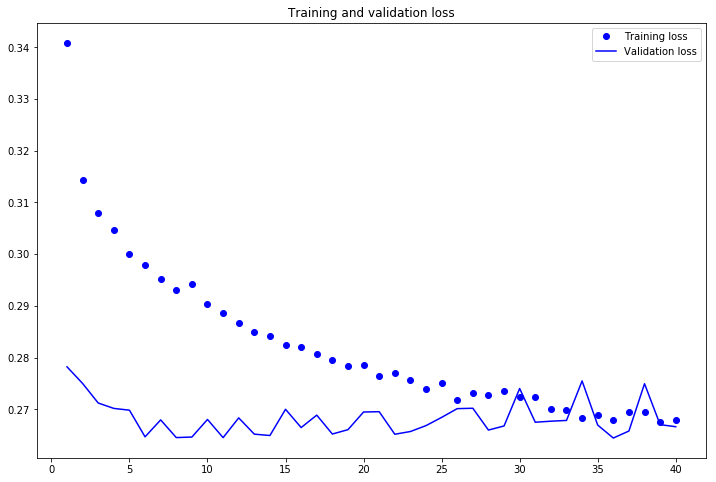

In [38]:
# Plotting the results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize = (12, 8))
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Stacking recurrent layers

In [39]:
model = Sequential()
model.add(GRU(units = 32,
              dropout = 0.1,
              recurrent_dropout = 0.5,
              return_sequences = True,
              input_shape = (None, number_of_features)))
model.add(GRU(units = 64, 
              activation = 'relu',
              dropout = 0.1, 
              recurrent_dropout = 0.5))
model.add(Dense(units = 1))
model.compile(optimizer = RMSprop(), 
              loss = 'mae')

In [40]:
history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 40,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/40


314/500 [=================>............] - ETA: 24:44 - loss: 0.69 - ETA: 15:43 - loss: 0.67 - ETA: 12:46 - loss: 0.61 - ETA: 11:14 - loss: 0.58 - ETA: 10:18 - loss: 0.55 - ETA: 9:40 - loss: 0.5385 - ETA: 9:14 - loss: 0.523 - ETA: 8:55 - loss: 0.510 - ETA: 8:38 - loss: 0.500 - ETA: 8:25 - loss: 0.492 - ETA: 8:14 - loss: 0.479 - ETA: 8:06 - loss: 0.470 - ETA: 7:58 - loss: 0.459 - ETA: 7:51 - loss: 0.453 - ETA: 7:46 - loss: 0.450 - ETA: 7:41 - loss: 0.449 - ETA: 7:36 - loss: 0.445 - ETA: 7:31 - loss: 0.442 - ETA: 7:28 - loss: 0.438 - ETA: 7:23 - loss: 0.436 - ETA: 7:20 - loss: 0.434 - ETA: 7:17 - loss: 0.431 - ETA: 7:14 - loss: 0.429 - ETA: 7:11 - loss: 0.425 - ETA: 7:09 - loss: 0.422 - ETA: 7:06 - loss: 0.421 - ETA: 7:04 - loss: 0.418 - ETA: 7:01 - loss: 0.417 - ETA: 6:59 - loss: 0.415 - ETA: 6:57 - loss: 0.413 - ETA: 6:55 - loss: 0.411 - ETA: 6:54 - loss: 0.409 - ETA: 6:52 - loss: 0.408 - ETA: 6:50 - loss: 0.406 - ETA: 6:49 - loss: 0.404 - ETA: 6:48 - loss: 0.403 - ETA: 6:46 - loss: 0.

500/500 [==============================] - ETA: 2:32 - loss: 0.340 - ETA: 2:31 - loss: 0.340 - ETA: 2:30 - loss: 0.341 - ETA: 2:29 - loss: 0.341 - ETA: 2:29 - loss: 0.341 - ETA: 2:28 - loss: 0.340 - ETA: 2:27 - loss: 0.340 - ETA: 2:26 - loss: 0.340 - ETA: 2:25 - loss: 0.340 - ETA: 2:25 - loss: 0.340 - ETA: 2:24 - loss: 0.340 - ETA: 2:23 - loss: 0.340 - ETA: 2:22 - loss: 0.340 - ETA: 2:21 - loss: 0.340 - ETA: 2:20 - loss: 0.340 - ETA: 2:20 - loss: 0.340 - ETA: 2:19 - loss: 0.340 - ETA: 2:18 - loss: 0.340 - ETA: 2:17 - loss: 0.340 - ETA: 2:16 - loss: 0.340 - ETA: 2:15 - loss: 0.340 - ETA: 2:15 - loss: 0.340 - ETA: 2:14 - loss: 0.340 - ETA: 2:13 - loss: 0.340 - ETA: 2:12 - loss: 0.340 - ETA: 2:11 - loss: 0.340 - ETA: 2:10 - loss: 0.340 - ETA: 2:10 - loss: 0.340 - ETA: 2:09 - loss: 0.340 - ETA: 2:08 - loss: 0.340 - ETA: 2:07 - loss: 0.340 - ETA: 2:06 - loss: 0.340 - ETA: 2:06 - loss: 0.340 - ETA: 2:05 - loss: 0.339 - ETA: 2:04 - loss: 0.339 - ETA: 2:03 - loss: 0.339 - ETA: 2:02 - loss: 0.3

314/500 [=================>............] - ETA: 6:39 - loss: 0.333 - ETA: 6:41 - loss: 0.315 - ETA: 6:41 - loss: 0.317 - ETA: 6:40 - loss: 0.312 - ETA: 6:41 - loss: 0.310 - ETA: 6:40 - loss: 0.305 - ETA: 6:39 - loss: 0.305 - ETA: 6:39 - loss: 0.307 - ETA: 6:38 - loss: 0.312 - ETA: 6:37 - loss: 0.313 - ETA: 6:37 - loss: 0.313 - ETA: 6:36 - loss: 0.317 - ETA: 6:36 - loss: 0.316 - ETA: 6:35 - loss: 0.316 - ETA: 6:34 - loss: 0.316 - ETA: 6:33 - loss: 0.315 - ETA: 6:33 - loss: 0.315 - ETA: 6:32 - loss: 0.315 - ETA: 6:31 - loss: 0.316 - ETA: 6:30 - loss: 0.318 - ETA: 6:29 - loss: 0.320 - ETA: 6:29 - loss: 0.319 - ETA: 6:28 - loss: 0.320 - ETA: 6:27 - loss: 0.320 - ETA: 6:26 - loss: 0.321 - ETA: 6:25 - loss: 0.320 - ETA: 6:25 - loss: 0.319 - ETA: 6:24 - loss: 0.320 - ETA: 6:23 - loss: 0.320 - ETA: 6:22 - loss: 0.319 - ETA: 6:21 - loss: 0.318 - ETA: 6:20 - loss: 0.318 - ETA: 6:19 - loss: 0.317 - ETA: 6:18 - loss: 0.318 - ETA: 6:18 - loss: 0.318 - ETA: 6:17 - loss: 0.317 - ETA: 6:16 - loss: 0.3

500/500 [==============================] - ETA: 2:30 - loss: 0.313 - ETA: 2:29 - loss: 0.313 - ETA: 2:28 - loss: 0.313 - ETA: 2:28 - loss: 0.313 - ETA: 2:27 - loss: 0.313 - ETA: 2:26 - loss: 0.313 - ETA: 2:25 - loss: 0.313 - ETA: 2:24 - loss: 0.313 - ETA: 2:24 - loss: 0.313 - ETA: 2:23 - loss: 0.312 - ETA: 2:22 - loss: 0.312 - ETA: 2:21 - loss: 0.312 - ETA: 2:20 - loss: 0.312 - ETA: 2:19 - loss: 0.312 - ETA: 2:19 - loss: 0.313 - ETA: 2:18 - loss: 0.312 - ETA: 2:17 - loss: 0.312 - ETA: 2:16 - loss: 0.312 - ETA: 2:15 - loss: 0.312 - ETA: 2:15 - loss: 0.312 - ETA: 2:14 - loss: 0.312 - ETA: 2:13 - loss: 0.312 - ETA: 2:12 - loss: 0.312 - ETA: 2:11 - loss: 0.312 - ETA: 2:11 - loss: 0.312 - ETA: 2:10 - loss: 0.312 - ETA: 2:09 - loss: 0.312 - ETA: 2:08 - loss: 0.312 - ETA: 2:07 - loss: 0.312 - ETA: 2:06 - loss: 0.312 - ETA: 2:06 - loss: 0.312 - ETA: 2:05 - loss: 0.312 - ETA: 2:04 - loss: 0.312 - ETA: 2:03 - loss: 0.312 - ETA: 2:02 - loss: 0.312 - ETA: 2:02 - loss: 0.312 - ETA: 2:01 - loss: 0.3

314/500 [=================>............] - ETA: 6:41 - loss: 0.301 - ETA: 6:41 - loss: 0.317 - ETA: 6:43 - loss: 0.309 - ETA: 6:43 - loss: 0.313 - ETA: 6:41 - loss: 0.315 - ETA: 6:40 - loss: 0.321 - ETA: 6:39 - loss: 0.325 - ETA: 6:38 - loss: 0.324 - ETA: 6:38 - loss: 0.317 - ETA: 6:36 - loss: 0.314 - ETA: 6:35 - loss: 0.314 - ETA: 6:34 - loss: 0.314 - ETA: 6:34 - loss: 0.313 - ETA: 6:33 - loss: 0.315 - ETA: 6:33 - loss: 0.312 - ETA: 6:35 - loss: 0.314 - ETA: 6:34 - loss: 0.313 - ETA: 6:33 - loss: 0.313 - ETA: 6:31 - loss: 0.315 - ETA: 6:30 - loss: 0.312 - ETA: 6:29 - loss: 0.312 - ETA: 6:29 - loss: 0.311 - ETA: 6:28 - loss: 0.310 - ETA: 6:27 - loss: 0.311 - ETA: 6:26 - loss: 0.310 - ETA: 6:26 - loss: 0.312 - ETA: 6:25 - loss: 0.313 - ETA: 6:24 - loss: 0.314 - ETA: 6:23 - loss: 0.314 - ETA: 6:22 - loss: 0.315 - ETA: 6:21 - loss: 0.315 - ETA: 6:20 - loss: 0.314 - ETA: 6:19 - loss: 0.314 - ETA: 6:19 - loss: 0.313 - ETA: 6:18 - loss: 0.314 - ETA: 6:17 - loss: 0.312 - ETA: 6:17 - loss: 0.3

500/500 [==============================] - ETA: 2:30 - loss: 0.306 - ETA: 2:30 - loss: 0.306 - ETA: 2:29 - loss: 0.306 - ETA: 2:28 - loss: 0.306 - ETA: 2:27 - loss: 0.306 - ETA: 2:26 - loss: 0.306 - ETA: 2:26 - loss: 0.306 - ETA: 2:25 - loss: 0.306 - ETA: 2:24 - loss: 0.306 - ETA: 2:23 - loss: 0.306 - ETA: 2:22 - loss: 0.306 - ETA: 2:22 - loss: 0.306 - ETA: 2:21 - loss: 0.306 - ETA: 2:20 - loss: 0.306 - ETA: 2:19 - loss: 0.306 - ETA: 2:18 - loss: 0.306 - ETA: 2:17 - loss: 0.306 - ETA: 2:17 - loss: 0.306 - ETA: 2:16 - loss: 0.306 - ETA: 2:15 - loss: 0.306 - ETA: 2:14 - loss: 0.306 - ETA: 2:13 - loss: 0.306 - ETA: 2:13 - loss: 0.306 - ETA: 2:12 - loss: 0.306 - ETA: 2:11 - loss: 0.306 - ETA: 2:10 - loss: 0.306 - ETA: 2:09 - loss: 0.306 - ETA: 2:08 - loss: 0.306 - ETA: 2:08 - loss: 0.306 - ETA: 2:07 - loss: 0.306 - ETA: 2:06 - loss: 0.306 - ETA: 2:05 - loss: 0.306 - ETA: 2:04 - loss: 0.306 - ETA: 2:04 - loss: 0.306 - ETA: 2:03 - loss: 0.306 - ETA: 2:02 - loss: 0.306 - ETA: 2:01 - loss: 0.3

314/500 [=================>............] - ETA: 6:43 - loss: 0.317 - ETA: 6:41 - loss: 0.319 - ETA: 7:23 - loss: 0.316 - ETA: 7:23 - loss: 0.319 - ETA: 7:13 - loss: 0.320 - ETA: 7:07 - loss: 0.319 - ETA: 7:02 - loss: 0.315 - ETA: 6:57 - loss: 0.313 - ETA: 6:54 - loss: 0.315 - ETA: 6:51 - loss: 0.314 - ETA: 6:49 - loss: 0.314 - ETA: 6:48 - loss: 0.311 - ETA: 6:46 - loss: 0.312 - ETA: 6:44 - loss: 0.313 - ETA: 6:42 - loss: 0.314 - ETA: 6:40 - loss: 0.315 - ETA: 6:38 - loss: 0.311 - ETA: 6:37 - loss: 0.310 - ETA: 6:36 - loss: 0.309 - ETA: 6:35 - loss: 0.310 - ETA: 6:33 - loss: 0.310 - ETA: 6:32 - loss: 0.310 - ETA: 6:31 - loss: 0.309 - ETA: 6:30 - loss: 0.308 - ETA: 6:29 - loss: 0.308 - ETA: 6:28 - loss: 0.308 - ETA: 6:27 - loss: 0.307 - ETA: 6:26 - loss: 0.306 - ETA: 6:25 - loss: 0.307 - ETA: 6:24 - loss: 0.308 - ETA: 6:23 - loss: 0.306 - ETA: 6:22 - loss: 0.305 - ETA: 6:21 - loss: 0.305 - ETA: 6:20 - loss: 0.305 - ETA: 6:19 - loss: 0.305 - ETA: 6:18 - loss: 0.305 - ETA: 6:17 - loss: 0.3

500/500 [==============================] - ETA: 2:30 - loss: 0.304 - ETA: 2:29 - loss: 0.304 - ETA: 2:28 - loss: 0.304 - ETA: 2:27 - loss: 0.304 - ETA: 2:26 - loss: 0.304 - ETA: 2:26 - loss: 0.304 - ETA: 2:25 - loss: 0.304 - ETA: 2:24 - loss: 0.304 - ETA: 2:23 - loss: 0.304 - ETA: 2:22 - loss: 0.304 - ETA: 2:22 - loss: 0.304 - ETA: 2:21 - loss: 0.304 - ETA: 2:20 - loss: 0.304 - ETA: 2:19 - loss: 0.304 - ETA: 2:18 - loss: 0.304 - ETA: 2:18 - loss: 0.304 - ETA: 2:17 - loss: 0.304 - ETA: 2:16 - loss: 0.304 - ETA: 2:15 - loss: 0.304 - ETA: 2:14 - loss: 0.304 - ETA: 2:13 - loss: 0.304 - ETA: 2:13 - loss: 0.304 - ETA: 2:12 - loss: 0.304 - ETA: 2:11 - loss: 0.304 - ETA: 2:10 - loss: 0.304 - ETA: 2:09 - loss: 0.304 - ETA: 2:09 - loss: 0.304 - ETA: 2:08 - loss: 0.304 - ETA: 2:07 - loss: 0.304 - ETA: 2:06 - loss: 0.304 - ETA: 2:05 - loss: 0.304 - ETA: 2:05 - loss: 0.304 - ETA: 2:04 - loss: 0.304 - ETA: 2:03 - loss: 0.304 - ETA: 2:02 - loss: 0.304 - ETA: 2:01 - loss: 0.304 - ETA: 2:00 - loss: 0.3

314/500 [=================>............] - ETA: 8:24 - loss: 0.300 - ETA: 8:00 - loss: 0.300 - ETA: 7:32 - loss: 0.300 - ETA: 7:20 - loss: 0.303 - ETA: 7:13 - loss: 0.300 - ETA: 7:07 - loss: 0.296 - ETA: 7:03 - loss: 0.297 - ETA: 6:59 - loss: 0.294 - ETA: 6:56 - loss: 0.290 - ETA: 6:54 - loss: 0.290 - ETA: 6:51 - loss: 0.293 - ETA: 6:50 - loss: 0.295 - ETA: 6:52 - loss: 0.294 - ETA: 6:51 - loss: 0.295 - ETA: 6:49 - loss: 0.293 - ETA: 6:47 - loss: 0.293 - ETA: 6:45 - loss: 0.295 - ETA: 6:44 - loss: 0.296 - ETA: 6:42 - loss: 0.297 - ETA: 6:41 - loss: 0.296 - ETA: 6:40 - loss: 0.297 - ETA: 6:38 - loss: 0.297 - ETA: 6:37 - loss: 0.298 - ETA: 6:36 - loss: 0.297 - ETA: 6:34 - loss: 0.297 - ETA: 6:33 - loss: 0.297 - ETA: 6:32 - loss: 0.297 - ETA: 6:31 - loss: 0.297 - ETA: 6:29 - loss: 0.296 - ETA: 6:28 - loss: 0.297 - ETA: 6:27 - loss: 0.298 - ETA: 6:26 - loss: 0.298 - ETA: 6:25 - loss: 0.298 - ETA: 6:24 - loss: 0.299 - ETA: 6:23 - loss: 0.299 - ETA: 6:23 - loss: 0.299 - ETA: 6:21 - loss: 0.2

500/500 [==============================] - ETA: 2:31 - loss: 0.300 - ETA: 2:30 - loss: 0.300 - ETA: 2:29 - loss: 0.300 - ETA: 2:28 - loss: 0.300 - ETA: 2:27 - loss: 0.300 - ETA: 2:26 - loss: 0.300 - ETA: 2:26 - loss: 0.300 - ETA: 2:25 - loss: 0.300 - ETA: 2:24 - loss: 0.300 - ETA: 2:23 - loss: 0.300 - ETA: 2:22 - loss: 0.300 - ETA: 2:22 - loss: 0.300 - ETA: 2:21 - loss: 0.300 - ETA: 2:20 - loss: 0.300 - ETA: 2:19 - loss: 0.300 - ETA: 2:18 - loss: 0.300 - ETA: 2:17 - loss: 0.300 - ETA: 2:17 - loss: 0.300 - ETA: 2:16 - loss: 0.300 - ETA: 2:15 - loss: 0.300 - ETA: 2:14 - loss: 0.300 - ETA: 2:13 - loss: 0.300 - ETA: 2:13 - loss: 0.300 - ETA: 2:12 - loss: 0.300 - ETA: 2:11 - loss: 0.300 - ETA: 2:10 - loss: 0.300 - ETA: 2:09 - loss: 0.300 - ETA: 2:08 - loss: 0.300 - ETA: 2:08 - loss: 0.300 - ETA: 2:07 - loss: 0.300 - ETA: 2:06 - loss: 0.300 - ETA: 2:05 - loss: 0.300 - ETA: 2:04 - loss: 0.300 - ETA: 2:03 - loss: 0.300 - ETA: 2:03 - loss: 0.300 - ETA: 2:02 - loss: 0.300 - ETA: 2:01 - loss: 0.3

314/500 [=================>............] - ETA: 6:48 - loss: 0.295 - ETA: 6:43 - loss: 0.299 - ETA: 6:44 - loss: 0.303 - ETA: 6:43 - loss: 0.313 - ETA: 6:42 - loss: 0.309 - ETA: 6:41 - loss: 0.303 - ETA: 6:40 - loss: 0.297 - ETA: 6:39 - loss: 0.295 - ETA: 6:38 - loss: 0.296 - ETA: 6:38 - loss: 0.293 - ETA: 6:37 - loss: 0.294 - ETA: 6:36 - loss: 0.293 - ETA: 6:35 - loss: 0.292 - ETA: 6:35 - loss: 0.292 - ETA: 6:34 - loss: 0.291 - ETA: 6:33 - loss: 0.290 - ETA: 6:32 - loss: 0.288 - ETA: 6:31 - loss: 0.289 - ETA: 6:31 - loss: 0.289 - ETA: 6:30 - loss: 0.291 - ETA: 6:29 - loss: 0.292 - ETA: 6:28 - loss: 0.292 - ETA: 6:27 - loss: 0.291 - ETA: 6:27 - loss: 0.292 - ETA: 6:26 - loss: 0.293 - ETA: 6:25 - loss: 0.293 - ETA: 6:24 - loss: 0.294 - ETA: 6:23 - loss: 0.295 - ETA: 6:22 - loss: 0.295 - ETA: 6:21 - loss: 0.294 - ETA: 6:20 - loss: 0.296 - ETA: 6:19 - loss: 0.297 - ETA: 6:19 - loss: 0.297 - ETA: 6:19 - loss: 0.297 - ETA: 6:18 - loss: 0.297 - ETA: 6:17 - loss: 0.297 - ETA: 6:17 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.296 - ETA: 2:29 - loss: 0.296 - ETA: 2:28 - loss: 0.296 - ETA: 2:27 - loss: 0.296 - ETA: 2:27 - loss: 0.296 - ETA: 2:26 - loss: 0.296 - ETA: 2:25 - loss: 0.296 - ETA: 2:24 - loss: 0.296 - ETA: 2:23 - loss: 0.296 - ETA: 2:22 - loss: 0.296 - ETA: 2:22 - loss: 0.296 - ETA: 2:21 - loss: 0.296 - ETA: 2:20 - loss: 0.296 - ETA: 2:19 - loss: 0.296 - ETA: 2:18 - loss: 0.296 - ETA: 2:18 - loss: 0.296 - ETA: 2:17 - loss: 0.296 - ETA: 2:16 - loss: 0.296 - ETA: 2:15 - loss: 0.296 - ETA: 2:14 - loss: 0.296 - ETA: 2:14 - loss: 0.296 - ETA: 2:13 - loss: 0.296 - ETA: 2:12 - loss: 0.296 - ETA: 2:11 - loss: 0.296 - ETA: 2:10 - loss: 0.296 - ETA: 2:10 - loss: 0.296 - ETA: 2:09 - loss: 0.296 - ETA: 2:08 - loss: 0.296 - ETA: 2:07 - loss: 0.296 - ETA: 2:06 - loss: 0.296 - ETA: 2:05 - loss: 0.296 - ETA: 2:05 - loss: 0.296 - ETA: 2:04 - loss: 0.296 - ETA: 2:03 - loss: 0.296 - ETA: 2:02 - loss: 0.296 - ETA: 2:01 - loss: 0.296 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:50 - loss: 0.279 - ETA: 6:48 - loss: 0.281 - ETA: 6:46 - loss: 0.282 - ETA: 6:45 - loss: 0.283 - ETA: 6:43 - loss: 0.294 - ETA: 6:42 - loss: 0.293 - ETA: 6:41 - loss: 0.297 - ETA: 6:40 - loss: 0.295 - ETA: 6:39 - loss: 0.299 - ETA: 6:38 - loss: 0.299 - ETA: 6:38 - loss: 0.298 - ETA: 6:36 - loss: 0.297 - ETA: 6:36 - loss: 0.297 - ETA: 6:35 - loss: 0.295 - ETA: 6:34 - loss: 0.293 - ETA: 6:34 - loss: 0.294 - ETA: 6:33 - loss: 0.296 - ETA: 6:32 - loss: 0.296 - ETA: 6:31 - loss: 0.297 - ETA: 6:30 - loss: 0.296 - ETA: 6:30 - loss: 0.295 - ETA: 6:29 - loss: 0.296 - ETA: 6:28 - loss: 0.297 - ETA: 6:27 - loss: 0.296 - ETA: 6:26 - loss: 0.296 - ETA: 6:25 - loss: 0.295 - ETA: 6:24 - loss: 0.297 - ETA: 6:23 - loss: 0.298 - ETA: 6:23 - loss: 0.298 - ETA: 6:22 - loss: 0.297 - ETA: 6:21 - loss: 0.297 - ETA: 6:20 - loss: 0.298 - ETA: 6:20 - loss: 0.299 - ETA: 6:19 - loss: 0.298 - ETA: 6:18 - loss: 0.298 - ETA: 6:17 - loss: 0.298 - ETA: 6:17 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.293 - ETA: 2:29 - loss: 0.293 - ETA: 2:28 - loss: 0.292 - ETA: 2:27 - loss: 0.292 - ETA: 2:26 - loss: 0.292 - ETA: 2:26 - loss: 0.292 - ETA: 2:25 - loss: 0.292 - ETA: 2:24 - loss: 0.292 - ETA: 2:23 - loss: 0.292 - ETA: 2:22 - loss: 0.292 - ETA: 2:22 - loss: 0.292 - ETA: 2:21 - loss: 0.292 - ETA: 2:20 - loss: 0.292 - ETA: 2:19 - loss: 0.292 - ETA: 2:18 - loss: 0.292 - ETA: 2:18 - loss: 0.292 - ETA: 2:17 - loss: 0.292 - ETA: 2:16 - loss: 0.292 - ETA: 2:15 - loss: 0.292 - ETA: 2:14 - loss: 0.292 - ETA: 2:13 - loss: 0.292 - ETA: 2:13 - loss: 0.292 - ETA: 2:12 - loss: 0.292 - ETA: 2:11 - loss: 0.292 - ETA: 2:10 - loss: 0.292 - ETA: 2:09 - loss: 0.292 - ETA: 2:09 - loss: 0.292 - ETA: 2:08 - loss: 0.292 - ETA: 2:07 - loss: 0.292 - ETA: 2:06 - loss: 0.292 - ETA: 2:05 - loss: 0.292 - ETA: 2:05 - loss: 0.292 - ETA: 2:04 - loss: 0.292 - ETA: 2:03 - loss: 0.292 - ETA: 2:02 - loss: 0.292 - ETA: 2:01 - loss: 0.292 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:38 - loss: 0.309 - ETA: 6:39 - loss: 0.278 - ETA: 6:38 - loss: 0.285 - ETA: 6:40 - loss: 0.283 - ETA: 6:40 - loss: 0.283 - ETA: 6:40 - loss: 0.278 - ETA: 6:40 - loss: 0.283 - ETA: 6:38 - loss: 0.281 - ETA: 6:37 - loss: 0.281 - ETA: 6:36 - loss: 0.283 - ETA: 6:35 - loss: 0.283 - ETA: 6:35 - loss: 0.285 - ETA: 6:34 - loss: 0.288 - ETA: 6:33 - loss: 0.287 - ETA: 6:32 - loss: 0.286 - ETA: 6:32 - loss: 0.287 - ETA: 6:31 - loss: 0.286 - ETA: 6:30 - loss: 0.286 - ETA: 6:30 - loss: 0.288 - ETA: 6:29 - loss: 0.287 - ETA: 6:29 - loss: 0.287 - ETA: 6:28 - loss: 0.287 - ETA: 6:27 - loss: 0.286 - ETA: 6:26 - loss: 0.286 - ETA: 6:25 - loss: 0.287 - ETA: 6:24 - loss: 0.286 - ETA: 6:24 - loss: 0.286 - ETA: 6:23 - loss: 0.286 - ETA: 6:22 - loss: 0.286 - ETA: 6:21 - loss: 0.287 - ETA: 6:20 - loss: 0.288 - ETA: 6:20 - loss: 0.288 - ETA: 6:19 - loss: 0.290 - ETA: 6:18 - loss: 0.289 - ETA: 6:17 - loss: 0.289 - ETA: 6:17 - loss: 0.289 - ETA: 6:16 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.289 - ETA: 2:30 - loss: 0.289 - ETA: 2:29 - loss: 0.289 - ETA: 2:28 - loss: 0.289 - ETA: 2:27 - loss: 0.289 - ETA: 2:26 - loss: 0.289 - ETA: 2:26 - loss: 0.289 - ETA: 2:25 - loss: 0.289 - ETA: 2:24 - loss: 0.289 - ETA: 2:23 - loss: 0.289 - ETA: 2:22 - loss: 0.289 - ETA: 2:21 - loss: 0.289 - ETA: 2:21 - loss: 0.289 - ETA: 2:20 - loss: 0.289 - ETA: 2:19 - loss: 0.289 - ETA: 2:18 - loss: 0.289 - ETA: 2:17 - loss: 0.289 - ETA: 2:16 - loss: 0.289 - ETA: 2:16 - loss: 0.289 - ETA: 2:15 - loss: 0.289 - ETA: 2:14 - loss: 0.289 - ETA: 2:13 - loss: 0.289 - ETA: 2:12 - loss: 0.289 - ETA: 2:12 - loss: 0.289 - ETA: 2:11 - loss: 0.289 - ETA: 2:10 - loss: 0.289 - ETA: 2:09 - loss: 0.289 - ETA: 2:08 - loss: 0.289 - ETA: 2:08 - loss: 0.289 - ETA: 2:07 - loss: 0.289 - ETA: 2:06 - loss: 0.289 - ETA: 2:05 - loss: 0.289 - ETA: 2:04 - loss: 0.289 - ETA: 2:03 - loss: 0.289 - ETA: 2:03 - loss: 0.289 - ETA: 2:02 - loss: 0.289 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:47 - loss: 0.280 - ETA: 6:48 - loss: 0.292 - ETA: 6:46 - loss: 0.284 - ETA: 6:44 - loss: 0.289 - ETA: 6:42 - loss: 0.291 - ETA: 6:42 - loss: 0.288 - ETA: 6:41 - loss: 0.286 - ETA: 6:40 - loss: 0.285 - ETA: 6:39 - loss: 0.285 - ETA: 6:38 - loss: 0.286 - ETA: 6:37 - loss: 0.284 - ETA: 6:37 - loss: 0.287 - ETA: 6:36 - loss: 0.288 - ETA: 6:35 - loss: 0.287 - ETA: 6:35 - loss: 0.288 - ETA: 6:33 - loss: 0.287 - ETA: 6:35 - loss: 0.288 - ETA: 6:34 - loss: 0.287 - ETA: 6:33 - loss: 0.287 - ETA: 6:32 - loss: 0.287 - ETA: 6:31 - loss: 0.287 - ETA: 6:30 - loss: 0.286 - ETA: 6:29 - loss: 0.286 - ETA: 6:28 - loss: 0.287 - ETA: 6:27 - loss: 0.288 - ETA: 6:26 - loss: 0.286 - ETA: 6:25 - loss: 0.286 - ETA: 6:24 - loss: 0.285 - ETA: 6:24 - loss: 0.284 - ETA: 6:23 - loss: 0.284 - ETA: 6:22 - loss: 0.284 - ETA: 6:21 - loss: 0.285 - ETA: 6:20 - loss: 0.285 - ETA: 6:19 - loss: 0.285 - ETA: 6:18 - loss: 0.285 - ETA: 6:17 - loss: 0.285 - ETA: 6:16 - loss: 0.2

500/500 [==============================] - ETA: 2:31 - loss: 0.285 - ETA: 2:30 - loss: 0.285 - ETA: 2:30 - loss: 0.285 - ETA: 2:29 - loss: 0.285 - ETA: 2:28 - loss: 0.285 - ETA: 2:27 - loss: 0.285 - ETA: 2:26 - loss: 0.285 - ETA: 2:25 - loss: 0.285 - ETA: 2:25 - loss: 0.285 - ETA: 2:24 - loss: 0.285 - ETA: 2:23 - loss: 0.285 - ETA: 2:22 - loss: 0.285 - ETA: 2:21 - loss: 0.285 - ETA: 2:21 - loss: 0.285 - ETA: 2:20 - loss: 0.285 - ETA: 2:19 - loss: 0.285 - ETA: 2:18 - loss: 0.285 - ETA: 2:17 - loss: 0.285 - ETA: 2:16 - loss: 0.285 - ETA: 2:16 - loss: 0.285 - ETA: 2:15 - loss: 0.285 - ETA: 2:14 - loss: 0.285 - ETA: 2:13 - loss: 0.285 - ETA: 2:12 - loss: 0.285 - ETA: 2:11 - loss: 0.285 - ETA: 2:11 - loss: 0.285 - ETA: 2:10 - loss: 0.285 - ETA: 2:09 - loss: 0.285 - ETA: 2:08 - loss: 0.285 - ETA: 2:07 - loss: 0.285 - ETA: 2:07 - loss: 0.285 - ETA: 2:06 - loss: 0.285 - ETA: 2:05 - loss: 0.285 - ETA: 2:04 - loss: 0.285 - ETA: 2:03 - loss: 0.285 - ETA: 2:02 - loss: 0.285 - ETA: 2:02 - loss: 0.2

314/500 [=================>............] - ETA: 6:44 - loss: 0.250 - ETA: 6:44 - loss: 0.266 - ETA: 6:43 - loss: 0.267 - ETA: 6:42 - loss: 0.271 - ETA: 6:43 - loss: 0.272 - ETA: 6:42 - loss: 0.276 - ETA: 6:41 - loss: 0.276 - ETA: 6:41 - loss: 0.278 - ETA: 6:41 - loss: 0.279 - ETA: 6:39 - loss: 0.280 - ETA: 6:38 - loss: 0.281 - ETA: 6:37 - loss: 0.280 - ETA: 6:37 - loss: 0.280 - ETA: 6:37 - loss: 0.282 - ETA: 6:36 - loss: 0.280 - ETA: 6:35 - loss: 0.279 - ETA: 6:34 - loss: 0.280 - ETA: 6:32 - loss: 0.279 - ETA: 6:32 - loss: 0.278 - ETA: 6:31 - loss: 0.279 - ETA: 6:30 - loss: 0.279 - ETA: 6:30 - loss: 0.279 - ETA: 6:29 - loss: 0.280 - ETA: 6:28 - loss: 0.281 - ETA: 6:27 - loss: 0.283 - ETA: 6:26 - loss: 0.284 - ETA: 6:25 - loss: 0.285 - ETA: 6:25 - loss: 0.285 - ETA: 6:24 - loss: 0.285 - ETA: 6:23 - loss: 0.284 - ETA: 6:22 - loss: 0.285 - ETA: 6:21 - loss: 0.286 - ETA: 6:24 - loss: 0.285 - ETA: 6:25 - loss: 0.284 - ETA: 6:25 - loss: 0.285 - ETA: 6:24 - loss: 0.284 - ETA: 6:23 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.283 - ETA: 2:30 - loss: 0.283 - ETA: 2:29 - loss: 0.283 - ETA: 2:28 - loss: 0.283 - ETA: 2:27 - loss: 0.283 - ETA: 2:26 - loss: 0.283 - ETA: 2:26 - loss: 0.283 - ETA: 2:25 - loss: 0.283 - ETA: 2:24 - loss: 0.283 - ETA: 2:23 - loss: 0.283 - ETA: 2:22 - loss: 0.283 - ETA: 2:22 - loss: 0.283 - ETA: 2:21 - loss: 0.283 - ETA: 2:20 - loss: 0.283 - ETA: 2:19 - loss: 0.283 - ETA: 2:18 - loss: 0.283 - ETA: 2:18 - loss: 0.283 - ETA: 2:17 - loss: 0.283 - ETA: 2:16 - loss: 0.283 - ETA: 2:15 - loss: 0.283 - ETA: 2:14 - loss: 0.283 - ETA: 2:13 - loss: 0.283 - ETA: 2:13 - loss: 0.283 - ETA: 2:12 - loss: 0.283 - ETA: 2:11 - loss: 0.283 - ETA: 2:10 - loss: 0.283 - ETA: 2:09 - loss: 0.283 - ETA: 2:09 - loss: 0.283 - ETA: 2:08 - loss: 0.283 - ETA: 2:07 - loss: 0.283 - ETA: 2:06 - loss: 0.283 - ETA: 2:05 - loss: 0.283 - ETA: 2:04 - loss: 0.283 - ETA: 2:04 - loss: 0.283 - ETA: 2:03 - loss: 0.283 - ETA: 2:02 - loss: 0.283 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:46 - loss: 0.280 - ETA: 6:44 - loss: 0.270 - ETA: 6:40 - loss: 0.272 - ETA: 6:41 - loss: 0.272 - ETA: 6:41 - loss: 0.284 - ETA: 6:41 - loss: 0.286 - ETA: 6:41 - loss: 0.285 - ETA: 6:46 - loss: 0.283 - ETA: 6:45 - loss: 0.282 - ETA: 6:44 - loss: 0.285 - ETA: 6:43 - loss: 0.287 - ETA: 6:42 - loss: 0.287 - ETA: 6:46 - loss: 0.286 - ETA: 6:49 - loss: 0.285 - ETA: 6:48 - loss: 0.286 - ETA: 6:46 - loss: 0.284 - ETA: 6:45 - loss: 0.285 - ETA: 6:43 - loss: 0.285 - ETA: 6:42 - loss: 0.284 - ETA: 6:41 - loss: 0.282 - ETA: 6:39 - loss: 0.281 - ETA: 6:38 - loss: 0.282 - ETA: 6:37 - loss: 0.282 - ETA: 6:36 - loss: 0.283 - ETA: 6:35 - loss: 0.284 - ETA: 6:33 - loss: 0.284 - ETA: 6:32 - loss: 0.283 - ETA: 6:31 - loss: 0.283 - ETA: 6:30 - loss: 0.283 - ETA: 6:29 - loss: 0.283 - ETA: 6:28 - loss: 0.283 - ETA: 6:27 - loss: 0.282 - ETA: 6:26 - loss: 0.280 - ETA: 6:25 - loss: 0.281 - ETA: 6:24 - loss: 0.283 - ETA: 6:23 - loss: 0.283 - ETA: 6:23 - loss: 0.2

500/500 [==============================] - ETA: 2:31 - loss: 0.282 - ETA: 2:30 - loss: 0.282 - ETA: 2:29 - loss: 0.282 - ETA: 2:29 - loss: 0.282 - ETA: 2:28 - loss: 0.282 - ETA: 2:27 - loss: 0.282 - ETA: 2:26 - loss: 0.282 - ETA: 2:26 - loss: 0.282 - ETA: 2:25 - loss: 0.282 - ETA: 2:24 - loss: 0.282 - ETA: 2:23 - loss: 0.282 - ETA: 2:22 - loss: 0.282 - ETA: 2:22 - loss: 0.282 - ETA: 2:21 - loss: 0.282 - ETA: 2:20 - loss: 0.282 - ETA: 2:19 - loss: 0.282 - ETA: 2:18 - loss: 0.282 - ETA: 2:17 - loss: 0.282 - ETA: 2:17 - loss: 0.282 - ETA: 2:16 - loss: 0.282 - ETA: 2:15 - loss: 0.282 - ETA: 2:14 - loss: 0.282 - ETA: 2:13 - loss: 0.282 - ETA: 2:13 - loss: 0.282 - ETA: 2:12 - loss: 0.282 - ETA: 2:11 - loss: 0.282 - ETA: 2:10 - loss: 0.282 - ETA: 2:09 - loss: 0.282 - ETA: 2:08 - loss: 0.282 - ETA: 2:08 - loss: 0.282 - ETA: 2:07 - loss: 0.282 - ETA: 2:06 - loss: 0.282 - ETA: 2:05 - loss: 0.282 - ETA: 2:04 - loss: 0.282 - ETA: 2:03 - loss: 0.282 - ETA: 2:03 - loss: 0.282 - ETA: 2:02 - loss: 0.2

314/500 [=================>............] - ETA: 6:41 - loss: 0.313 - ETA: 6:40 - loss: 0.296 - ETA: 6:41 - loss: 0.303 - ETA: 6:40 - loss: 0.292 - ETA: 6:39 - loss: 0.292 - ETA: 6:39 - loss: 0.293 - ETA: 6:38 - loss: 0.294 - ETA: 6:38 - loss: 0.293 - ETA: 6:37 - loss: 0.291 - ETA: 6:37 - loss: 0.289 - ETA: 6:36 - loss: 0.286 - ETA: 6:35 - loss: 0.286 - ETA: 6:34 - loss: 0.284 - ETA: 6:34 - loss: 0.284 - ETA: 6:32 - loss: 0.281 - ETA: 6:32 - loss: 0.283 - ETA: 6:32 - loss: 0.282 - ETA: 6:31 - loss: 0.280 - ETA: 6:30 - loss: 0.281 - ETA: 6:29 - loss: 0.281 - ETA: 6:29 - loss: 0.281 - ETA: 6:28 - loss: 0.281 - ETA: 6:27 - loss: 0.281 - ETA: 6:26 - loss: 0.282 - ETA: 6:25 - loss: 0.281 - ETA: 6:24 - loss: 0.280 - ETA: 6:23 - loss: 0.281 - ETA: 6:23 - loss: 0.281 - ETA: 6:22 - loss: 0.282 - ETA: 6:21 - loss: 0.281 - ETA: 6:20 - loss: 0.282 - ETA: 6:19 - loss: 0.282 - ETA: 6:18 - loss: 0.282 - ETA: 6:18 - loss: 0.283 - ETA: 6:17 - loss: 0.283 - ETA: 6:16 - loss: 0.283 - ETA: 6:15 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.280 - ETA: 2:30 - loss: 0.280 - ETA: 2:29 - loss: 0.280 - ETA: 2:28 - loss: 0.280 - ETA: 2:27 - loss: 0.280 - ETA: 2:26 - loss: 0.280 - ETA: 2:26 - loss: 0.280 - ETA: 2:25 - loss: 0.280 - ETA: 2:24 - loss: 0.280 - ETA: 2:23 - loss: 0.280 - ETA: 2:22 - loss: 0.280 - ETA: 2:22 - loss: 0.280 - ETA: 2:21 - loss: 0.280 - ETA: 2:20 - loss: 0.279 - ETA: 2:19 - loss: 0.279 - ETA: 2:18 - loss: 0.280 - ETA: 2:17 - loss: 0.279 - ETA: 2:17 - loss: 0.279 - ETA: 2:16 - loss: 0.279 - ETA: 2:15 - loss: 0.279 - ETA: 2:14 - loss: 0.280 - ETA: 2:13 - loss: 0.280 - ETA: 2:13 - loss: 0.280 - ETA: 2:12 - loss: 0.280 - ETA: 2:11 - loss: 0.280 - ETA: 2:10 - loss: 0.280 - ETA: 2:09 - loss: 0.280 - ETA: 2:08 - loss: 0.280 - ETA: 2:08 - loss: 0.280 - ETA: 2:07 - loss: 0.280 - ETA: 2:06 - loss: 0.280 - ETA: 2:05 - loss: 0.280 - ETA: 2:04 - loss: 0.280 - ETA: 2:04 - loss: 0.280 - ETA: 2:03 - loss: 0.280 - ETA: 2:02 - loss: 0.280 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:36 - loss: 0.262 - ETA: 6:38 - loss: 0.272 - ETA: 6:40 - loss: 0.276 - ETA: 6:39 - loss: 0.276 - ETA: 6:38 - loss: 0.276 - ETA: 6:38 - loss: 0.275 - ETA: 6:38 - loss: 0.280 - ETA: 6:36 - loss: 0.278 - ETA: 6:35 - loss: 0.282 - ETA: 6:35 - loss: 0.281 - ETA: 6:34 - loss: 0.280 - ETA: 6:33 - loss: 0.282 - ETA: 6:32 - loss: 0.281 - ETA: 6:31 - loss: 0.281 - ETA: 6:31 - loss: 0.282 - ETA: 6:30 - loss: 0.281 - ETA: 6:30 - loss: 0.282 - ETA: 6:29 - loss: 0.282 - ETA: 6:28 - loss: 0.281 - ETA: 6:28 - loss: 0.281 - ETA: 6:26 - loss: 0.281 - ETA: 6:25 - loss: 0.280 - ETA: 6:24 - loss: 0.281 - ETA: 6:24 - loss: 0.281 - ETA: 6:23 - loss: 0.280 - ETA: 6:22 - loss: 0.280 - ETA: 6:21 - loss: 0.279 - ETA: 6:21 - loss: 0.279 - ETA: 6:20 - loss: 0.279 - ETA: 6:19 - loss: 0.279 - ETA: 6:18 - loss: 0.279 - ETA: 6:17 - loss: 0.279 - ETA: 6:16 - loss: 0.279 - ETA: 6:15 - loss: 0.278 - ETA: 6:14 - loss: 0.279 - ETA: 6:14 - loss: 0.280 - ETA: 6:13 - loss: 0.2

500/500 [==============================] - ETA: 2:31 - loss: 0.278 - ETA: 2:30 - loss: 0.278 - ETA: 2:29 - loss: 0.278 - ETA: 2:28 - loss: 0.278 - ETA: 2:27 - loss: 0.278 - ETA: 2:26 - loss: 0.278 - ETA: 2:26 - loss: 0.278 - ETA: 2:25 - loss: 0.278 - ETA: 2:24 - loss: 0.278 - ETA: 2:23 - loss: 0.278 - ETA: 2:22 - loss: 0.278 - ETA: 2:22 - loss: 0.278 - ETA: 2:21 - loss: 0.278 - ETA: 2:20 - loss: 0.278 - ETA: 2:19 - loss: 0.278 - ETA: 2:18 - loss: 0.278 - ETA: 2:18 - loss: 0.278 - ETA: 2:17 - loss: 0.278 - ETA: 2:16 - loss: 0.278 - ETA: 2:15 - loss: 0.278 - ETA: 2:14 - loss: 0.278 - ETA: 2:13 - loss: 0.278 - ETA: 2:13 - loss: 0.278 - ETA: 2:12 - loss: 0.278 - ETA: 2:11 - loss: 0.278 - ETA: 2:10 - loss: 0.278 - ETA: 2:09 - loss: 0.278 - ETA: 2:09 - loss: 0.278 - ETA: 2:08 - loss: 0.278 - ETA: 2:07 - loss: 0.278 - ETA: 2:06 - loss: 0.278 - ETA: 2:05 - loss: 0.278 - ETA: 2:04 - loss: 0.278 - ETA: 2:04 - loss: 0.278 - ETA: 2:03 - loss: 0.278 - ETA: 2:02 - loss: 0.278 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:38 - loss: 0.270 - ETA: 6:41 - loss: 0.289 - ETA: 6:44 - loss: 0.287 - ETA: 6:43 - loss: 0.281 - ETA: 6:42 - loss: 0.281 - ETA: 6:41 - loss: 0.278 - ETA: 6:40 - loss: 0.276 - ETA: 6:39 - loss: 0.278 - ETA: 6:39 - loss: 0.276 - ETA: 6:42 - loss: 0.276 - ETA: 6:40 - loss: 0.278 - ETA: 6:40 - loss: 0.279 - ETA: 6:39 - loss: 0.280 - ETA: 6:38 - loss: 0.281 - ETA: 6:37 - loss: 0.282 - ETA: 6:36 - loss: 0.281 - ETA: 6:35 - loss: 0.279 - ETA: 6:37 - loss: 0.279 - ETA: 6:36 - loss: 0.280 - ETA: 6:35 - loss: 0.280 - ETA: 6:34 - loss: 0.280 - ETA: 6:33 - loss: 0.281 - ETA: 6:32 - loss: 0.282 - ETA: 6:31 - loss: 0.281 - ETA: 6:30 - loss: 0.280 - ETA: 6:30 - loss: 0.281 - ETA: 6:29 - loss: 0.279 - ETA: 6:28 - loss: 0.279 - ETA: 6:27 - loss: 0.279 - ETA: 6:26 - loss: 0.281 - ETA: 6:25 - loss: 0.280 - ETA: 6:24 - loss: 0.280 - ETA: 6:23 - loss: 0.280 - ETA: 6:22 - loss: 0.280 - ETA: 6:21 - loss: 0.280 - ETA: 6:20 - loss: 0.279 - ETA: 6:19 - loss: 0.2

500/500 [==============================] - ETA: 2:31 - loss: 0.278 - ETA: 2:30 - loss: 0.278 - ETA: 2:29 - loss: 0.278 - ETA: 2:28 - loss: 0.278 - ETA: 2:28 - loss: 0.278 - ETA: 2:27 - loss: 0.278 - ETA: 2:26 - loss: 0.278 - ETA: 2:25 - loss: 0.278 - ETA: 2:24 - loss: 0.278 - ETA: 2:23 - loss: 0.278 - ETA: 2:23 - loss: 0.278 - ETA: 2:22 - loss: 0.278 - ETA: 2:21 - loss: 0.278 - ETA: 2:20 - loss: 0.278 - ETA: 2:19 - loss: 0.278 - ETA: 2:19 - loss: 0.278 - ETA: 2:18 - loss: 0.278 - ETA: 2:17 - loss: 0.278 - ETA: 2:16 - loss: 0.278 - ETA: 2:15 - loss: 0.278 - ETA: 2:14 - loss: 0.278 - ETA: 2:14 - loss: 0.278 - ETA: 2:13 - loss: 0.278 - ETA: 2:12 - loss: 0.278 - ETA: 2:11 - loss: 0.278 - ETA: 2:10 - loss: 0.278 - ETA: 2:10 - loss: 0.278 - ETA: 2:09 - loss: 0.278 - ETA: 2:08 - loss: 0.278 - ETA: 2:07 - loss: 0.278 - ETA: 2:06 - loss: 0.278 - ETA: 2:05 - loss: 0.278 - ETA: 2:05 - loss: 0.278 - ETA: 2:04 - loss: 0.278 - ETA: 2:03 - loss: 0.278 - ETA: 2:02 - loss: 0.278 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:43 - loss: 0.291 - ETA: 6:41 - loss: 0.291 - ETA: 6:41 - loss: 0.277 - ETA: 6:41 - loss: 0.276 - ETA: 6:40 - loss: 0.276 - ETA: 6:39 - loss: 0.282 - ETA: 6:39 - loss: 0.278 - ETA: 6:39 - loss: 0.280 - ETA: 6:38 - loss: 0.280 - ETA: 6:37 - loss: 0.276 - ETA: 6:36 - loss: 0.277 - ETA: 6:35 - loss: 0.277 - ETA: 6:34 - loss: 0.277 - ETA: 6:33 - loss: 0.276 - ETA: 6:32 - loss: 0.278 - ETA: 6:32 - loss: 0.278 - ETA: 6:31 - loss: 0.280 - ETA: 6:30 - loss: 0.282 - ETA: 6:30 - loss: 0.280 - ETA: 6:29 - loss: 0.280 - ETA: 6:28 - loss: 0.281 - ETA: 6:27 - loss: 0.279 - ETA: 6:26 - loss: 0.279 - ETA: 6:25 - loss: 0.280 - ETA: 6:25 - loss: 0.281 - ETA: 6:24 - loss: 0.281 - ETA: 6:23 - loss: 0.281 - ETA: 6:22 - loss: 0.281 - ETA: 6:22 - loss: 0.282 - ETA: 6:21 - loss: 0.281 - ETA: 6:20 - loss: 0.282 - ETA: 6:20 - loss: 0.282 - ETA: 6:20 - loss: 0.282 - ETA: 6:19 - loss: 0.283 - ETA: 6:18 - loss: 0.283 - ETA: 6:17 - loss: 0.283 - ETA: 6:17 - loss: 0.2

500/500 [==============================] - ETA: 2:31 - loss: 0.276 - ETA: 2:30 - loss: 0.275 - ETA: 2:29 - loss: 0.275 - ETA: 2:29 - loss: 0.276 - ETA: 2:28 - loss: 0.276 - ETA: 2:27 - loss: 0.276 - ETA: 2:26 - loss: 0.276 - ETA: 2:25 - loss: 0.275 - ETA: 2:24 - loss: 0.275 - ETA: 2:24 - loss: 0.275 - ETA: 2:23 - loss: 0.275 - ETA: 2:22 - loss: 0.275 - ETA: 2:21 - loss: 0.275 - ETA: 2:20 - loss: 0.275 - ETA: 2:20 - loss: 0.275 - ETA: 2:19 - loss: 0.275 - ETA: 2:18 - loss: 0.275 - ETA: 2:17 - loss: 0.276 - ETA: 2:16 - loss: 0.276 - ETA: 2:15 - loss: 0.276 - ETA: 2:15 - loss: 0.275 - ETA: 2:14 - loss: 0.275 - ETA: 2:13 - loss: 0.275 - ETA: 2:12 - loss: 0.275 - ETA: 2:11 - loss: 0.275 - ETA: 2:11 - loss: 0.275 - ETA: 2:10 - loss: 0.275 - ETA: 2:09 - loss: 0.275 - ETA: 2:08 - loss: 0.275 - ETA: 2:07 - loss: 0.275 - ETA: 2:06 - loss: 0.275 - ETA: 2:06 - loss: 0.275 - ETA: 2:05 - loss: 0.275 - ETA: 2:04 - loss: 0.275 - ETA: 2:03 - loss: 0.275 - ETA: 2:02 - loss: 0.275 - ETA: 2:02 - loss: 0.2

314/500 [=================>............] - ETA: 6:44 - loss: 0.264 - ETA: 6:41 - loss: 0.271 - ETA: 6:41 - loss: 0.283 - ETA: 6:41 - loss: 0.280 - ETA: 6:39 - loss: 0.280 - ETA: 6:39 - loss: 0.283 - ETA: 6:38 - loss: 0.277 - ETA: 6:37 - loss: 0.276 - ETA: 6:36 - loss: 0.276 - ETA: 6:36 - loss: 0.275 - ETA: 6:35 - loss: 0.274 - ETA: 6:34 - loss: 0.276 - ETA: 6:33 - loss: 0.274 - ETA: 6:32 - loss: 0.273 - ETA: 6:31 - loss: 0.274 - ETA: 6:31 - loss: 0.274 - ETA: 6:30 - loss: 0.274 - ETA: 6:29 - loss: 0.275 - ETA: 6:28 - loss: 0.275 - ETA: 6:27 - loss: 0.275 - ETA: 6:27 - loss: 0.276 - ETA: 6:26 - loss: 0.276 - ETA: 6:25 - loss: 0.276 - ETA: 6:24 - loss: 0.277 - ETA: 6:23 - loss: 0.276 - ETA: 6:23 - loss: 0.276 - ETA: 6:22 - loss: 0.276 - ETA: 6:21 - loss: 0.277 - ETA: 6:20 - loss: 0.276 - ETA: 6:19 - loss: 0.276 - ETA: 6:19 - loss: 0.275 - ETA: 6:18 - loss: 0.276 - ETA: 6:17 - loss: 0.277 - ETA: 6:16 - loss: 0.276 - ETA: 6:15 - loss: 0.276 - ETA: 6:15 - loss: 0.277 - ETA: 6:14 - loss: 0.2

500/500 [==============================] - ETA: 2:31 - loss: 0.275 - ETA: 2:30 - loss: 0.275 - ETA: 2:29 - loss: 0.275 - ETA: 2:28 - loss: 0.275 - ETA: 2:28 - loss: 0.275 - ETA: 2:27 - loss: 0.275 - ETA: 2:26 - loss: 0.275 - ETA: 2:25 - loss: 0.275 - ETA: 2:24 - loss: 0.275 - ETA: 2:23 - loss: 0.275 - ETA: 2:23 - loss: 0.275 - ETA: 2:22 - loss: 0.275 - ETA: 2:21 - loss: 0.275 - ETA: 2:20 - loss: 0.275 - ETA: 2:19 - loss: 0.275 - ETA: 2:19 - loss: 0.275 - ETA: 2:18 - loss: 0.275 - ETA: 2:17 - loss: 0.275 - ETA: 2:16 - loss: 0.275 - ETA: 2:15 - loss: 0.275 - ETA: 2:14 - loss: 0.275 - ETA: 2:14 - loss: 0.275 - ETA: 2:13 - loss: 0.275 - ETA: 2:12 - loss: 0.275 - ETA: 2:11 - loss: 0.275 - ETA: 2:10 - loss: 0.275 - ETA: 2:09 - loss: 0.275 - ETA: 2:09 - loss: 0.275 - ETA: 2:08 - loss: 0.275 - ETA: 2:07 - loss: 0.275 - ETA: 2:06 - loss: 0.275 - ETA: 2:05 - loss: 0.275 - ETA: 2:05 - loss: 0.275 - ETA: 2:04 - loss: 0.275 - ETA: 2:03 - loss: 0.275 - ETA: 2:02 - loss: 0.275 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:40 - loss: 0.248 - ETA: 6:41 - loss: 0.274 - ETA: 6:43 - loss: 0.269 - ETA: 6:41 - loss: 0.263 - ETA: 6:40 - loss: 0.274 - ETA: 6:39 - loss: 0.273 - ETA: 6:38 - loss: 0.273 - ETA: 6:38 - loss: 0.269 - ETA: 6:36 - loss: 0.269 - ETA: 6:36 - loss: 0.271 - ETA: 6:35 - loss: 0.271 - ETA: 6:34 - loss: 0.272 - ETA: 6:33 - loss: 0.275 - ETA: 6:32 - loss: 0.275 - ETA: 6:31 - loss: 0.276 - ETA: 6:31 - loss: 0.275 - ETA: 6:30 - loss: 0.274 - ETA: 6:29 - loss: 0.275 - ETA: 6:28 - loss: 0.274 - ETA: 6:27 - loss: 0.274 - ETA: 6:27 - loss: 0.274 - ETA: 6:27 - loss: 0.275 - ETA: 6:26 - loss: 0.274 - ETA: 6:25 - loss: 0.275 - ETA: 6:24 - loss: 0.274 - ETA: 6:23 - loss: 0.275 - ETA: 6:22 - loss: 0.275 - ETA: 6:21 - loss: 0.275 - ETA: 6:20 - loss: 0.276 - ETA: 6:20 - loss: 0.275 - ETA: 6:19 - loss: 0.275 - ETA: 6:18 - loss: 0.275 - ETA: 6:19 - loss: 0.275 - ETA: 6:18 - loss: 0.275 - ETA: 6:17 - loss: 0.275 - ETA: 6:16 - loss: 0.274 - ETA: 6:15 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.271 - ETA: 2:29 - loss: 0.271 - ETA: 2:28 - loss: 0.271 - ETA: 2:28 - loss: 0.271 - ETA: 2:27 - loss: 0.271 - ETA: 2:26 - loss: 0.271 - ETA: 2:25 - loss: 0.271 - ETA: 2:24 - loss: 0.271 - ETA: 2:23 - loss: 0.271 - ETA: 2:23 - loss: 0.271 - ETA: 2:22 - loss: 0.272 - ETA: 2:21 - loss: 0.272 - ETA: 2:20 - loss: 0.272 - ETA: 2:19 - loss: 0.272 - ETA: 2:19 - loss: 0.272 - ETA: 2:18 - loss: 0.272 - ETA: 2:17 - loss: 0.272 - ETA: 2:16 - loss: 0.272 - ETA: 2:15 - loss: 0.272 - ETA: 2:15 - loss: 0.272 - ETA: 2:14 - loss: 0.272 - ETA: 2:13 - loss: 0.272 - ETA: 2:12 - loss: 0.272 - ETA: 2:11 - loss: 0.272 - ETA: 2:10 - loss: 0.272 - ETA: 2:10 - loss: 0.272 - ETA: 2:09 - loss: 0.272 - ETA: 2:08 - loss: 0.272 - ETA: 2:07 - loss: 0.272 - ETA: 2:06 - loss: 0.272 - ETA: 2:06 - loss: 0.272 - ETA: 2:05 - loss: 0.272 - ETA: 2:04 - loss: 0.272 - ETA: 2:03 - loss: 0.272 - ETA: 2:02 - loss: 0.272 - ETA: 2:02 - loss: 0.272 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:40 - loss: 0.254 - ETA: 6:41 - loss: 0.261 - ETA: 6:40 - loss: 0.264 - ETA: 6:39 - loss: 0.261 - ETA: 6:39 - loss: 0.257 - ETA: 6:38 - loss: 0.261 - ETA: 6:38 - loss: 0.258 - ETA: 6:36 - loss: 0.261 - ETA: 6:36 - loss: 0.264 - ETA: 6:36 - loss: 0.262 - ETA: 6:35 - loss: 0.263 - ETA: 6:35 - loss: 0.263 - ETA: 6:34 - loss: 0.264 - ETA: 6:33 - loss: 0.265 - ETA: 6:33 - loss: 0.265 - ETA: 6:32 - loss: 0.265 - ETA: 6:31 - loss: 0.265 - ETA: 6:30 - loss: 0.266 - ETA: 6:33 - loss: 0.265 - ETA: 6:33 - loss: 0.266 - ETA: 6:32 - loss: 0.266 - ETA: 6:31 - loss: 0.266 - ETA: 6:30 - loss: 0.265 - ETA: 6:29 - loss: 0.265 - ETA: 6:28 - loss: 0.264 - ETA: 6:27 - loss: 0.265 - ETA: 6:26 - loss: 0.266 - ETA: 6:25 - loss: 0.267 - ETA: 6:24 - loss: 0.268 - ETA: 6:23 - loss: 0.268 - ETA: 6:22 - loss: 0.268 - ETA: 6:22 - loss: 0.268 - ETA: 6:21 - loss: 0.268 - ETA: 6:20 - loss: 0.268 - ETA: 6:19 - loss: 0.268 - ETA: 6:19 - loss: 0.269 - ETA: 6:18 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.269 - ETA: 2:29 - loss: 0.269 - ETA: 2:29 - loss: 0.269 - ETA: 2:28 - loss: 0.269 - ETA: 2:27 - loss: 0.269 - ETA: 2:26 - loss: 0.269 - ETA: 2:25 - loss: 0.269 - ETA: 2:24 - loss: 0.269 - ETA: 2:24 - loss: 0.269 - ETA: 2:23 - loss: 0.270 - ETA: 2:22 - loss: 0.270 - ETA: 2:21 - loss: 0.270 - ETA: 2:20 - loss: 0.270 - ETA: 2:20 - loss: 0.270 - ETA: 2:19 - loss: 0.270 - ETA: 2:18 - loss: 0.270 - ETA: 2:17 - loss: 0.270 - ETA: 2:16 - loss: 0.270 - ETA: 2:15 - loss: 0.270 - ETA: 2:15 - loss: 0.270 - ETA: 2:14 - loss: 0.270 - ETA: 2:13 - loss: 0.270 - ETA: 2:12 - loss: 0.270 - ETA: 2:11 - loss: 0.270 - ETA: 2:11 - loss: 0.270 - ETA: 2:10 - loss: 0.270 - ETA: 2:09 - loss: 0.270 - ETA: 2:08 - loss: 0.270 - ETA: 2:07 - loss: 0.270 - ETA: 2:06 - loss: 0.270 - ETA: 2:06 - loss: 0.270 - ETA: 2:05 - loss: 0.270 - ETA: 2:04 - loss: 0.270 - ETA: 2:03 - loss: 0.270 - ETA: 2:02 - loss: 0.270 - ETA: 2:02 - loss: 0.270 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:48 - loss: 0.268 - ETA: 6:46 - loss: 0.271 - ETA: 6:44 - loss: 0.270 - ETA: 6:43 - loss: 0.268 - ETA: 6:41 - loss: 0.268 - ETA: 6:41 - loss: 0.269 - ETA: 6:39 - loss: 0.266 - ETA: 6:38 - loss: 0.266 - ETA: 6:38 - loss: 0.265 - ETA: 6:37 - loss: 0.267 - ETA: 6:37 - loss: 0.271 - ETA: 6:36 - loss: 0.271 - ETA: 6:35 - loss: 0.270 - ETA: 6:34 - loss: 0.272 - ETA: 6:33 - loss: 0.271 - ETA: 6:32 - loss: 0.269 - ETA: 6:31 - loss: 0.270 - ETA: 6:30 - loss: 0.269 - ETA: 6:29 - loss: 0.268 - ETA: 6:28 - loss: 0.270 - ETA: 6:28 - loss: 0.271 - ETA: 6:27 - loss: 0.270 - ETA: 6:26 - loss: 0.269 - ETA: 6:25 - loss: 0.270 - ETA: 6:24 - loss: 0.269 - ETA: 6:24 - loss: 0.269 - ETA: 6:23 - loss: 0.268 - ETA: 6:22 - loss: 0.268 - ETA: 6:22 - loss: 0.268 - ETA: 6:21 - loss: 0.268 - ETA: 6:20 - loss: 0.268 - ETA: 6:19 - loss: 0.268 - ETA: 6:19 - loss: 0.268 - ETA: 6:18 - loss: 0.268 - ETA: 6:17 - loss: 0.268 - ETA: 6:16 - loss: 0.268 - ETA: 6:16 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.271 - ETA: 2:29 - loss: 0.271 - ETA: 2:28 - loss: 0.271 - ETA: 2:28 - loss: 0.271 - ETA: 2:27 - loss: 0.271 - ETA: 2:26 - loss: 0.271 - ETA: 2:25 - loss: 0.271 - ETA: 2:24 - loss: 0.271 - ETA: 2:24 - loss: 0.271 - ETA: 2:23 - loss: 0.271 - ETA: 2:22 - loss: 0.271 - ETA: 2:21 - loss: 0.271 - ETA: 2:20 - loss: 0.271 - ETA: 2:19 - loss: 0.271 - ETA: 2:19 - loss: 0.271 - ETA: 2:18 - loss: 0.271 - ETA: 2:17 - loss: 0.271 - ETA: 2:16 - loss: 0.271 - ETA: 2:15 - loss: 0.271 - ETA: 2:15 - loss: 0.271 - ETA: 2:14 - loss: 0.271 - ETA: 2:13 - loss: 0.271 - ETA: 2:12 - loss: 0.271 - ETA: 2:11 - loss: 0.271 - ETA: 2:11 - loss: 0.271 - ETA: 2:10 - loss: 0.271 - ETA: 2:09 - loss: 0.271 - ETA: 2:08 - loss: 0.271 - ETA: 2:07 - loss: 0.271 - ETA: 2:07 - loss: 0.271 - ETA: 2:06 - loss: 0.271 - ETA: 2:05 - loss: 0.271 - ETA: 2:04 - loss: 0.271 - ETA: 2:03 - loss: 0.271 - ETA: 2:02 - loss: 0.271 - ETA: 2:02 - loss: 0.271 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:37 - loss: 0.288 - ETA: 6:37 - loss: 0.281 - ETA: 6:38 - loss: 0.287 - ETA: 6:39 - loss: 0.286 - ETA: 6:38 - loss: 0.286 - ETA: 6:40 - loss: 0.285 - ETA: 6:38 - loss: 0.284 - ETA: 6:38 - loss: 0.279 - ETA: 6:37 - loss: 0.281 - ETA: 6:36 - loss: 0.279 - ETA: 6:36 - loss: 0.281 - ETA: 6:35 - loss: 0.279 - ETA: 6:34 - loss: 0.279 - ETA: 6:33 - loss: 0.277 - ETA: 6:32 - loss: 0.278 - ETA: 6:31 - loss: 0.279 - ETA: 6:30 - loss: 0.279 - ETA: 6:29 - loss: 0.280 - ETA: 6:28 - loss: 0.279 - ETA: 6:28 - loss: 0.279 - ETA: 6:27 - loss: 0.280 - ETA: 6:26 - loss: 0.280 - ETA: 6:25 - loss: 0.279 - ETA: 6:25 - loss: 0.282 - ETA: 6:24 - loss: 0.282 - ETA: 6:23 - loss: 0.281 - ETA: 6:22 - loss: 0.282 - ETA: 6:21 - loss: 0.282 - ETA: 6:20 - loss: 0.281 - ETA: 6:19 - loss: 0.281 - ETA: 6:19 - loss: 0.281 - ETA: 6:18 - loss: 0.281 - ETA: 6:17 - loss: 0.281 - ETA: 6:16 - loss: 0.280 - ETA: 6:15 - loss: 0.280 - ETA: 6:14 - loss: 0.280 - ETA: 6:14 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.270 - ETA: 2:29 - loss: 0.270 - ETA: 2:28 - loss: 0.270 - ETA: 2:27 - loss: 0.270 - ETA: 2:26 - loss: 0.270 - ETA: 2:26 - loss: 0.270 - ETA: 2:25 - loss: 0.270 - ETA: 2:24 - loss: 0.270 - ETA: 2:23 - loss: 0.270 - ETA: 2:22 - loss: 0.270 - ETA: 2:21 - loss: 0.270 - ETA: 2:21 - loss: 0.270 - ETA: 2:20 - loss: 0.270 - ETA: 2:19 - loss: 0.270 - ETA: 2:18 - loss: 0.270 - ETA: 2:17 - loss: 0.270 - ETA: 2:17 - loss: 0.270 - ETA: 2:16 - loss: 0.270 - ETA: 2:15 - loss: 0.270 - ETA: 2:14 - loss: 0.270 - ETA: 2:13 - loss: 0.270 - ETA: 2:13 - loss: 0.270 - ETA: 2:12 - loss: 0.270 - ETA: 2:11 - loss: 0.270 - ETA: 2:10 - loss: 0.270 - ETA: 2:09 - loss: 0.270 - ETA: 2:09 - loss: 0.270 - ETA: 2:08 - loss: 0.270 - ETA: 2:07 - loss: 0.270 - ETA: 2:06 - loss: 0.270 - ETA: 2:05 - loss: 0.270 - ETA: 2:04 - loss: 0.270 - ETA: 2:04 - loss: 0.269 - ETA: 2:03 - loss: 0.269 - ETA: 2:02 - loss: 0.269 - ETA: 2:01 - loss: 0.269 - ETA: 2:00 - loss: 0.2

314/500 [=================>............] - ETA: 6:40 - loss: 0.238 - ETA: 6:41 - loss: 0.278 - ETA: 6:41 - loss: 0.271 - ETA: 6:39 - loss: 0.274 - ETA: 6:40 - loss: 0.270 - ETA: 6:39 - loss: 0.269 - ETA: 6:38 - loss: 0.266 - ETA: 6:37 - loss: 0.261 - ETA: 6:37 - loss: 0.260 - ETA: 6:36 - loss: 0.261 - ETA: 6:35 - loss: 0.260 - ETA: 6:34 - loss: 0.263 - ETA: 6:34 - loss: 0.263 - ETA: 6:33 - loss: 0.263 - ETA: 6:32 - loss: 0.265 - ETA: 6:31 - loss: 0.267 - ETA: 6:30 - loss: 0.267 - ETA: 6:29 - loss: 0.267 - ETA: 6:28 - loss: 0.264 - ETA: 6:28 - loss: 0.264 - ETA: 6:27 - loss: 0.263 - ETA: 6:26 - loss: 0.262 - ETA: 6:25 - loss: 0.263 - ETA: 6:24 - loss: 0.262 - ETA: 6:24 - loss: 0.262 - ETA: 6:23 - loss: 0.263 - ETA: 6:22 - loss: 0.264 - ETA: 6:21 - loss: 0.264 - ETA: 6:20 - loss: 0.263 - ETA: 6:20 - loss: 0.264 - ETA: 6:19 - loss: 0.264 - ETA: 6:18 - loss: 0.264 - ETA: 6:17 - loss: 0.264 - ETA: 6:16 - loss: 0.265 - ETA: 6:15 - loss: 0.266 - ETA: 6:14 - loss: 0.267 - ETA: 6:14 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.268 - ETA: 2:29 - loss: 0.268 - ETA: 2:28 - loss: 0.268 - ETA: 2:28 - loss: 0.268 - ETA: 2:27 - loss: 0.268 - ETA: 2:26 - loss: 0.268 - ETA: 2:25 - loss: 0.268 - ETA: 2:24 - loss: 0.268 - ETA: 2:24 - loss: 0.268 - ETA: 2:23 - loss: 0.268 - ETA: 2:22 - loss: 0.268 - ETA: 2:21 - loss: 0.268 - ETA: 2:20 - loss: 0.268 - ETA: 2:19 - loss: 0.268 - ETA: 2:19 - loss: 0.268 - ETA: 2:18 - loss: 0.268 - ETA: 2:17 - loss: 0.268 - ETA: 2:16 - loss: 0.268 - ETA: 2:15 - loss: 0.268 - ETA: 2:15 - loss: 0.267 - ETA: 2:14 - loss: 0.268 - ETA: 2:13 - loss: 0.267 - ETA: 2:12 - loss: 0.268 - ETA: 2:11 - loss: 0.268 - ETA: 2:10 - loss: 0.268 - ETA: 2:10 - loss: 0.268 - ETA: 2:09 - loss: 0.268 - ETA: 2:08 - loss: 0.268 - ETA: 2:07 - loss: 0.268 - ETA: 2:06 - loss: 0.268 - ETA: 2:06 - loss: 0.268 - ETA: 2:05 - loss: 0.268 - ETA: 2:04 - loss: 0.268 - ETA: 2:03 - loss: 0.268 - ETA: 2:02 - loss: 0.268 - ETA: 2:01 - loss: 0.268 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:46 - loss: 0.279 - ETA: 6:41 - loss: 0.268 - ETA: 6:39 - loss: 0.265 - ETA: 6:40 - loss: 0.262 - ETA: 6:46 - loss: 0.266 - ETA: 6:45 - loss: 0.265 - ETA: 6:43 - loss: 0.267 - ETA: 6:43 - loss: 0.265 - ETA: 6:41 - loss: 0.264 - ETA: 6:40 - loss: 0.264 - ETA: 6:39 - loss: 0.270 - ETA: 6:38 - loss: 0.269 - ETA: 6:36 - loss: 0.269 - ETA: 6:35 - loss: 0.269 - ETA: 6:35 - loss: 0.267 - ETA: 6:34 - loss: 0.269 - ETA: 6:35 - loss: 0.268 - ETA: 6:36 - loss: 0.269 - ETA: 6:34 - loss: 0.270 - ETA: 6:33 - loss: 0.270 - ETA: 6:32 - loss: 0.270 - ETA: 6:31 - loss: 0.271 - ETA: 6:30 - loss: 0.272 - ETA: 6:29 - loss: 0.271 - ETA: 6:28 - loss: 0.272 - ETA: 6:27 - loss: 0.272 - ETA: 6:26 - loss: 0.271 - ETA: 6:25 - loss: 0.270 - ETA: 6:24 - loss: 0.269 - ETA: 6:23 - loss: 0.269 - ETA: 6:22 - loss: 0.269 - ETA: 6:22 - loss: 0.270 - ETA: 6:21 - loss: 0.270 - ETA: 6:20 - loss: 0.270 - ETA: 6:19 - loss: 0.269 - ETA: 6:18 - loss: 0.269 - ETA: 6:17 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.267 - ETA: 2:29 - loss: 0.267 - ETA: 2:28 - loss: 0.267 - ETA: 2:27 - loss: 0.267 - ETA: 2:27 - loss: 0.267 - ETA: 2:26 - loss: 0.267 - ETA: 2:25 - loss: 0.267 - ETA: 2:24 - loss: 0.267 - ETA: 2:23 - loss: 0.267 - ETA: 2:23 - loss: 0.267 - ETA: 2:22 - loss: 0.267 - ETA: 2:21 - loss: 0.267 - ETA: 2:20 - loss: 0.267 - ETA: 2:19 - loss: 0.267 - ETA: 2:18 - loss: 0.267 - ETA: 2:18 - loss: 0.267 - ETA: 2:17 - loss: 0.267 - ETA: 2:16 - loss: 0.268 - ETA: 2:15 - loss: 0.268 - ETA: 2:14 - loss: 0.268 - ETA: 2:14 - loss: 0.268 - ETA: 2:13 - loss: 0.268 - ETA: 2:12 - loss: 0.268 - ETA: 2:11 - loss: 0.268 - ETA: 2:10 - loss: 0.268 - ETA: 2:10 - loss: 0.268 - ETA: 2:09 - loss: 0.268 - ETA: 2:08 - loss: 0.268 - ETA: 2:07 - loss: 0.268 - ETA: 2:06 - loss: 0.267 - ETA: 2:05 - loss: 0.268 - ETA: 2:05 - loss: 0.267 - ETA: 2:04 - loss: 0.267 - ETA: 2:03 - loss: 0.268 - ETA: 2:02 - loss: 0.268 - ETA: 2:01 - loss: 0.268 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:42 - loss: 0.230 - ETA: 6:40 - loss: 0.252 - ETA: 6:40 - loss: 0.251 - ETA: 6:41 - loss: 0.257 - ETA: 6:40 - loss: 0.263 - ETA: 6:39 - loss: 0.265 - ETA: 6:38 - loss: 0.263 - ETA: 6:38 - loss: 0.264 - ETA: 6:38 - loss: 0.264 - ETA: 6:37 - loss: 0.265 - ETA: 6:37 - loss: 0.264 - ETA: 6:36 - loss: 0.262 - ETA: 6:35 - loss: 0.262 - ETA: 6:35 - loss: 0.263 - ETA: 6:34 - loss: 0.265 - ETA: 6:34 - loss: 0.266 - ETA: 6:33 - loss: 0.265 - ETA: 6:32 - loss: 0.266 - ETA: 6:31 - loss: 0.268 - ETA: 6:30 - loss: 0.267 - ETA: 6:29 - loss: 0.268 - ETA: 6:29 - loss: 0.269 - ETA: 6:28 - loss: 0.269 - ETA: 6:27 - loss: 0.269 - ETA: 6:26 - loss: 0.269 - ETA: 6:25 - loss: 0.268 - ETA: 6:24 - loss: 0.267 - ETA: 6:24 - loss: 0.266 - ETA: 6:23 - loss: 0.266 - ETA: 6:22 - loss: 0.266 - ETA: 6:22 - loss: 0.266 - ETA: 6:21 - loss: 0.265 - ETA: 6:20 - loss: 0.266 - ETA: 6:19 - loss: 0.266 - ETA: 6:18 - loss: 0.266 - ETA: 6:18 - loss: 0.266 - ETA: 6:17 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.266 - ETA: 2:29 - loss: 0.266 - ETA: 2:29 - loss: 0.266 - ETA: 2:28 - loss: 0.266 - ETA: 2:27 - loss: 0.266 - ETA: 2:26 - loss: 0.266 - ETA: 2:25 - loss: 0.266 - ETA: 2:24 - loss: 0.266 - ETA: 2:24 - loss: 0.266 - ETA: 2:23 - loss: 0.266 - ETA: 2:22 - loss: 0.266 - ETA: 2:21 - loss: 0.266 - ETA: 2:20 - loss: 0.266 - ETA: 2:20 - loss: 0.266 - ETA: 2:19 - loss: 0.266 - ETA: 2:18 - loss: 0.266 - ETA: 2:17 - loss: 0.266 - ETA: 2:16 - loss: 0.266 - ETA: 2:15 - loss: 0.266 - ETA: 2:15 - loss: 0.266 - ETA: 2:14 - loss: 0.266 - ETA: 2:13 - loss: 0.266 - ETA: 2:12 - loss: 0.266 - ETA: 2:11 - loss: 0.266 - ETA: 2:11 - loss: 0.266 - ETA: 2:10 - loss: 0.266 - ETA: 2:09 - loss: 0.266 - ETA: 2:08 - loss: 0.266 - ETA: 2:07 - loss: 0.266 - ETA: 2:06 - loss: 0.266 - ETA: 2:06 - loss: 0.266 - ETA: 2:05 - loss: 0.266 - ETA: 2:04 - loss: 0.266 - ETA: 2:03 - loss: 0.266 - ETA: 2:02 - loss: 0.266 - ETA: 2:02 - loss: 0.266 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:47 - loss: 0.287 - ETA: 6:47 - loss: 0.269 - ETA: 6:44 - loss: 0.267 - ETA: 6:43 - loss: 0.265 - ETA: 6:41 - loss: 0.263 - ETA: 6:41 - loss: 0.259 - ETA: 6:40 - loss: 0.263 - ETA: 6:40 - loss: 0.261 - ETA: 6:39 - loss: 0.260 - ETA: 6:38 - loss: 0.262 - ETA: 6:38 - loss: 0.263 - ETA: 6:37 - loss: 0.260 - ETA: 6:36 - loss: 0.259 - ETA: 6:36 - loss: 0.261 - ETA: 6:35 - loss: 0.261 - ETA: 6:34 - loss: 0.262 - ETA: 6:34 - loss: 0.261 - ETA: 6:33 - loss: 0.263 - ETA: 6:32 - loss: 0.264 - ETA: 6:31 - loss: 0.262 - ETA: 6:30 - loss: 0.261 - ETA: 6:29 - loss: 0.262 - ETA: 6:28 - loss: 0.262 - ETA: 6:27 - loss: 0.261 - ETA: 6:26 - loss: 0.259 - ETA: 6:26 - loss: 0.259 - ETA: 6:25 - loss: 0.259 - ETA: 6:24 - loss: 0.259 - ETA: 6:23 - loss: 0.259 - ETA: 6:22 - loss: 0.259 - ETA: 6:22 - loss: 0.258 - ETA: 6:21 - loss: 0.259 - ETA: 6:20 - loss: 0.260 - ETA: 6:19 - loss: 0.260 - ETA: 6:18 - loss: 0.261 - ETA: 6:17 - loss: 0.261 - ETA: 6:16 - loss: 0.2

500/500 [==============================] - ETA: 2:31 - loss: 0.264 - ETA: 2:30 - loss: 0.264 - ETA: 2:29 - loss: 0.264 - ETA: 2:28 - loss: 0.264 - ETA: 2:28 - loss: 0.264 - ETA: 2:27 - loss: 0.264 - ETA: 2:26 - loss: 0.264 - ETA: 2:25 - loss: 0.264 - ETA: 2:24 - loss: 0.264 - ETA: 2:23 - loss: 0.264 - ETA: 2:23 - loss: 0.264 - ETA: 2:22 - loss: 0.264 - ETA: 2:21 - loss: 0.264 - ETA: 2:20 - loss: 0.264 - ETA: 2:19 - loss: 0.264 - ETA: 2:19 - loss: 0.264 - ETA: 2:18 - loss: 0.264 - ETA: 2:17 - loss: 0.264 - ETA: 2:16 - loss: 0.264 - ETA: 2:15 - loss: 0.264 - ETA: 2:14 - loss: 0.264 - ETA: 2:14 - loss: 0.264 - ETA: 2:13 - loss: 0.265 - ETA: 2:12 - loss: 0.265 - ETA: 2:11 - loss: 0.265 - ETA: 2:10 - loss: 0.265 - ETA: 2:10 - loss: 0.265 - ETA: 2:09 - loss: 0.265 - ETA: 2:08 - loss: 0.265 - ETA: 2:07 - loss: 0.265 - ETA: 2:06 - loss: 0.265 - ETA: 2:05 - loss: 0.265 - ETA: 2:05 - loss: 0.265 - ETA: 2:04 - loss: 0.265 - ETA: 2:03 - loss: 0.265 - ETA: 2:02 - loss: 0.265 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:44 - loss: 0.307 - ETA: 6:41 - loss: 0.288 - ETA: 6:40 - loss: 0.271 - ETA: 6:39 - loss: 0.267 - ETA: 6:38 - loss: 0.271 - ETA: 6:38 - loss: 0.273 - ETA: 6:37 - loss: 0.268 - ETA: 6:37 - loss: 0.266 - ETA: 6:35 - loss: 0.267 - ETA: 6:34 - loss: 0.263 - ETA: 6:34 - loss: 0.262 - ETA: 6:33 - loss: 0.262 - ETA: 6:33 - loss: 0.262 - ETA: 6:31 - loss: 0.261 - ETA: 6:31 - loss: 0.261 - ETA: 6:30 - loss: 0.260 - ETA: 6:30 - loss: 0.260 - ETA: 6:29 - loss: 0.258 - ETA: 6:28 - loss: 0.258 - ETA: 6:27 - loss: 0.257 - ETA: 6:27 - loss: 0.259 - ETA: 6:26 - loss: 0.259 - ETA: 6:25 - loss: 0.259 - ETA: 6:24 - loss: 0.260 - ETA: 6:23 - loss: 0.260 - ETA: 6:22 - loss: 0.261 - ETA: 6:21 - loss: 0.261 - ETA: 6:20 - loss: 0.262 - ETA: 6:19 - loss: 0.262 - ETA: 6:19 - loss: 0.261 - ETA: 6:18 - loss: 0.261 - ETA: 6:19 - loss: 0.261 - ETA: 6:18 - loss: 0.261 - ETA: 6:18 - loss: 0.261 - ETA: 6:18 - loss: 0.261 - ETA: 6:17 - loss: 0.261 - ETA: 6:16 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.265 - ETA: 2:29 - loss: 0.265 - ETA: 2:29 - loss: 0.265 - ETA: 2:28 - loss: 0.265 - ETA: 2:27 - loss: 0.265 - ETA: 2:26 - loss: 0.265 - ETA: 2:25 - loss: 0.265 - ETA: 2:25 - loss: 0.265 - ETA: 2:24 - loss: 0.265 - ETA: 2:23 - loss: 0.265 - ETA: 2:22 - loss: 0.265 - ETA: 2:21 - loss: 0.265 - ETA: 2:20 - loss: 0.265 - ETA: 2:20 - loss: 0.265 - ETA: 2:19 - loss: 0.265 - ETA: 2:18 - loss: 0.265 - ETA: 2:17 - loss: 0.265 - ETA: 2:16 - loss: 0.265 - ETA: 2:16 - loss: 0.265 - ETA: 2:15 - loss: 0.265 - ETA: 2:14 - loss: 0.265 - ETA: 2:13 - loss: 0.265 - ETA: 2:12 - loss: 0.265 - ETA: 2:12 - loss: 0.265 - ETA: 2:11 - loss: 0.265 - ETA: 2:10 - loss: 0.265 - ETA: 2:09 - loss: 0.265 - ETA: 2:08 - loss: 0.265 - ETA: 2:07 - loss: 0.265 - ETA: 2:07 - loss: 0.265 - ETA: 2:06 - loss: 0.265 - ETA: 2:05 - loss: 0.265 - ETA: 2:04 - loss: 0.265 - ETA: 2:03 - loss: 0.265 - ETA: 2:03 - loss: 0.265 - ETA: 2:02 - loss: 0.265 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:44 - loss: 0.279 - ETA: 6:42 - loss: 0.258 - ETA: 6:41 - loss: 0.270 - ETA: 6:42 - loss: 0.280 - ETA: 6:41 - loss: 0.277 - ETA: 6:41 - loss: 0.271 - ETA: 6:41 - loss: 0.269 - ETA: 6:40 - loss: 0.270 - ETA: 6:39 - loss: 0.268 - ETA: 6:37 - loss: 0.265 - ETA: 6:37 - loss: 0.268 - ETA: 6:36 - loss: 0.268 - ETA: 6:35 - loss: 0.269 - ETA: 6:35 - loss: 0.269 - ETA: 6:34 - loss: 0.267 - ETA: 6:33 - loss: 0.266 - ETA: 6:32 - loss: 0.266 - ETA: 6:32 - loss: 0.267 - ETA: 6:31 - loss: 0.266 - ETA: 6:30 - loss: 0.266 - ETA: 6:29 - loss: 0.265 - ETA: 6:28 - loss: 0.266 - ETA: 6:27 - loss: 0.265 - ETA: 6:26 - loss: 0.266 - ETA: 6:25 - loss: 0.266 - ETA: 6:24 - loss: 0.265 - ETA: 6:24 - loss: 0.265 - ETA: 6:23 - loss: 0.265 - ETA: 6:22 - loss: 0.264 - ETA: 6:21 - loss: 0.263 - ETA: 6:20 - loss: 0.264 - ETA: 6:19 - loss: 0.264 - ETA: 6:18 - loss: 0.264 - ETA: 6:18 - loss: 0.263 - ETA: 6:17 - loss: 0.264 - ETA: 6:16 - loss: 0.264 - ETA: 6:15 - loss: 0.2

500/500 [==============================] - ETA: 2:31 - loss: 0.263 - ETA: 2:30 - loss: 0.263 - ETA: 2:29 - loss: 0.263 - ETA: 2:28 - loss: 0.263 - ETA: 2:27 - loss: 0.263 - ETA: 2:27 - loss: 0.263 - ETA: 2:26 - loss: 0.263 - ETA: 2:25 - loss: 0.263 - ETA: 2:24 - loss: 0.263 - ETA: 2:23 - loss: 0.263 - ETA: 2:22 - loss: 0.263 - ETA: 2:22 - loss: 0.263 - ETA: 2:21 - loss: 0.263 - ETA: 2:20 - loss: 0.263 - ETA: 2:19 - loss: 0.263 - ETA: 2:18 - loss: 0.263 - ETA: 2:18 - loss: 0.263 - ETA: 2:17 - loss: 0.263 - ETA: 2:16 - loss: 0.263 - ETA: 2:15 - loss: 0.263 - ETA: 2:14 - loss: 0.263 - ETA: 2:13 - loss: 0.263 - ETA: 2:13 - loss: 0.263 - ETA: 2:12 - loss: 0.263 - ETA: 2:11 - loss: 0.263 - ETA: 2:10 - loss: 0.263 - ETA: 2:09 - loss: 0.263 - ETA: 2:09 - loss: 0.263 - ETA: 2:08 - loss: 0.263 - ETA: 2:07 - loss: 0.263 - ETA: 2:06 - loss: 0.263 - ETA: 2:05 - loss: 0.263 - ETA: 2:04 - loss: 0.263 - ETA: 2:04 - loss: 0.263 - ETA: 2:03 - loss: 0.263 - ETA: 2:02 - loss: 0.263 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 7:20 - loss: 0.274 - ETA: 7:02 - loss: 0.265 - ETA: 6:55 - loss: 0.269 - ETA: 6:50 - loss: 0.264 - ETA: 6:48 - loss: 0.268 - ETA: 6:46 - loss: 0.263 - ETA: 6:44 - loss: 0.264 - ETA: 6:43 - loss: 0.269 - ETA: 6:42 - loss: 0.267 - ETA: 6:41 - loss: 0.265 - ETA: 6:40 - loss: 0.268 - ETA: 6:40 - loss: 0.267 - ETA: 6:38 - loss: 0.266 - ETA: 6:37 - loss: 0.265 - ETA: 6:36 - loss: 0.265 - ETA: 6:35 - loss: 0.265 - ETA: 6:34 - loss: 0.266 - ETA: 6:33 - loss: 0.266 - ETA: 6:32 - loss: 0.266 - ETA: 6:31 - loss: 0.267 - ETA: 6:31 - loss: 0.268 - ETA: 6:30 - loss: 0.269 - ETA: 6:29 - loss: 0.268 - ETA: 6:28 - loss: 0.268 - ETA: 6:27 - loss: 0.269 - ETA: 6:26 - loss: 0.268 - ETA: 6:25 - loss: 0.268 - ETA: 6:25 - loss: 0.267 - ETA: 6:24 - loss: 0.267 - ETA: 6:23 - loss: 0.267 - ETA: 6:22 - loss: 0.266 - ETA: 6:21 - loss: 0.266 - ETA: 6:21 - loss: 0.266 - ETA: 6:20 - loss: 0.266 - ETA: 6:19 - loss: 0.266 - ETA: 6:18 - loss: 0.265 - ETA: 6:18 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.263 - ETA: 2:30 - loss: 0.263 - ETA: 2:29 - loss: 0.263 - ETA: 2:28 - loss: 0.263 - ETA: 2:27 - loss: 0.263 - ETA: 2:26 - loss: 0.263 - ETA: 2:26 - loss: 0.263 - ETA: 2:25 - loss: 0.263 - ETA: 2:24 - loss: 0.264 - ETA: 2:23 - loss: 0.264 - ETA: 2:22 - loss: 0.264 - ETA: 2:21 - loss: 0.264 - ETA: 2:21 - loss: 0.264 - ETA: 2:20 - loss: 0.263 - ETA: 2:19 - loss: 0.264 - ETA: 2:18 - loss: 0.264 - ETA: 2:17 - loss: 0.264 - ETA: 2:17 - loss: 0.264 - ETA: 2:16 - loss: 0.264 - ETA: 2:15 - loss: 0.264 - ETA: 2:14 - loss: 0.264 - ETA: 2:13 - loss: 0.264 - ETA: 2:12 - loss: 0.264 - ETA: 2:12 - loss: 0.264 - ETA: 2:11 - loss: 0.264 - ETA: 2:10 - loss: 0.264 - ETA: 2:09 - loss: 0.264 - ETA: 2:08 - loss: 0.264 - ETA: 2:08 - loss: 0.264 - ETA: 2:07 - loss: 0.264 - ETA: 2:06 - loss: 0.264 - ETA: 2:05 - loss: 0.264 - ETA: 2:04 - loss: 0.264 - ETA: 2:04 - loss: 0.264 - ETA: 2:03 - loss: 0.264 - ETA: 2:02 - loss: 0.264 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:45 - loss: 0.247 - ETA: 6:44 - loss: 0.247 - ETA: 6:46 - loss: 0.258 - ETA: 6:43 - loss: 0.252 - ETA: 6:42 - loss: 0.256 - ETA: 6:42 - loss: 0.261 - ETA: 6:40 - loss: 0.262 - ETA: 6:40 - loss: 0.264 - ETA: 6:40 - loss: 0.267 - ETA: 6:39 - loss: 0.265 - ETA: 6:39 - loss: 0.265 - ETA: 6:39 - loss: 0.266 - ETA: 6:37 - loss: 0.264 - ETA: 6:38 - loss: 0.263 - ETA: 6:37 - loss: 0.265 - ETA: 6:36 - loss: 0.263 - ETA: 6:35 - loss: 0.264 - ETA: 6:34 - loss: 0.264 - ETA: 6:33 - loss: 0.263 - ETA: 6:32 - loss: 0.264 - ETA: 6:31 - loss: 0.265 - ETA: 6:30 - loss: 0.264 - ETA: 6:29 - loss: 0.266 - ETA: 6:28 - loss: 0.265 - ETA: 6:27 - loss: 0.265 - ETA: 6:27 - loss: 0.264 - ETA: 6:26 - loss: 0.264 - ETA: 6:25 - loss: 0.265 - ETA: 6:24 - loss: 0.264 - ETA: 6:23 - loss: 0.265 - ETA: 6:23 - loss: 0.266 - ETA: 6:22 - loss: 0.266 - ETA: 6:21 - loss: 0.264 - ETA: 6:20 - loss: 0.265 - ETA: 6:19 - loss: 0.265 - ETA: 6:18 - loss: 0.265 - ETA: 6:18 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.261 - ETA: 2:29 - loss: 0.261 - ETA: 2:28 - loss: 0.261 - ETA: 2:28 - loss: 0.261 - ETA: 2:27 - loss: 0.261 - ETA: 2:26 - loss: 0.261 - ETA: 2:25 - loss: 0.261 - ETA: 2:24 - loss: 0.261 - ETA: 2:24 - loss: 0.261 - ETA: 2:23 - loss: 0.261 - ETA: 2:22 - loss: 0.261 - ETA: 2:21 - loss: 0.261 - ETA: 2:20 - loss: 0.261 - ETA: 2:20 - loss: 0.261 - ETA: 2:19 - loss: 0.261 - ETA: 2:18 - loss: 0.261 - ETA: 2:17 - loss: 0.261 - ETA: 2:16 - loss: 0.261 - ETA: 2:15 - loss: 0.261 - ETA: 2:15 - loss: 0.261 - ETA: 2:14 - loss: 0.261 - ETA: 2:13 - loss: 0.261 - ETA: 2:12 - loss: 0.261 - ETA: 2:11 - loss: 0.261 - ETA: 2:11 - loss: 0.261 - ETA: 2:10 - loss: 0.261 - ETA: 2:09 - loss: 0.261 - ETA: 2:08 - loss: 0.261 - ETA: 2:07 - loss: 0.261 - ETA: 2:07 - loss: 0.261 - ETA: 2:06 - loss: 0.261 - ETA: 2:05 - loss: 0.261 - ETA: 2:04 - loss: 0.261 - ETA: 2:03 - loss: 0.261 - ETA: 2:02 - loss: 0.261 - ETA: 2:02 - loss: 0.261 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:43 - loss: 0.252 - ETA: 6:39 - loss: 0.247 - ETA: 6:39 - loss: 0.253 - ETA: 6:40 - loss: 0.250 - ETA: 6:39 - loss: 0.253 - ETA: 6:38 - loss: 0.251 - ETA: 6:39 - loss: 0.253 - ETA: 6:38 - loss: 0.251 - ETA: 6:37 - loss: 0.250 - ETA: 6:36 - loss: 0.254 - ETA: 6:36 - loss: 0.254 - ETA: 6:35 - loss: 0.254 - ETA: 6:34 - loss: 0.256 - ETA: 6:33 - loss: 0.259 - ETA: 6:32 - loss: 0.258 - ETA: 6:31 - loss: 0.257 - ETA: 6:30 - loss: 0.257 - ETA: 6:30 - loss: 0.259 - ETA: 6:29 - loss: 0.259 - ETA: 6:28 - loss: 0.258 - ETA: 6:27 - loss: 0.258 - ETA: 6:26 - loss: 0.257 - ETA: 6:25 - loss: 0.256 - ETA: 6:24 - loss: 0.256 - ETA: 6:23 - loss: 0.254 - ETA: 6:23 - loss: 0.254 - ETA: 6:22 - loss: 0.256 - ETA: 6:25 - loss: 0.255 - ETA: 6:27 - loss: 0.255 - ETA: 6:27 - loss: 0.255 - ETA: 6:26 - loss: 0.256 - ETA: 6:25 - loss: 0.256 - ETA: 6:24 - loss: 0.256 - ETA: 6:23 - loss: 0.257 - ETA: 6:22 - loss: 0.257 - ETA: 6:21 - loss: 0.257 - ETA: 6:20 - loss: 0.2

500/500 [==============================] - ETA: 2:31 - loss: 0.259 - ETA: 2:30 - loss: 0.259 - ETA: 2:29 - loss: 0.259 - ETA: 2:28 - loss: 0.260 - ETA: 2:27 - loss: 0.260 - ETA: 2:27 - loss: 0.260 - ETA: 2:26 - loss: 0.260 - ETA: 2:25 - loss: 0.260 - ETA: 2:24 - loss: 0.260 - ETA: 2:23 - loss: 0.260 - ETA: 2:23 - loss: 0.260 - ETA: 2:22 - loss: 0.260 - ETA: 2:21 - loss: 0.260 - ETA: 2:20 - loss: 0.260 - ETA: 2:19 - loss: 0.260 - ETA: 2:18 - loss: 0.260 - ETA: 2:18 - loss: 0.260 - ETA: 2:17 - loss: 0.260 - ETA: 2:16 - loss: 0.260 - ETA: 2:15 - loss: 0.260 - ETA: 2:14 - loss: 0.260 - ETA: 2:14 - loss: 0.260 - ETA: 2:13 - loss: 0.260 - ETA: 2:12 - loss: 0.260 - ETA: 2:11 - loss: 0.260 - ETA: 2:10 - loss: 0.259 - ETA: 2:09 - loss: 0.260 - ETA: 2:09 - loss: 0.260 - ETA: 2:08 - loss: 0.260 - ETA: 2:07 - loss: 0.260 - ETA: 2:06 - loss: 0.260 - ETA: 2:05 - loss: 0.260 - ETA: 2:05 - loss: 0.260 - ETA: 2:04 - loss: 0.260 - ETA: 2:03 - loss: 0.260 - ETA: 2:02 - loss: 0.260 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:46 - loss: 0.273 - ETA: 6:44 - loss: 0.269 - ETA: 6:42 - loss: 0.260 - ETA: 6:42 - loss: 0.256 - ETA: 6:41 - loss: 0.263 - ETA: 6:42 - loss: 0.263 - ETA: 6:41 - loss: 0.259 - ETA: 6:40 - loss: 0.263 - ETA: 6:38 - loss: 0.262 - ETA: 6:38 - loss: 0.263 - ETA: 6:37 - loss: 0.261 - ETA: 6:36 - loss: 0.263 - ETA: 6:35 - loss: 0.263 - ETA: 6:36 - loss: 0.264 - ETA: 6:36 - loss: 0.263 - ETA: 6:35 - loss: 0.262 - ETA: 6:34 - loss: 0.262 - ETA: 6:33 - loss: 0.262 - ETA: 6:32 - loss: 0.260 - ETA: 6:31 - loss: 0.259 - ETA: 6:30 - loss: 0.258 - ETA: 6:29 - loss: 0.259 - ETA: 6:28 - loss: 0.259 - ETA: 6:28 - loss: 0.258 - ETA: 6:27 - loss: 0.258 - ETA: 6:26 - loss: 0.258 - ETA: 6:25 - loss: 0.259 - ETA: 6:24 - loss: 0.258 - ETA: 6:23 - loss: 0.257 - ETA: 6:22 - loss: 0.258 - ETA: 6:21 - loss: 0.257 - ETA: 6:20 - loss: 0.257 - ETA: 6:20 - loss: 0.258 - ETA: 6:19 - loss: 0.258 - ETA: 6:18 - loss: 0.259 - ETA: 6:17 - loss: 0.258 - ETA: 6:16 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.259 - ETA: 2:29 - loss: 0.259 - ETA: 2:29 - loss: 0.259 - ETA: 2:28 - loss: 0.259 - ETA: 2:27 - loss: 0.259 - ETA: 2:26 - loss: 0.259 - ETA: 2:25 - loss: 0.259 - ETA: 2:25 - loss: 0.259 - ETA: 2:24 - loss: 0.259 - ETA: 2:23 - loss: 0.259 - ETA: 2:22 - loss: 0.259 - ETA: 2:21 - loss: 0.259 - ETA: 2:20 - loss: 0.259 - ETA: 2:20 - loss: 0.259 - ETA: 2:19 - loss: 0.259 - ETA: 2:18 - loss: 0.259 - ETA: 2:17 - loss: 0.259 - ETA: 2:16 - loss: 0.259 - ETA: 2:16 - loss: 0.259 - ETA: 2:15 - loss: 0.259 - ETA: 2:14 - loss: 0.259 - ETA: 2:13 - loss: 0.259 - ETA: 2:12 - loss: 0.259 - ETA: 2:12 - loss: 0.259 - ETA: 2:11 - loss: 0.259 - ETA: 2:10 - loss: 0.259 - ETA: 2:09 - loss: 0.259 - ETA: 2:08 - loss: 0.259 - ETA: 2:07 - loss: 0.259 - ETA: 2:07 - loss: 0.259 - ETA: 2:06 - loss: 0.259 - ETA: 2:05 - loss: 0.259 - ETA: 2:04 - loss: 0.259 - ETA: 2:03 - loss: 0.259 - ETA: 2:03 - loss: 0.259 - ETA: 2:02 - loss: 0.259 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 7:23 - loss: 0.240 - ETA: 11:37 - loss: 0.23 - ETA: 10:14 - loss: 0.24 - ETA: 9:18 - loss: 0.2460 - ETA: 8:45 - loss: 0.249 - ETA: 8:25 - loss: 0.249 - ETA: 8:10 - loss: 0.248 - ETA: 7:58 - loss: 0.247 - ETA: 7:49 - loss: 0.245 - ETA: 7:41 - loss: 0.245 - ETA: 7:35 - loss: 0.248 - ETA: 7:28 - loss: 0.249 - ETA: 7:23 - loss: 0.249 - ETA: 7:19 - loss: 0.251 - ETA: 7:16 - loss: 0.251 - ETA: 7:12 - loss: 0.253 - ETA: 7:09 - loss: 0.254 - ETA: 7:07 - loss: 0.254 - ETA: 7:04 - loss: 0.256 - ETA: 7:01 - loss: 0.257 - ETA: 6:59 - loss: 0.258 - ETA: 6:57 - loss: 0.259 - ETA: 6:55 - loss: 0.258 - ETA: 6:53 - loss: 0.257 - ETA: 6:51 - loss: 0.256 - ETA: 6:49 - loss: 0.256 - ETA: 6:47 - loss: 0.257 - ETA: 6:46 - loss: 0.257 - ETA: 6:44 - loss: 0.258 - ETA: 6:43 - loss: 0.258 - ETA: 6:41 - loss: 0.258 - ETA: 6:40 - loss: 0.258 - ETA: 6:38 - loss: 0.258 - ETA: 6:37 - loss: 0.256 - ETA: 6:35 - loss: 0.256 - ETA: 6:34 - loss: 0.256 - ETA: 6:33 - loss: 0.

500/500 [==============================] - ETA: 2:31 - loss: 0.260 - ETA: 2:30 - loss: 0.260 - ETA: 2:29 - loss: 0.260 - ETA: 2:29 - loss: 0.260 - ETA: 2:28 - loss: 0.260 - ETA: 2:27 - loss: 0.260 - ETA: 2:26 - loss: 0.261 - ETA: 2:25 - loss: 0.260 - ETA: 2:25 - loss: 0.260 - ETA: 2:24 - loss: 0.260 - ETA: 2:23 - loss: 0.260 - ETA: 2:22 - loss: 0.261 - ETA: 2:21 - loss: 0.260 - ETA: 2:20 - loss: 0.260 - ETA: 2:20 - loss: 0.260 - ETA: 2:19 - loss: 0.260 - ETA: 2:18 - loss: 0.260 - ETA: 2:17 - loss: 0.260 - ETA: 2:16 - loss: 0.260 - ETA: 2:15 - loss: 0.260 - ETA: 2:15 - loss: 0.260 - ETA: 2:14 - loss: 0.260 - ETA: 2:13 - loss: 0.260 - ETA: 2:12 - loss: 0.260 - ETA: 2:11 - loss: 0.260 - ETA: 2:10 - loss: 0.260 - ETA: 2:10 - loss: 0.260 - ETA: 2:09 - loss: 0.260 - ETA: 2:08 - loss: 0.260 - ETA: 2:07 - loss: 0.260 - ETA: 2:06 - loss: 0.260 - ETA: 2:06 - loss: 0.260 - ETA: 2:05 - loss: 0.260 - ETA: 2:04 - loss: 0.260 - ETA: 2:03 - loss: 0.260 - ETA: 2:02 - loss: 0.260 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:41 - loss: 0.251 - ETA: 6:43 - loss: 0.243 - ETA: 6:44 - loss: 0.251 - ETA: 6:43 - loss: 0.256 - ETA: 6:43 - loss: 0.267 - ETA: 6:41 - loss: 0.266 - ETA: 6:40 - loss: 0.267 - ETA: 6:39 - loss: 0.266 - ETA: 6:38 - loss: 0.266 - ETA: 6:37 - loss: 0.267 - ETA: 6:36 - loss: 0.265 - ETA: 6:36 - loss: 0.263 - ETA: 6:35 - loss: 0.264 - ETA: 6:34 - loss: 0.265 - ETA: 6:33 - loss: 0.264 - ETA: 6:32 - loss: 0.263 - ETA: 6:32 - loss: 0.262 - ETA: 6:31 - loss: 0.264 - ETA: 6:30 - loss: 0.263 - ETA: 6:29 - loss: 0.262 - ETA: 6:28 - loss: 0.261 - ETA: 6:28 - loss: 0.263 - ETA: 6:27 - loss: 0.262 - ETA: 6:26 - loss: 0.261 - ETA: 6:25 - loss: 0.262 - ETA: 6:25 - loss: 0.262 - ETA: 6:24 - loss: 0.263 - ETA: 6:23 - loss: 0.262 - ETA: 6:22 - loss: 0.261 - ETA: 6:21 - loss: 0.260 - ETA: 6:20 - loss: 0.260 - ETA: 6:20 - loss: 0.260 - ETA: 6:19 - loss: 0.261 - ETA: 6:18 - loss: 0.261 - ETA: 6:17 - loss: 0.262 - ETA: 6:16 - loss: 0.262 - ETA: 6:16 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.260 - ETA: 2:30 - loss: 0.259 - ETA: 2:29 - loss: 0.259 - ETA: 2:28 - loss: 0.259 - ETA: 2:27 - loss: 0.259 - ETA: 2:26 - loss: 0.259 - ETA: 2:26 - loss: 0.259 - ETA: 2:25 - loss: 0.259 - ETA: 2:24 - loss: 0.259 - ETA: 2:23 - loss: 0.259 - ETA: 2:22 - loss: 0.259 - ETA: 2:22 - loss: 0.259 - ETA: 2:21 - loss: 0.259 - ETA: 2:20 - loss: 0.259 - ETA: 2:19 - loss: 0.259 - ETA: 2:18 - loss: 0.259 - ETA: 2:17 - loss: 0.259 - ETA: 2:17 - loss: 0.259 - ETA: 2:16 - loss: 0.259 - ETA: 2:15 - loss: 0.259 - ETA: 2:14 - loss: 0.259 - ETA: 2:13 - loss: 0.259 - ETA: 2:13 - loss: 0.259 - ETA: 2:12 - loss: 0.259 - ETA: 2:11 - loss: 0.259 - ETA: 2:10 - loss: 0.259 - ETA: 2:09 - loss: 0.259 - ETA: 2:08 - loss: 0.259 - ETA: 2:08 - loss: 0.259 - ETA: 2:07 - loss: 0.259 - ETA: 2:06 - loss: 0.259 - ETA: 2:05 - loss: 0.259 - ETA: 2:04 - loss: 0.259 - ETA: 2:04 - loss: 0.259 - ETA: 2:03 - loss: 0.259 - ETA: 2:02 - loss: 0.259 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:46 - loss: 0.272 - ETA: 6:44 - loss: 0.273 - ETA: 6:41 - loss: 0.267 - ETA: 6:42 - loss: 0.271 - ETA: 6:42 - loss: 0.274 - ETA: 6:41 - loss: 0.270 - ETA: 6:40 - loss: 0.267 - ETA: 6:39 - loss: 0.269 - ETA: 6:38 - loss: 0.267 - ETA: 6:38 - loss: 0.266 - ETA: 6:38 - loss: 0.266 - ETA: 6:37 - loss: 0.266 - ETA: 6:36 - loss: 0.264 - ETA: 6:35 - loss: 0.265 - ETA: 6:34 - loss: 0.264 - ETA: 6:34 - loss: 0.263 - ETA: 6:33 - loss: 0.262 - ETA: 6:32 - loss: 0.263 - ETA: 6:31 - loss: 0.262 - ETA: 6:30 - loss: 0.261 - ETA: 6:30 - loss: 0.261 - ETA: 6:29 - loss: 0.261 - ETA: 6:28 - loss: 0.262 - ETA: 6:27 - loss: 0.261 - ETA: 6:27 - loss: 0.261 - ETA: 6:28 - loss: 0.261 - ETA: 6:27 - loss: 0.261 - ETA: 6:27 - loss: 0.259 - ETA: 6:26 - loss: 0.259 - ETA: 6:25 - loss: 0.259 - ETA: 6:24 - loss: 0.259 - ETA: 6:23 - loss: 0.259 - ETA: 6:22 - loss: 0.259 - ETA: 6:21 - loss: 0.259 - ETA: 6:20 - loss: 0.259 - ETA: 6:19 - loss: 0.259 - ETA: 6:18 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.257 - ETA: 2:29 - loss: 0.257 - ETA: 2:28 - loss: 0.257 - ETA: 2:28 - loss: 0.257 - ETA: 2:27 - loss: 0.257 - ETA: 2:26 - loss: 0.257 - ETA: 2:25 - loss: 0.257 - ETA: 2:24 - loss: 0.257 - ETA: 2:24 - loss: 0.257 - ETA: 2:23 - loss: 0.257 - ETA: 2:22 - loss: 0.258 - ETA: 2:21 - loss: 0.258 - ETA: 2:20 - loss: 0.257 - ETA: 2:20 - loss: 0.257 - ETA: 2:19 - loss: 0.258 - ETA: 2:18 - loss: 0.258 - ETA: 2:17 - loss: 0.257 - ETA: 2:16 - loss: 0.257 - ETA: 2:15 - loss: 0.257 - ETA: 2:15 - loss: 0.257 - ETA: 2:14 - loss: 0.257 - ETA: 2:13 - loss: 0.257 - ETA: 2:12 - loss: 0.257 - ETA: 2:11 - loss: 0.257 - ETA: 2:11 - loss: 0.257 - ETA: 2:10 - loss: 0.257 - ETA: 2:09 - loss: 0.257 - ETA: 2:08 - loss: 0.257 - ETA: 2:07 - loss: 0.257 - ETA: 2:07 - loss: 0.257 - ETA: 2:06 - loss: 0.257 - ETA: 2:05 - loss: 0.257 - ETA: 2:04 - loss: 0.257 - ETA: 2:03 - loss: 0.257 - ETA: 2:02 - loss: 0.257 - ETA: 2:02 - loss: 0.257 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:45 - loss: 0.244 - ETA: 6:43 - loss: 0.236 - ETA: 6:42 - loss: 0.254 - ETA: 6:41 - loss: 0.256 - ETA: 6:41 - loss: 0.260 - ETA: 6:40 - loss: 0.262 - ETA: 6:39 - loss: 0.259 - ETA: 6:38 - loss: 0.260 - ETA: 6:38 - loss: 0.258 - ETA: 6:37 - loss: 0.261 - ETA: 6:37 - loss: 0.261 - ETA: 6:36 - loss: 0.261 - ETA: 6:36 - loss: 0.262 - ETA: 6:36 - loss: 0.262 - ETA: 6:35 - loss: 0.260 - ETA: 6:34 - loss: 0.258 - ETA: 6:33 - loss: 0.259 - ETA: 6:32 - loss: 0.257 - ETA: 6:31 - loss: 0.257 - ETA: 6:30 - loss: 0.257 - ETA: 6:30 - loss: 0.257 - ETA: 6:29 - loss: 0.258 - ETA: 6:28 - loss: 0.259 - ETA: 6:27 - loss: 0.258 - ETA: 6:27 - loss: 0.259 - ETA: 6:26 - loss: 0.259 - ETA: 6:25 - loss: 0.259 - ETA: 6:24 - loss: 0.258 - ETA: 6:24 - loss: 0.257 - ETA: 6:23 - loss: 0.258 - ETA: 6:22 - loss: 0.258 - ETA: 6:21 - loss: 0.258 - ETA: 6:20 - loss: 0.258 - ETA: 6:19 - loss: 0.257 - ETA: 6:19 - loss: 0.257 - ETA: 6:18 - loss: 0.257 - ETA: 6:17 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.256 - ETA: 2:30 - loss: 0.256 - ETA: 2:29 - loss: 0.256 - ETA: 2:28 - loss: 0.256 - ETA: 2:27 - loss: 0.256 - ETA: 2:26 - loss: 0.256 - ETA: 2:26 - loss: 0.256 - ETA: 2:25 - loss: 0.256 - ETA: 2:24 - loss: 0.256 - ETA: 2:23 - loss: 0.256 - ETA: 2:22 - loss: 0.256 - ETA: 2:21 - loss: 0.257 - ETA: 2:21 - loss: 0.257 - ETA: 2:20 - loss: 0.257 - ETA: 2:19 - loss: 0.257 - ETA: 2:18 - loss: 0.257 - ETA: 2:17 - loss: 0.257 - ETA: 2:17 - loss: 0.257 - ETA: 2:16 - loss: 0.257 - ETA: 2:15 - loss: 0.257 - ETA: 2:14 - loss: 0.257 - ETA: 2:13 - loss: 0.257 - ETA: 2:12 - loss: 0.257 - ETA: 2:12 - loss: 0.257 - ETA: 2:11 - loss: 0.257 - ETA: 2:10 - loss: 0.257 - ETA: 2:09 - loss: 0.257 - ETA: 2:08 - loss: 0.257 - ETA: 2:08 - loss: 0.257 - ETA: 2:07 - loss: 0.257 - ETA: 2:06 - loss: 0.257 - ETA: 2:05 - loss: 0.257 - ETA: 2:04 - loss: 0.257 - ETA: 2:03 - loss: 0.257 - ETA: 2:03 - loss: 0.257 - ETA: 2:02 - loss: 0.257 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:46 - loss: 0.257 - ETA: 6:42 - loss: 0.244 - ETA: 6:42 - loss: 0.255 - ETA: 6:41 - loss: 0.260 - ETA: 6:40 - loss: 0.260 - ETA: 6:39 - loss: 0.257 - ETA: 6:38 - loss: 0.255 - ETA: 6:37 - loss: 0.251 - ETA: 6:37 - loss: 0.253 - ETA: 6:36 - loss: 0.256 - ETA: 6:36 - loss: 0.256 - ETA: 6:35 - loss: 0.257 - ETA: 6:33 - loss: 0.257 - ETA: 6:33 - loss: 0.258 - ETA: 6:32 - loss: 0.260 - ETA: 6:31 - loss: 0.260 - ETA: 6:30 - loss: 0.262 - ETA: 6:30 - loss: 0.261 - ETA: 6:29 - loss: 0.260 - ETA: 6:28 - loss: 0.259 - ETA: 6:27 - loss: 0.258 - ETA: 6:27 - loss: 0.259 - ETA: 6:26 - loss: 0.258 - ETA: 6:25 - loss: 0.258 - ETA: 6:24 - loss: 0.257 - ETA: 6:23 - loss: 0.256 - ETA: 6:22 - loss: 0.255 - ETA: 6:22 - loss: 0.255 - ETA: 6:21 - loss: 0.255 - ETA: 6:20 - loss: 0.256 - ETA: 6:19 - loss: 0.256 - ETA: 6:18 - loss: 0.257 - ETA: 6:17 - loss: 0.256 - ETA: 6:17 - loss: 0.255 - ETA: 6:16 - loss: 0.254 - ETA: 6:15 - loss: 0.254 - ETA: 6:14 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.257 - ETA: 2:29 - loss: 0.257 - ETA: 2:28 - loss: 0.257 - ETA: 2:27 - loss: 0.257 - ETA: 2:26 - loss: 0.257 - ETA: 2:26 - loss: 0.257 - ETA: 2:25 - loss: 0.257 - ETA: 2:24 - loss: 0.257 - ETA: 2:23 - loss: 0.257 - ETA: 2:22 - loss: 0.257 - ETA: 2:21 - loss: 0.257 - ETA: 2:21 - loss: 0.257 - ETA: 2:20 - loss: 0.257 - ETA: 2:19 - loss: 0.257 - ETA: 2:18 - loss: 0.257 - ETA: 2:17 - loss: 0.257 - ETA: 2:17 - loss: 0.257 - ETA: 2:16 - loss: 0.257 - ETA: 2:15 - loss: 0.257 - ETA: 2:14 - loss: 0.257 - ETA: 2:13 - loss: 0.257 - ETA: 2:13 - loss: 0.257 - ETA: 2:12 - loss: 0.257 - ETA: 2:11 - loss: 0.257 - ETA: 2:10 - loss: 0.257 - ETA: 2:09 - loss: 0.257 - ETA: 2:08 - loss: 0.257 - ETA: 2:08 - loss: 0.257 - ETA: 2:07 - loss: 0.257 - ETA: 2:06 - loss: 0.257 - ETA: 2:05 - loss: 0.257 - ETA: 2:04 - loss: 0.257 - ETA: 2:04 - loss: 0.257 - ETA: 2:03 - loss: 0.257 - ETA: 2:02 - loss: 0.257 - ETA: 2:01 - loss: 0.257 - ETA: 2:00 - loss: 0.2

314/500 [=================>............] - ETA: 6:44 - loss: 0.235 - ETA: 6:42 - loss: 0.239 - ETA: 6:43 - loss: 0.246 - ETA: 6:40 - loss: 0.248 - ETA: 6:41 - loss: 0.260 - ETA: 6:39 - loss: 0.259 - ETA: 6:38 - loss: 0.261 - ETA: 6:38 - loss: 0.261 - ETA: 6:37 - loss: 0.259 - ETA: 6:37 - loss: 0.259 - ETA: 6:36 - loss: 0.259 - ETA: 6:36 - loss: 0.259 - ETA: 6:36 - loss: 0.259 - ETA: 6:35 - loss: 0.260 - ETA: 6:34 - loss: 0.260 - ETA: 6:33 - loss: 0.258 - ETA: 6:32 - loss: 0.258 - ETA: 6:31 - loss: 0.259 - ETA: 6:30 - loss: 0.261 - ETA: 6:29 - loss: 0.261 - ETA: 6:29 - loss: 0.262 - ETA: 6:28 - loss: 0.262 - ETA: 6:27 - loss: 0.261 - ETA: 6:27 - loss: 0.260 - ETA: 6:26 - loss: 0.259 - ETA: 6:25 - loss: 0.260 - ETA: 6:24 - loss: 0.260 - ETA: 6:24 - loss: 0.261 - ETA: 6:23 - loss: 0.260 - ETA: 6:22 - loss: 0.260 - ETA: 6:21 - loss: 0.259 - ETA: 6:20 - loss: 0.260 - ETA: 6:19 - loss: 0.260 - ETA: 6:19 - loss: 0.260 - ETA: 6:18 - loss: 0.261 - ETA: 6:17 - loss: 0.260 - ETA: 6:16 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.256 - ETA: 2:29 - loss: 0.256 - ETA: 2:28 - loss: 0.256 - ETA: 2:27 - loss: 0.256 - ETA: 2:26 - loss: 0.256 - ETA: 2:26 - loss: 0.256 - ETA: 2:25 - loss: 0.256 - ETA: 2:24 - loss: 0.256 - ETA: 2:23 - loss: 0.256 - ETA: 2:22 - loss: 0.256 - ETA: 2:22 - loss: 0.256 - ETA: 2:21 - loss: 0.256 - ETA: 2:20 - loss: 0.256 - ETA: 2:19 - loss: 0.256 - ETA: 2:18 - loss: 0.256 - ETA: 2:18 - loss: 0.256 - ETA: 2:17 - loss: 0.256 - ETA: 2:16 - loss: 0.256 - ETA: 2:15 - loss: 0.256 - ETA: 2:14 - loss: 0.256 - ETA: 2:13 - loss: 0.256 - ETA: 2:13 - loss: 0.256 - ETA: 2:12 - loss: 0.256 - ETA: 2:11 - loss: 0.256 - ETA: 2:10 - loss: 0.256 - ETA: 2:09 - loss: 0.256 - ETA: 2:09 - loss: 0.256 - ETA: 2:08 - loss: 0.256 - ETA: 2:07 - loss: 0.256 - ETA: 2:06 - loss: 0.256 - ETA: 2:05 - loss: 0.255 - ETA: 2:05 - loss: 0.255 - ETA: 2:04 - loss: 0.255 - ETA: 2:03 - loss: 0.255 - ETA: 2:02 - loss: 0.255 - ETA: 2:01 - loss: 0.255 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:49 - loss: 0.218 - ETA: 6:48 - loss: 0.228 - ETA: 6:46 - loss: 0.243 - ETA: 6:45 - loss: 0.236 - ETA: 6:44 - loss: 0.238 - ETA: 6:43 - loss: 0.241 - ETA: 6:42 - loss: 0.244 - ETA: 6:41 - loss: 0.247 - ETA: 6:40 - loss: 0.248 - ETA: 6:39 - loss: 0.249 - ETA: 6:39 - loss: 0.253 - ETA: 6:38 - loss: 0.250 - ETA: 6:37 - loss: 0.252 - ETA: 6:35 - loss: 0.254 - ETA: 6:35 - loss: 0.253 - ETA: 6:34 - loss: 0.254 - ETA: 6:33 - loss: 0.254 - ETA: 6:32 - loss: 0.255 - ETA: 6:32 - loss: 0.253 - ETA: 6:30 - loss: 0.253 - ETA: 6:29 - loss: 0.253 - ETA: 6:29 - loss: 0.255 - ETA: 6:28 - loss: 0.255 - ETA: 6:27 - loss: 0.257 - ETA: 6:26 - loss: 0.256 - ETA: 6:25 - loss: 0.257 - ETA: 6:24 - loss: 0.257 - ETA: 6:24 - loss: 0.257 - ETA: 6:23 - loss: 0.256 - ETA: 6:22 - loss: 0.256 - ETA: 6:21 - loss: 0.256 - ETA: 6:20 - loss: 0.256 - ETA: 6:20 - loss: 0.256 - ETA: 6:19 - loss: 0.256 - ETA: 6:18 - loss: 0.256 - ETA: 6:17 - loss: 0.255 - ETA: 6:16 - loss: 0.2

500/500 [==============================] - ETA: 2:31 - loss: 0.255 - ETA: 2:30 - loss: 0.255 - ETA: 2:29 - loss: 0.255 - ETA: 2:28 - loss: 0.255 - ETA: 2:28 - loss: 0.256 - ETA: 2:27 - loss: 0.256 - ETA: 2:26 - loss: 0.255 - ETA: 2:25 - loss: 0.256 - ETA: 2:24 - loss: 0.256 - ETA: 2:24 - loss: 0.256 - ETA: 2:23 - loss: 0.256 - ETA: 2:22 - loss: 0.256 - ETA: 2:21 - loss: 0.256 - ETA: 2:20 - loss: 0.256 - ETA: 2:20 - loss: 0.256 - ETA: 2:19 - loss: 0.256 - ETA: 2:18 - loss: 0.256 - ETA: 2:17 - loss: 0.256 - ETA: 2:16 - loss: 0.256 - ETA: 2:15 - loss: 0.256 - ETA: 2:15 - loss: 0.256 - ETA: 2:14 - loss: 0.256 - ETA: 2:13 - loss: 0.256 - ETA: 2:12 - loss: 0.256 - ETA: 2:11 - loss: 0.256 - ETA: 2:11 - loss: 0.256 - ETA: 2:10 - loss: 0.256 - ETA: 2:09 - loss: 0.256 - ETA: 2:08 - loss: 0.256 - ETA: 2:07 - loss: 0.256 - ETA: 2:06 - loss: 0.256 - ETA: 2:06 - loss: 0.256 - ETA: 2:05 - loss: 0.256 - ETA: 2:04 - loss: 0.256 - ETA: 2:03 - loss: 0.255 - ETA: 2:02 - loss: 0.256 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:35 - loss: 0.248 - ETA: 6:44 - loss: 0.244 - ETA: 6:55 - loss: 0.241 - ETA: 6:56 - loss: 0.246 - ETA: 6:53 - loss: 0.247 - ETA: 6:50 - loss: 0.249 - ETA: 6:46 - loss: 0.248 - ETA: 6:44 - loss: 0.248 - ETA: 6:55 - loss: 0.252 - ETA: 7:02 - loss: 0.253 - ETA: 7:00 - loss: 0.256 - ETA: 6:57 - loss: 0.254 - ETA: 6:54 - loss: 0.253 - ETA: 6:52 - loss: 0.254 - ETA: 6:50 - loss: 0.254 - ETA: 6:48 - loss: 0.255 - ETA: 6:46 - loss: 0.255 - ETA: 6:44 - loss: 0.256 - ETA: 6:42 - loss: 0.256 - ETA: 6:41 - loss: 0.257 - ETA: 6:40 - loss: 0.259 - ETA: 6:38 - loss: 0.259 - ETA: 6:37 - loss: 0.259 - ETA: 6:36 - loss: 0.258 - ETA: 6:34 - loss: 0.258 - ETA: 6:33 - loss: 0.256 - ETA: 6:32 - loss: 0.256 - ETA: 6:30 - loss: 0.256 - ETA: 6:29 - loss: 0.256 - ETA: 6:28 - loss: 0.257 - ETA: 6:27 - loss: 0.257 - ETA: 6:26 - loss: 0.257 - ETA: 6:25 - loss: 0.256 - ETA: 6:24 - loss: 0.255 - ETA: 6:23 - loss: 0.255 - ETA: 6:22 - loss: 0.255 - ETA: 6:21 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.255 - ETA: 2:30 - loss: 0.255 - ETA: 2:29 - loss: 0.255 - ETA: 2:28 - loss: 0.255 - ETA: 2:27 - loss: 0.255 - ETA: 2:26 - loss: 0.255 - ETA: 2:26 - loss: 0.255 - ETA: 2:25 - loss: 0.255 - ETA: 2:24 - loss: 0.255 - ETA: 2:23 - loss: 0.255 - ETA: 2:22 - loss: 0.255 - ETA: 2:21 - loss: 0.255 - ETA: 2:21 - loss: 0.255 - ETA: 2:20 - loss: 0.255 - ETA: 2:19 - loss: 0.255 - ETA: 2:18 - loss: 0.255 - ETA: 2:17 - loss: 0.255 - ETA: 2:17 - loss: 0.255 - ETA: 2:16 - loss: 0.255 - ETA: 2:15 - loss: 0.255 - ETA: 2:14 - loss: 0.255 - ETA: 2:13 - loss: 0.255 - ETA: 2:12 - loss: 0.255 - ETA: 2:12 - loss: 0.255 - ETA: 2:11 - loss: 0.255 - ETA: 2:10 - loss: 0.255 - ETA: 2:09 - loss: 0.255 - ETA: 2:08 - loss: 0.255 - ETA: 2:08 - loss: 0.255 - ETA: 2:07 - loss: 0.255 - ETA: 2:06 - loss: 0.255 - ETA: 2:05 - loss: 0.255 - ETA: 2:04 - loss: 0.255 - ETA: 2:03 - loss: 0.255 - ETA: 2:03 - loss: 0.255 - ETA: 2:02 - loss: 0.255 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:40 - loss: 0.264 - ETA: 6:44 - loss: 0.245 - ETA: 6:41 - loss: 0.251 - ETA: 6:42 - loss: 0.249 - ETA: 6:40 - loss: 0.256 - ETA: 6:41 - loss: 0.266 - ETA: 6:40 - loss: 0.261 - ETA: 6:40 - loss: 0.263 - ETA: 6:39 - loss: 0.260 - ETA: 6:39 - loss: 0.263 - ETA: 6:39 - loss: 0.260 - ETA: 6:37 - loss: 0.260 - ETA: 6:36 - loss: 0.260 - ETA: 6:35 - loss: 0.260 - ETA: 6:34 - loss: 0.259 - ETA: 6:34 - loss: 0.257 - ETA: 6:33 - loss: 0.256 - ETA: 6:32 - loss: 0.255 - ETA: 6:32 - loss: 0.254 - ETA: 6:31 - loss: 0.253 - ETA: 6:30 - loss: 0.253 - ETA: 6:29 - loss: 0.254 - ETA: 6:28 - loss: 0.252 - ETA: 6:27 - loss: 0.251 - ETA: 6:26 - loss: 0.250 - ETA: 6:26 - loss: 0.250 - ETA: 6:25 - loss: 0.250 - ETA: 6:24 - loss: 0.250 - ETA: 6:23 - loss: 0.250 - ETA: 6:22 - loss: 0.249 - ETA: 6:21 - loss: 0.250 - ETA: 6:20 - loss: 0.252 - ETA: 6:20 - loss: 0.252 - ETA: 6:19 - loss: 0.252 - ETA: 6:18 - loss: 0.253 - ETA: 6:17 - loss: 0.253 - ETA: 6:16 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.256 - ETA: 2:30 - loss: 0.256 - ETA: 2:29 - loss: 0.256 - ETA: 2:28 - loss: 0.256 - ETA: 2:27 - loss: 0.256 - ETA: 2:26 - loss: 0.256 - ETA: 2:26 - loss: 0.256 - ETA: 2:25 - loss: 0.256 - ETA: 2:24 - loss: 0.256 - ETA: 2:23 - loss: 0.256 - ETA: 2:22 - loss: 0.256 - ETA: 2:21 - loss: 0.256 - ETA: 2:21 - loss: 0.256 - ETA: 2:20 - loss: 0.256 - ETA: 2:19 - loss: 0.256 - ETA: 2:18 - loss: 0.256 - ETA: 2:17 - loss: 0.255 - ETA: 2:17 - loss: 0.255 - ETA: 2:16 - loss: 0.255 - ETA: 2:15 - loss: 0.255 - ETA: 2:14 - loss: 0.255 - ETA: 2:13 - loss: 0.255 - ETA: 2:12 - loss: 0.256 - ETA: 2:12 - loss: 0.256 - ETA: 2:11 - loss: 0.256 - ETA: 2:10 - loss: 0.256 - ETA: 2:09 - loss: 0.256 - ETA: 2:08 - loss: 0.256 - ETA: 2:08 - loss: 0.256 - ETA: 2:07 - loss: 0.255 - ETA: 2:06 - loss: 0.255 - ETA: 2:05 - loss: 0.256 - ETA: 2:04 - loss: 0.256 - ETA: 2:03 - loss: 0.256 - ETA: 2:03 - loss: 0.256 - ETA: 2:02 - loss: 0.256 - ETA: 2:01 - loss: 0.2

314/500 [=================>............] - ETA: 6:43 - loss: 0.245 - ETA: 6:43 - loss: 0.248 - ETA: 6:41 - loss: 0.254 - ETA: 6:46 - loss: 0.262 - ETA: 6:43 - loss: 0.263 - ETA: 6:42 - loss: 0.261 - ETA: 6:40 - loss: 0.261 - ETA: 6:39 - loss: 0.256 - ETA: 6:38 - loss: 0.255 - ETA: 6:37 - loss: 0.255 - ETA: 6:35 - loss: 0.252 - ETA: 6:34 - loss: 0.252 - ETA: 6:34 - loss: 0.254 - ETA: 6:33 - loss: 0.252 - ETA: 6:32 - loss: 0.252 - ETA: 6:31 - loss: 0.253 - ETA: 6:30 - loss: 0.255 - ETA: 6:30 - loss: 0.254 - ETA: 6:29 - loss: 0.254 - ETA: 6:28 - loss: 0.253 - ETA: 6:27 - loss: 0.253 - ETA: 6:26 - loss: 0.254 - ETA: 6:25 - loss: 0.253 - ETA: 6:25 - loss: 0.254 - ETA: 6:24 - loss: 0.255 - ETA: 6:23 - loss: 0.255 - ETA: 6:22 - loss: 0.254 - ETA: 6:22 - loss: 0.255 - ETA: 6:21 - loss: 0.255 - ETA: 6:20 - loss: 0.256 - ETA: 6:19 - loss: 0.255 - ETA: 6:18 - loss: 0.255 - ETA: 6:17 - loss: 0.256 - ETA: 6:17 - loss: 0.254 - ETA: 6:16 - loss: 0.254 - ETA: 6:15 - loss: 0.254 - ETA: 6:14 - loss: 0.2

500/500 [==============================] - ETA: 2:30 - loss: 0.254 - ETA: 2:29 - loss: 0.254 - ETA: 2:29 - loss: 0.254 - ETA: 2:28 - loss: 0.253 - ETA: 2:27 - loss: 0.253 - ETA: 2:26 - loss: 0.253 - ETA: 2:25 - loss: 0.253 - ETA: 2:25 - loss: 0.253 - ETA: 2:24 - loss: 0.253 - ETA: 2:23 - loss: 0.253 - ETA: 2:22 - loss: 0.253 - ETA: 2:21 - loss: 0.253 - ETA: 2:20 - loss: 0.253 - ETA: 2:20 - loss: 0.253 - ETA: 2:19 - loss: 0.253 - ETA: 2:18 - loss: 0.253 - ETA: 2:17 - loss: 0.253 - ETA: 2:16 - loss: 0.253 - ETA: 2:16 - loss: 0.253 - ETA: 2:15 - loss: 0.253 - ETA: 2:14 - loss: 0.253 - ETA: 2:13 - loss: 0.253 - ETA: 2:12 - loss: 0.253 - ETA: 2:11 - loss: 0.253 - ETA: 2:11 - loss: 0.253 - ETA: 2:10 - loss: 0.253 - ETA: 2:09 - loss: 0.253 - ETA: 2:08 - loss: 0.253 - ETA: 2:07 - loss: 0.253 - ETA: 2:07 - loss: 0.253 - ETA: 2:06 - loss: 0.253 - ETA: 2:05 - loss: 0.253 - ETA: 2:04 - loss: 0.253 - ETA: 2:03 - loss: 0.253 - ETA: 2:02 - loss: 0.253 - ETA: 2:02 - loss: 0.253 - ETA: 2:01 - loss: 0.2

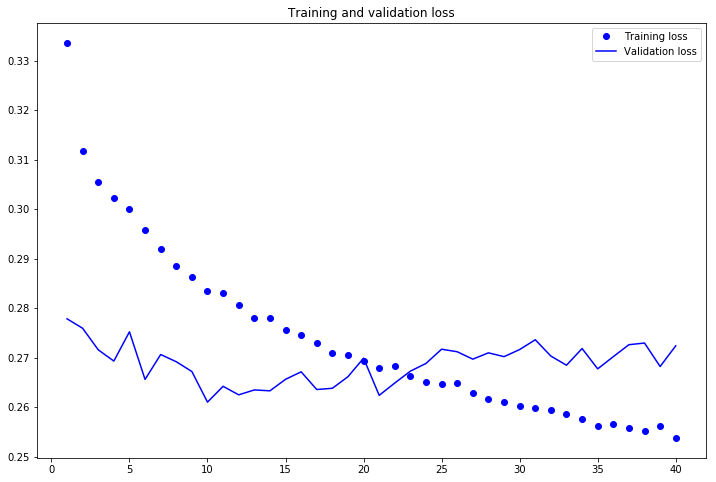

In [41]:
# Plotting the results
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.figure(figsize = (12, 8))
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()